## Importy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

## Do wizualizacji

In [2]:
def bias_to_color(bias, vmin, vmax):
    """Funkcja pomocniczna do liczenia koloru node"""

    if vmin < 0 and vmax > 0:
        # Przypadek 1: mamy biasy ujemne i dodatnie, wówczas używamy red yellow green color mapy
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        cmap = plt.get_cmap("RdYlGn") 
    elif vmin >= 0:
        # Przypadek 2: Wszystkie biasy >= 0, wówczas używamy yellow green color mapy
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap("YlGn")
    else:
        # Przypadek 3: Wszystkie biasy <= 0, wówczas używamy yellow orange red mapy (reversed, bo jest od yellow do red, a chcemy, żeby vmax był yellow dla ujemnych)
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap("YlOrRd_r")

    return cmap(norm(bias))

def draw_network_networkx(mlp):
    """Wizualizuje stan wag i biasów w sieci:
        - kolor neuronu zależy od wartości biasu (w danej wartwie)
        - kolor krawędzi zależy od znaku odpowiadającej wagi
        - grubość krawędzi zależy od wartości odpowiadającej wagi (tylko dana warstwa)
    """
    G = nx.DiGraph()

    # Zczytaj ilość neuronów
    layers_sizes = []
    input_size = mlp.layers[0].weights.shape[0]
    layers_sizes.append(input_size)
    for layer in mlp.layers:
        layers_sizes.append(layer.weights.shape[1])
    n_layers = len(layers_sizes)

    # Ustal pozycje
    pos = {}
    node_colors = {}
    h_spacing = 2.0  # Odległość horyzontalna między warstwami
    v_spacing = 1.5  # Odległość wertykalna między neuronami tej samej warstwy

    # Ustalamy pozycje i color neuronów
    for i, n_neurons in enumerate(layers_sizes): # dla i-tej warstwy
        x = i * h_spacing
        # Neurony oddzielamy równomiernie w warstwie
        if n_neurons > 1:
            y_positions = np.linspace(0, (n_neurons - 1) * v_spacing, n_neurons)
            y_positions = y_positions - np.max(y_positions) / 2
        else:
            y_positions = np.array([0])
        
        for j, y in enumerate(y_positions): # dla j-tego neuronu w i-tej warstwie
            node_id = (i, j)
            pos[node_id] = (x, y) # ustalamy pozycje neuronu
            if i == 0:
                # Dla input layer ustawiamy kolor neutralny
                node_colors[node_id] = 'lightblue'
            else: # Dla innej niż input layer
                bias = mlp.layers[i-1].biases[j]
                biases_layer = mlp.layers[i-1].biases
                # Normalizujemy kolor funkcją pomociczą
                if len(biases_layer) > 1: # Jeśli mamy > jeden neuron w wartstwie
                    vmin, vmax = np.min(biases_layer), np.max(biases_layer)
                    node_colors[node_id] = bias_to_color(bias, vmin, vmax)
                else: # Jeśli jest jeden nauron
                    node_colors[node_id] = "red" if bias < 0 else "green"
                    
            G.add_node(node_id)

    # Ustalamy grubość połączeń między neuronami na podstawie wag
    for i, layer in enumerate(mlp.layers): # DLa i-tej wastwy
        weights = layer.weights  # połączenie i-tej oraz (i+1)-tej warstwy
        max_weight = np.max(np.abs(weights))
        # Unkamy dzielenia przez 0
        if max_weight == 0:
            max_weight = 1
        for j in range(weights.shape[0]): # DLa j-tego neuronu z i-tej warstwy
            for k in range(weights.shape[1]): # Dla k-tego neurony z (i+1)-tej warstwy
                source = (i, j) # Od j tego neuronu z i-tej warstwy
                target = (i+1, k) # Do k-tego z i+1
                weight = weights[j, k]
                # Skalujemy grubość połączenia (w danej warstwie)
                lw = 0.5 + 5 * (abs(weight) / max_weight)
                color = "red" if weight < 0 else "green"
                G.add_edge(source, target, weight=weight, width=lw, color = color)

    # Rysujemy graf
    fig, ax = plt.subplots(figsize=(12, 8))
    # Rysujemy neurony z kolorami
    node_color_list = [node_colors[node] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_color_list, node_size=800, ax=ax)
    
    # Rysujemy połączenia z grubością i kolorami
    edge_widths = [d['width'] for (_, _, d) in G.edges(data=True)]
    edge_colors = [d['color'] for (_, _, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths, edge_color=edge_colors)
    
    # Labelujemy neurony za pomocą indexu w warstwie
    labels = {node: f"{node[1]}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, ax=ax)

    ax.set_title("Neural Net Visualization")
    ax.axis('off')
    plt.show()

def show_loss(epoch_arr, loss_arr):
    plt.figure(figsize = (12, 8))
    plt.plot(epoch_arr, loss_arr)
    plt.title("Loss vs epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def eval_2d(network, x, y):
    y_pred = network.predict(x)
    plt.scatter(x, y, s = 1, label = "True")
    plt.scatter(x, y_pred, s=1, label = "Predicted")
    plt.title(f"How fun is fitting desired y")
    plt.legend()
    plt.show()

## Definicja sieci

Zmiany w sieci od ostatniego:
- dodanie możliwości wyboru optimizera
- dodanie możliwości wyboru inicializacji wag

In [152]:
class Optimizer:
    def update(self, layer, dW, db):
        raise NotImplementedError("This method should be overridden")

class SGD(Optimizer):
    def __init__(self, lr=0.05):
        self.lr = lr

    def update(self, layer, dW, db):
        layer.weights -= self.lr * dW
        layer.biases  -= self.lr * db

class Momentum(Optimizer):
    def __init__(self, lr=0.05, lamb=0.9):
        self.lr = lr
        self.lamb = lamb
        self.momentum = {}

    def update(self, layer, dW, db):
        # Inicjujemy momentum
        if layer not in self.momentum:
            self.momentum[layer] = {'dW': np.zeros_like(dW), 'db': np.zeros_like(db)}

        ## Version 1
        # # Update sredniej
        # self.momentum[layer]['dW'] = self.lamb * self.momentum[layer]['dW'] - self.lr * dW
        # self.momentum[layer]['db'] = self.lamb * self.momentum[layer]['db'] - self.lr * db
        # # Update parametrow
        # layer.weights += self.momentum[layer]['dW']
        # layer.biases  += self.momentum[layer]['db']
        
        ## Version 2
        # Update momentum
        self.momentum[layer]['dW'] = self.lamb * self.momentum[layer]['dW'] - dW
        self.momentum[layer]['db'] = self.lamb * self.momentum[layer]['db'] - db
        
        # Update parameters using the momentum
        layer.weights += self.lr * self.momentum[layer]['dW']
        layer.biases  += self.lr * self.momentum[layer]['db']

class RMSProp(Optimizer):
    def __init__(self, lr=0.05, beta = 0.9):
        self.lr = lr
        self.beta = beta
        self.mean_sq_grad = {}
    
    def update(self, layer, dW, db):
        # Inicjujemy
        if layer not in self.mean_sq_grad:
            self.mean_sq_grad[layer] = {'dW': np.zeros_like(dW), 'db': np.zeros_like(db)}
        # Update sredniej
        self.mean_sq_grad[layer]['dW'] = self.beta * self.mean_sq_grad[layer]['dW'] + (1 - self.beta) * dW ** 2
        self.mean_sq_grad[layer]['db'] = self.beta * self.mean_sq_grad[layer]['db'] + (1 - self.beta) * db ** 2

        # Update parametrow
        layer.weights -= self.lr * dW / np.sqrt(self.mean_sq_grad[layer]['dW'] + np.finfo(float).eps)
        layer.biases  -= self.lr * db / np.sqrt(self.mean_sq_grad[layer]['db'] + np.finfo(float).eps)

class Adam(Optimizer):
    def __init__(self, lr=0.01, beta1 = 0.9, beta2 = 0.999, epsilon = np.finfo(float).eps):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.m = {}
        self.v = {}
        self.t = {}
        self.epsilon = epsilon
        
    def update(self, layer, dW, db):
        # Inicjujemy
        if layer not in self.m:
            self.m[layer] = {'dW': np.zeros_like(dW), 'db': np.zeros_like(db)}
            self.v[layer] = {'dW': np.zeros_like(dW), 'db': np.zeros_like(db)}
            self.t[layer] = 0

        # Set t
        self.t[layer] += 1
        
        # Update weights
        self.m[layer]["dW"] = self.beta1 * self.m[layer]["dW"] + (1 - self.beta1) * dW
        self.v[layer]["dW"] = self.beta2 * self.v[layer]["dW"] + (1 - self.beta2) * dW**2
        m_hat = self.m[layer]["dW"] / (1 - self.beta1**self.t[layer])
        v_hat = self.v[layer]["dW"] / (1 - self.beta2**self.t[layer])
        layer.weights -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

        # Update bias
        self.m[layer]["db"] = self.beta1 * self.m[layer]["db"] + (1 - self.beta1) * db
        self.v[layer]["db"] = self.beta2 * self.v[layer]["db"] + (1 - self.beta2) * db**2
        m_hat = self.m[layer]["db"] / (1 - self.beta1**self.t[layer])
        v_hat = self.v[layer]["db"] / (1 - self.beta2**self.t[layer])
        layer.biases -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

In [95]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_deriv(output):
    # Zakłada, że wejściem jest "a", a nie "z" (czyli, że jest to już po zastosowaniu sigmoid(a))
    return output * (1 - output)
def linear(x):
    return x
def linear_deriv(x):
    return 1.0
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

class Layer: # Warstwa sieci
    def __init__(self, input_size, output_size, act_fun, act_derivative, init_type = 'random'):
        if init_type == "random":
            self.weights = np.random.random((input_size, output_size))
            self.biases = np.random.random(output_size)
        elif init_type == "xavier":
            limit = np.sqrt(2 / (input_size + output_size))
            self.weights = np.random.randn(input_size, output_size) * limit
            self.biases = np.zeros(output_size)
        self.act_fun = act_fun
        self.act_derivative = act_derivative
        self.a_in = None
        self.z = None
        self.a_out = None

    def forward(self, x):
        self.a_in = x
        z = np.dot(x, self.weights) + self.biases
        self.z = z
        z = self.act_fun(z)
        self.a_out = z
        return z

    def backward(self, dA):
        # dC / dz
        dZ = self.act_derivative(self.a_out) * dA # zakładamy, że używamy act_derivative na "a", a nie na "z". W przypadku ostatniej warstwy nie ma to znaczenia, o ile zakładamy, że wyjście jest funkcją liniową, a zatem ma stałą pochodną
        # Zmiana na wagach (L)
        dW = np.dot(self.a_in.T, dZ)
        # Zmiana na bias (L)
        db = np.sum(dZ, axis=0)
        # Zmiana dA (L-1)
        dA_in = np.dot(dZ, self.weights.T)
        return dA_in, dW, db
    
    def show_params(self):
        print("Weights")
        print(self.weights)
        print("Biases")
        print(self.biases)

class MLP: # Cała sieć
    def __init__(self, neural_arr, act_fun, act_derivative, out_fun, out_derivative, init_type = "random"):
        self.layers = []
        for i in range(len(neural_arr) - 2):
            self.layers.append(Layer(neural_arr[i], neural_arr[i+1], act_fun, act_derivative, init_type))
        self.layers.append(Layer(neural_arr[-2], neural_arr[-1], out_fun, out_derivative, init_type))

        # Do standaryzacji potem
        self.input_mean = None
        self.input_std = None
        self.output_mean = None
        self.output_std = None

    def standarize_input(self, x):
        return (x - self.input_mean) / self.input_std
    def standarize_output(self, y):
        return (y - self.output_mean) / self.output_std
    def destandarize_output(self, y_std):
        return y_std * self.output_std + self.output_mean

    def forward(self, x):
        z = x.copy()
        for i in range(len(self.layers)):
            z = self.layers[i].forward(z)
        return z
        
    def predict(self, x):
        x_std = self.standarize_input(x)
        y_std = self.forward(x_std)
        return self.destandarize_output(y_std)

    def backward(self, dA, optimizer):
        for layer in reversed(self.layers):
            dA, dW, db = layer.backward(dA)
            optimizer.update(layer, dW, db)

    def train(self, x, y, epochs = 100, optimizer = None, batch_size = None):
        """Batch Gradient Descent by default"""
        # Zapisuje średnie i odchylenia inputu i outputu
        self.input_mean = np.mean(x, axis=0)
        self.input_std = np.std(x, axis=0)
        self.output_mean = np.mean(y, axis=0)
        self.output_std = np.std(y, axis=0)

        # standaryzuje x i y zanim zaczne uczyc
        x_std = self.standarize_input(x)
        y_std = self.standarize_output(y)

        if batch_size == None: # Zapewnia, że jest to batch gradient descent by default
            batch_size = y.shape[0]
        optimizer = optimizer if optimizer is not None else SGD(lr=0.05) # Zapewnia, że istnieje optimizer
        
        # Trenujemy
        for epoch in range(epochs):
            loss = 0

            if batch_size != 1:
                # tworze batche
                order = np.arange(y.shape[0])
                np.random.shuffle(order)
                batches = np.array_split(order, len(order) // batch_size + (len(order) % batch_size != 0) )
            else: # Znacznie polepsza czas gdy chcemy brac jedna probke na raz (sgd)
                batches = np.arange(y.shape[0]).reshape(-1, 1)
            
            for batch in batches:
                x_tmp = x_std[batch]
                y_tmp = y_std[batch]
                # Forward
                y_pred_std = self.forward(x_tmp)
                loss += mse(y_tmp, y_pred_std)
                # Backward
                # Trzeba podzielić jeszcze przez wielkość próby, bo gradient "na raz" chcę się za dużo poprawić / batch_size
                dA = (y_pred_std - y_tmp) / batch_size
                self.backward(dA, optimizer)

            loss = loss / len(batches)
            if epoch % int(epochs / 20) == 0:
                print(f"Epoch: {epoch+1}, Loss (standarized): {loss}")
        
        print(f"Final epoch: {epoch+1}, Final loss (standarized): {loss}")

    def train_to_visualize(self, x, y, epochs = 100, optimizer = None, batch_size = None):
        """Batch Gradient Descent by default"""
        # Zapisuje średnie i odchylenia inputu i outputu
        self.input_mean = np.mean(x, axis=0)
        self.input_std = np.std(x, axis=0)
        self.output_mean = np.mean(y, axis=0)
        self.output_std = np.std(y, axis=0)

        # standaryzuje x i y zanim zaczne uczyc
        x_std = self.standarize_input(x)
        y_std = self.standarize_output(y)

        if batch_size == None: # Zapewnia, że jest to batch gradient descent by default
            batch_size = y.shape[0]
        optimizer = optimizer if optimizer is not None else SGD(lr=0.05) # Zapewnia, że istnieje optimizer
        
        # Trenujemy
        loss_history = np.zeros(epochs)
        for epoch in range(epochs):
            loss = 0

            if batch_size != 1:
                # tworze batche
                order = np.arange(y.shape[0])
                np.random.shuffle(order)
                batches = np.array_split(order, len(order) // batch_size + (len(order) % batch_size != 0) )
            else: # Znacznie polepsza czas gdy chcemy brac jedna probke na raz (sgd)
                batches = np.arange(y.shape[0]).reshape(-1, 1)
            
            for batch in batches:
                x_tmp = x_std[batch]
                y_tmp = y_std[batch]
                # Forward
                y_pred_std = self.forward(x_tmp)
                loss += mse(y_tmp, y_pred_std)
                # Backward
                # Trzeba podzielić jeszcze przez wielkość próby, bo gradient "na raz" chcę się za dużo poprawić / batch_size
                dA = (y_pred_std - y_tmp) / batch_size
                self.backward(dA, optimizer)

            loss = loss / len(batches)
            loss_history[epoch] = loss
            if epoch % int(epochs / 20) == 0:
                print(f"Epoch: {epoch+1}, Loss (standarized): {loss}")
        
        print(f"Final epoch: {epoch+1}, Final loss (standarized): {loss}")
        
        return loss_history

    def show_params(self):
        for i in range(len(self.layers)):
            print("Layer: ", i)
            self.layers[i].show_params()
            print("")

## Content

### 1. Dane square-large

In [174]:
# Pobieramy dane
data_train = pd.read_csv("../Data/regression/square-large-training.csv", index_col = 0).to_numpy()
x_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)

data_test = pd.read_csv("../Data/regression/square-large-test.csv", index_col = 0).to_numpy()
x_test = data_test[:, 0].reshape(-1, 1)
y_test = data_test[:, 1].reshape(-1, 1)

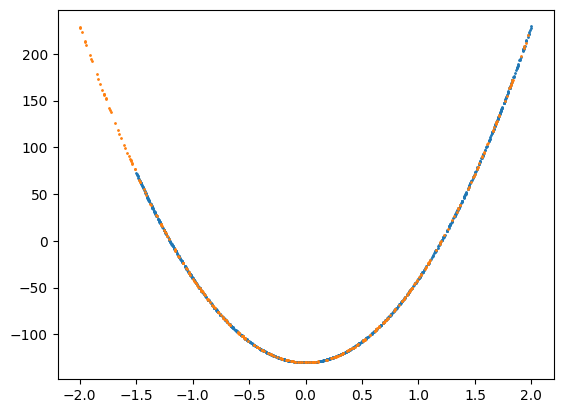

In [6]:
plt.scatter(x_train, y_train, s = 1)
plt.scatter(x_test, y_test, s = 1)
plt.show()

#### Momentum

UWAGA! Tu nie było jeszcze zaimplementowana inicializacja wag xavier, więc kod nie będzie działał, zostawiam jako archiwum

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.027859469755886
Epoch: 251, Loss (standarized): 0.00037416070361284985
Epoch: 501, Loss (standarized): 0.0002746710180363575
Epoch: 751, Loss (standarized): 0.00017242119877029912
Epoch: 1001, Loss (standarized): 0.00014625059779013063
Epoch: 1251, Loss (standarized): 0.0001064555363434297
Epoch: 1501, Loss (standarized): 8.24904375892346e-05
Epoch: 1751, Loss (standarized): 9.564892000242033e-05
Epoch: 2001, Loss (standarized): 5.9451257239070435e-05
Epoch: 2251, Loss (standarized): 2.7798029146772714e-05
Epoch: 2501, Loss (standarized): 1.8584707643037257e-05
Epoch: 2751, Loss (standarized): 1.376075520450297e-05
Epoch: 3001, Loss (standarized): 1.0000635508934487e-05
Epoch: 3251, Loss (standarized): 9.025489182319717e-06
Epoch: 3501, Loss (standarized): 8.135799092139792e-06
Epoch: 3751,

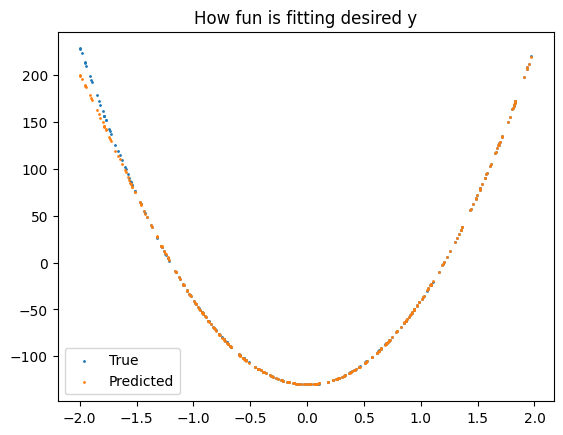

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.4454170803356934
Epoch: 251, Loss (standarized): 5.5783225575128886e-05
Epoch: 501, Loss (standarized): 5.454382822456721e-05
Epoch: 751, Loss (standarized): 2.6757517615254645e-05
Epoch: 1001, Loss (standarized): 2.450514718051151e-05
Epoch: 1251, Loss (standarized): 2.0922771327665574e-05
Epoch: 1501, Loss (standarized): 2.106789835727611e-05
Epoch: 1751, Loss (standarized): 1.4809360741225103e-05
Epoch: 2001, Loss (standarized): 2.137403282968985e-05
Epoch: 2251, Loss (standarized): 1.3688324914825037e-05
Epoch: 2501, Loss (standarized): 1.1303136788515651e-05
Epoch: 2751, Loss (standarized): 1.2362713607476095e-05
Epoch: 3001, Loss (standarized): 1.2044870731045448e-05
Epoch: 3251, Loss (standarized): 9.608137339226915e-06
Epoch: 3501, Loss (standarized): 9.352774466485381e-06
Epoch: 3

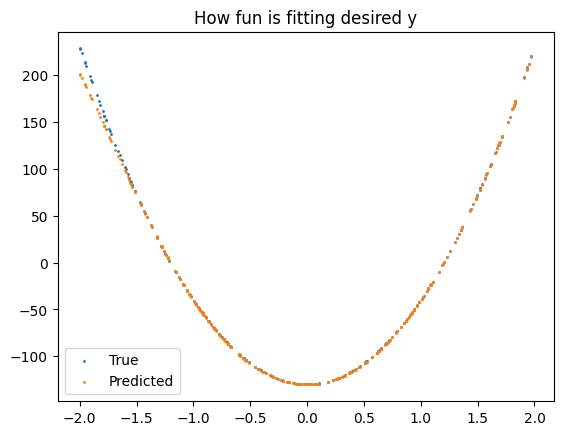

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.319842832421166
Epoch: 251, Loss (standarized): 0.010519912711133296
Epoch: 501, Loss (standarized): 0.015289556760151455
Epoch: 751, Loss (standarized): 0.001402109841959043
Epoch: 1001, Loss (standarized): 0.0022321312476395972
Epoch: 1251, Loss (standarized): 0.03215411281845877
Epoch: 1501, Loss (standarized): 0.003555221697974269
Epoch: 1751, Loss (standarized): 0.0019423769050614288
Epoch: 2001, Loss (standarized): 0.0007250957432754071
Epoch: 2251, Loss (standarized): 0.0003300163731825047
Epoch: 2501, Loss (standarized): 0.0027371226275191207
Epoch: 2751, Loss (standarized): 0.0004519925242941154
Epoch: 3001, Loss (standarized): 0.0009490570709391609
Epoch: 3251, Loss (standarized): 0.0003667516514732384
Epoch: 3501, Loss (standarized): 0.00036372342218176604
Epoch: 3751, Loss (sta

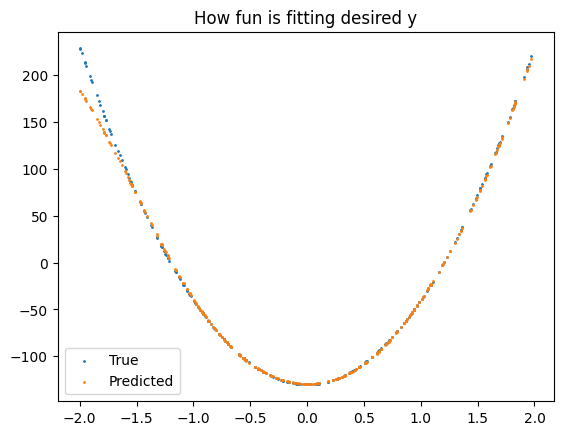

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.0925534358459505
Epoch: 251, Loss (standarized): 0.00029252655978760764
Epoch: 501, Loss (standarized): 8.401611770824479e-05
Epoch: 751, Loss (standarized): 2.731006407636795e-05
Epoch: 1001, Loss (standarized): 1.6274553397338534e-05
Epoch: 1251, Loss (standarized): 1.2882315631708652e-05
Epoch: 1501, Loss (standarized): 1.1581558091254201e-05
Epoch: 1751, Loss (standarized): 1.0396677648548163e-05
Epoch: 2001, Loss (standarized): 9.547557517764458e-06
Epoch: 2251, Loss (standarized): 9.387952998438165e-06
Epoch: 2501, Loss (standarized): 8.061358068137528e-06
Epoch: 2751, Loss (standarized): 7.457171820981113e-06
Epoch: 3001, Loss (standarized): 6.914089286478408e-06
Epoch: 3251, Loss (standarized): 6.748014043805707e-06
Epoch: 3501, Loss (standarized): 6.572410525834481e-06
Epoch: 3751

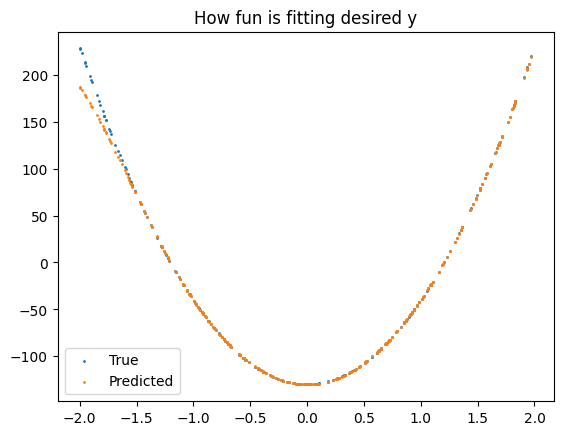

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.7661268861247228
Epoch: 251, Loss (standarized): 9.074380766135993e-05
Epoch: 501, Loss (standarized): 3.693286960712779e-05
Epoch: 751, Loss (standarized): 2.943042177665469e-05
Epoch: 1001, Loss (standarized): 3.0026771981833114e-05
Epoch: 1251, Loss (standarized): 2.349143954630255e-05
Epoch: 1501, Loss (standarized): 2.1064447203052452e-05
Epoch: 1751, Loss (standarized): 1.9470521781453095e-05
Epoch: 2001, Loss (standarized): 1.8713636910300953e-05
Epoch: 2251, Loss (standarized): 1.7401773736419697e-05
Epoch: 2501, Loss (standarized): 1.5983999125524877e-05
Epoch: 2751, Loss (standarized): 1.627756199936487e-05
Epoch: 3001, Loss (standarized): 1.435258340607346e-05
Epoch: 3251, Loss (standarized): 1.816954493358641e-05
Epoch: 3501, Loss (standarized): 1.3459024706165827e-05
Epoch: 3

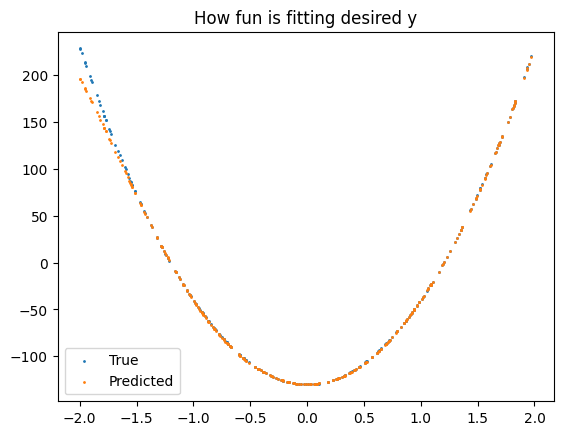

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.8351167985049592
Epoch: 251, Loss (standarized): 0.0007373277666321567
Epoch: 501, Loss (standarized): 0.0014365944955875233
Epoch: 751, Loss (standarized): 0.0008427879728788379
Epoch: 1001, Loss (standarized): 0.0007666592365003996
Epoch: 1251, Loss (standarized): 0.0022939198406526883
Epoch: 1501, Loss (standarized): 0.000660421610229392
Epoch: 1751, Loss (standarized): 0.0005458795871653785
Epoch: 2001, Loss (standarized): 0.0038573595463242197
Epoch: 2251, Loss (standarized): 0.00020321361933054886
Epoch: 2501, Loss (standarized): 0.00033227628982201643
Epoch: 2751, Loss (standarized): 0.001210055909459388
Epoch: 3001, Loss (standarized): 0.00038950205912334236
Epoch: 3251, Loss (standarized): 0.0033722425410640244
Epoch: 3501, Loss (standarized): 0.0003572125680930863
Epoch: 3751, L

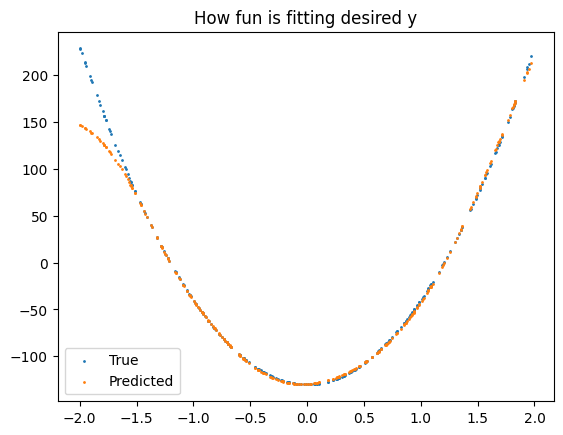

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.1142310791432775
Epoch: 251, Loss (standarized): 0.00045505373393400235
Epoch: 501, Loss (standarized): 0.00033562308973586165
Epoch: 751, Loss (standarized): 0.00029383040256930837
Epoch: 1001, Loss (standarized): 0.00021935735649613756
Epoch: 1251, Loss (standarized): 0.00019762852087410322
Epoch: 1501, Loss (standarized): 0.00017737376580144286
Epoch: 1751, Loss (standarized): 0.00016035681103558405
Epoch: 2001, Loss (standarized): 0.00014357943072150942
Epoch: 2251, Loss (standarized): 0.0001311185568398025
Epoch: 2501, Loss (standarized): 0.00012244886568866557
Epoch: 2751, Loss (standarized): 0.00011522898936607941
Epoch: 3001, Loss (standarized): 0.00010475872386828216
Epoch: 3251, Loss (standarized): 9.842752582784558e-05
Epoch: 3501, Loss (standarized): 9.47649973104706e-05
Epoch:

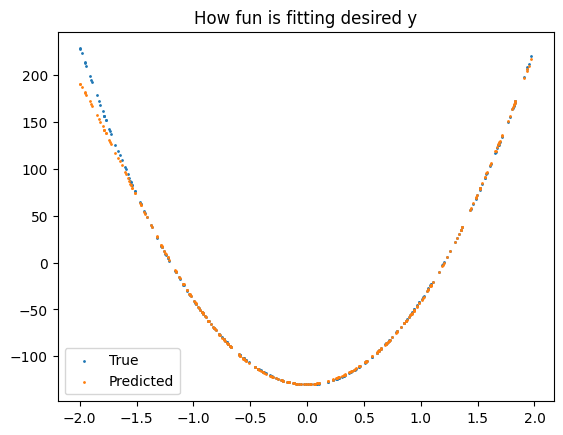

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.8611126035085277
Epoch: 251, Loss (standarized): 0.00029893660664189836
Epoch: 501, Loss (standarized): 0.00011501049150339668
Epoch: 751, Loss (standarized): 6.220795562444098e-05
Epoch: 1001, Loss (standarized): 4.597178364502856e-05
Epoch: 1251, Loss (standarized): 3.8117385456999944e-05
Epoch: 1501, Loss (standarized): 3.5990558884237696e-05
Epoch: 1751, Loss (standarized): 3.2087046098101315e-05
Epoch: 2001, Loss (standarized): 3.0206698044016058e-05
Epoch: 2251, Loss (standarized): 2.7820754516112168e-05
Epoch: 2501, Loss (standarized): 2.7907535259921173e-05
Epoch: 2751, Loss (standarized): 2.486476602559386e-05
Epoch: 3001, Loss (standarized): 2.4721918696365766e-05
Epoch: 3251, Loss (standarized): 2.2381747954657616e-05
Epoch: 3501, Loss (standarized): 2.2547430117906433e-05
Epoc

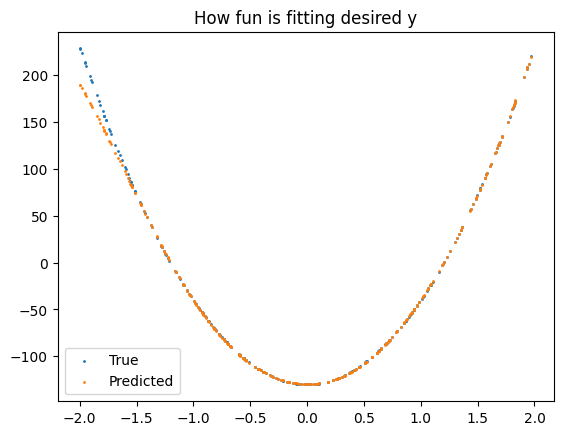

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.7414269677208467
Epoch: 251, Loss (standarized): 0.00017157554798400088
Epoch: 501, Loss (standarized): 6.736861719980416e-05
Epoch: 751, Loss (standarized): 6.182442132846525e-05
Epoch: 1001, Loss (standarized): 3.781871501819991e-05
Epoch: 1251, Loss (standarized): 4.5010251852186876e-05
Epoch: 1501, Loss (standarized): 2.40433419751756e-05
Epoch: 1751, Loss (standarized): 2.0600920598756727e-05
Epoch: 2001, Loss (standarized): 1.8637735848447985e-05
Epoch: 2251, Loss (standarized): 2.0234785178005092e-05
Epoch: 2501, Loss (standarized): 2.4034068671648e-05
Epoch: 2751, Loss (standarized): 1.3734843124408349e-05
Epoch: 3001, Loss (standarized): 1.537252239190045e-05
Epoch: 3251, Loss (standarized): 1.5013216578290438e-05
Epoch: 3501, Loss (standarized): 1.4542264524595376e-05
Epoch: 375

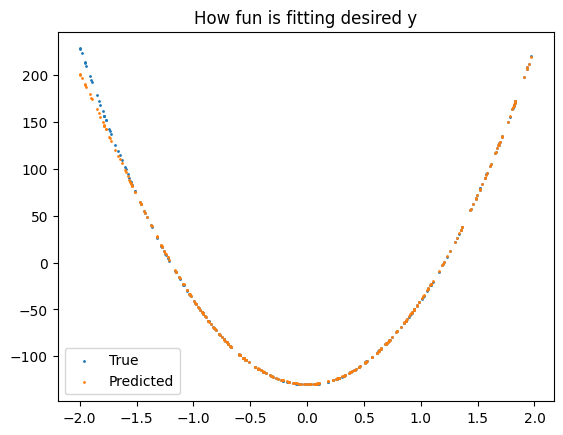

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.6015103512595525
Epoch: 251, Loss (standarized): 0.0009549829113663813
Epoch: 501, Loss (standarized): 0.00076065014543099
Epoch: 751, Loss (standarized): 0.0006511306865894866
Epoch: 1001, Loss (standarized): 0.000567313983792681
Epoch: 1251, Loss (standarized): 0.0004906669645855531
Epoch: 1501, Loss (standarized): 0.0004453989984753475
Epoch: 1751, Loss (standarized): 0.00041075279818448684
Epoch: 2001, Loss (standarized): 0.0003781401047973875
Epoch: 2251, Loss (standarized): 0.0003562184854531123
Epoch: 2501, Loss (standarized): 0.00032790858581619483
Epoch: 2751, Loss (standarized): 0.00031307215048919317
Epoch: 3001, Loss (standarized): 0.0002957337358905321
Epoch: 3251, Loss (standarized): 0.0002782953547170066
Epoch: 3501, Loss (standarized): 0.000262014882528217
Epoch: 3751, Loss

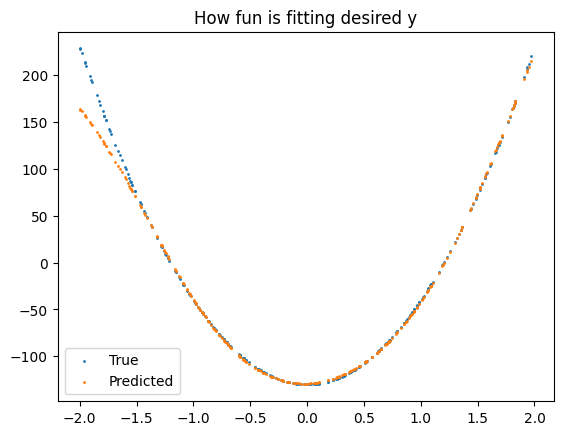

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.9787180402734532
Epoch: 251, Loss (standarized): 0.0004615848041545906
Epoch: 501, Loss (standarized): 0.00034045830340333075
Epoch: 751, Loss (standarized): 0.0002588378362400543
Epoch: 1001, Loss (standarized): 0.0002017696250143988
Epoch: 1251, Loss (standarized): 0.0001616884880809885
Epoch: 1501, Loss (standarized): 0.0001326472885729186
Epoch: 1751, Loss (standarized): 9.796130357947214e-05
Epoch: 2001, Loss (standarized): 7.2510696073586e-05
Epoch: 2251, Loss (standarized): 5.3751478902085225e-05
Epoch: 2501, Loss (standarized): 3.999579149575216e-05
Epoch: 2751, Loss (standarized): 3.0269842563178486e-05
Epoch: 3001, Loss (standarized): 2.3180881976639093e-05
Epoch: 3251, Loss (standarized): 1.8816552908882867e-05
Epoch: 3501, Loss (standarized): 1.6192934529251896e-05
Epoch: 3751

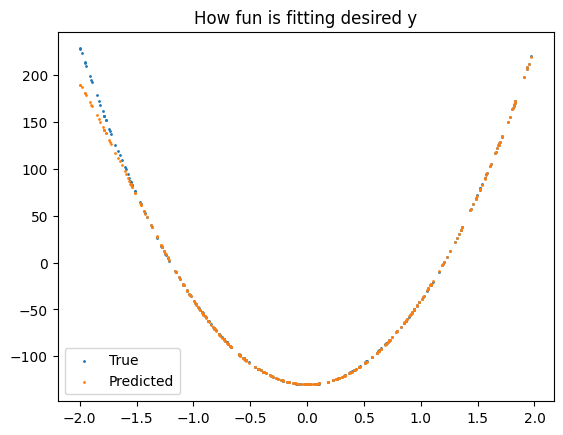

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.2018767047913546
Epoch: 251, Loss (standarized): 0.00012876600202894108
Epoch: 501, Loss (standarized): 8.235870535643853e-05
Epoch: 751, Loss (standarized): 6.235162289360444e-05
Epoch: 1001, Loss (standarized): 5.796372367600276e-05
Epoch: 1251, Loss (standarized): 4.6195684108596026e-05
Epoch: 1501, Loss (standarized): 3.750399988970772e-05
Epoch: 1751, Loss (standarized): 3.2665329854215956e-05
Epoch: 2001, Loss (standarized): 3.0243184667165957e-05
Epoch: 2251, Loss (standarized): 2.9686079921377045e-05
Epoch: 2501, Loss (standarized): 3.0352545177044886e-05
Epoch: 2751, Loss (standarized): 2.476267164778711e-05
Epoch: 3001, Loss (standarized): 2.2782112267615204e-05
Epoch: 3251, Loss (standarized): 2.386336335398617e-05
Epoch: 3501, Loss (standarized): 2.1498029290751234e-05
Epoch: 

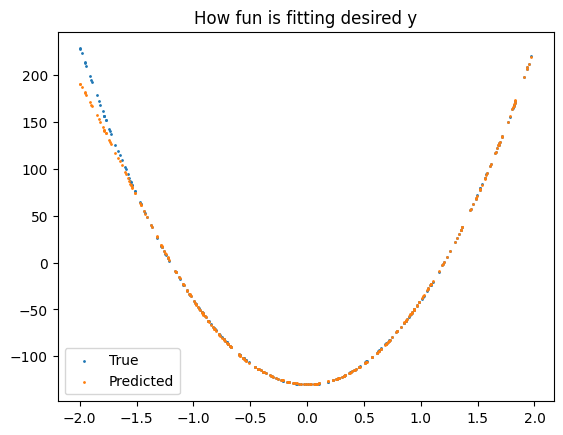

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.6789092305712852
Epoch: 251, Loss (standarized): 0.0009999084532470836
Epoch: 501, Loss (standarized): 0.0005488304816054997
Epoch: 751, Loss (standarized): 0.0004438386799581789
Epoch: 1001, Loss (standarized): 0.0003709876336653559
Epoch: 1251, Loss (standarized): 0.0003153454460018759
Epoch: 1501, Loss (standarized): 0.0002727224052707418
Epoch: 1751, Loss (standarized): 0.00023575747292498326
Epoch: 2001, Loss (standarized): 0.00020589102802808995
Epoch: 2251, Loss (standarized): 0.0001794672074658204
Epoch: 2501, Loss (standarized): 0.00015833075076210112
Epoch: 2751, Loss (standarized): 0.00013819699725263238
Epoch: 3001, Loss (standarized): 0.00012130241072831125
Epoch: 3251, Loss (standarized): 0.00010751511700077714
Epoch: 3501, Loss (standarized): 9.346977510147188e-05
Epoch: 37

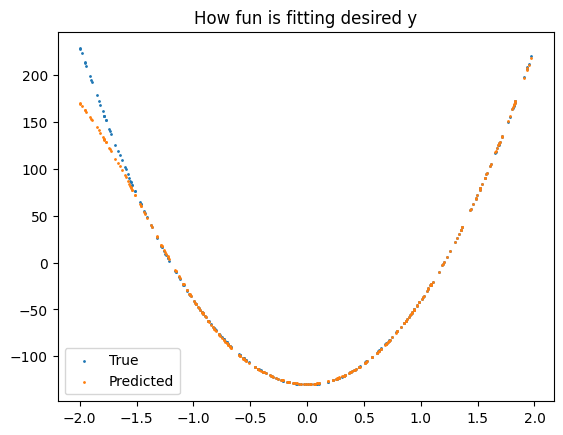

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.424716344558733
Epoch: 251, Loss (standarized): 0.0005878015598142841
Epoch: 501, Loss (standarized): 0.0004297384914745166
Epoch: 751, Loss (standarized): 0.00037409117898757314
Epoch: 1001, Loss (standarized): 0.0003342402433510787
Epoch: 1251, Loss (standarized): 0.0002984921869539746
Epoch: 1501, Loss (standarized): 0.00026676175352412034
Epoch: 1751, Loss (standarized): 0.00024168038544324061
Epoch: 2001, Loss (standarized): 0.00022145840148200544
Epoch: 2251, Loss (standarized): 0.00020327771008730585
Epoch: 2501, Loss (standarized): 0.00018621354019924058
Epoch: 2751, Loss (standarized): 0.0001749663901352628
Epoch: 3001, Loss (standarized): 0.0001594970697325514
Epoch: 3251, Loss (standarized): 0.00014990753129283244
Epoch: 3501, Loss (standarized): 0.0001346810254198371
Epoch: 3

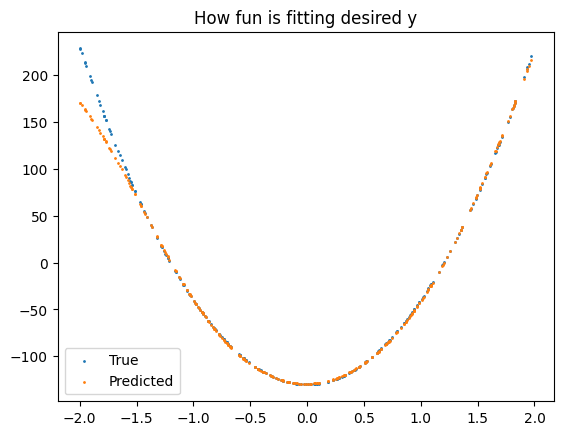

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.620503515517676
Epoch: 251, Loss (standarized): 0.000247327422794179
Epoch: 501, Loss (standarized): 0.00015235892492062466
Epoch: 751, Loss (standarized): 0.00011781611623194835
Epoch: 1001, Loss (standarized): 9.039602287274074e-05
Epoch: 1251, Loss (standarized): 7.166048155070932e-05
Epoch: 1501, Loss (standarized): 6.181985930153749e-05
Epoch: 1751, Loss (standarized): 5.5016461093338786e-05
Epoch: 2001, Loss (standarized): 4.632821697365682e-05
Epoch: 2251, Loss (standarized): 4.374457531163794e-05
Epoch: 2501, Loss (standarized): 4.017901609413124e-05
Epoch: 2751, Loss (standarized): 3.446007710189008e-05
Epoch: 3001, Loss (standarized): 3.2060255282896006e-05
Epoch: 3251, Loss (standarized): 3.170115673319792e-05
Epoch: 3501, Loss (standarized): 2.7249024126982828e-05
Epoch: 3751

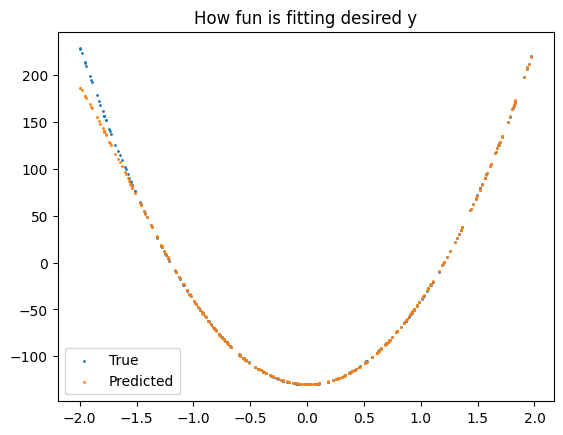

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.2828236054686375
Epoch: 251, Loss (standarized): 0.008247553470794176
Epoch: 501, Loss (standarized): 0.001851117431757433
Epoch: 751, Loss (standarized): 0.0011876946458061843
Epoch: 1001, Loss (standarized): 0.001048703981809528
Epoch: 1251, Loss (standarized): 0.0009801481885075274
Epoch: 1501, Loss (standarized): 0.0009242315859916828
Epoch: 1751, Loss (standarized): 0.0008810650269360689
Epoch: 2001, Loss (standarized): 0.00084030326763202
Epoch: 2251, Loss (standarized): 0.000804061035778405
Epoch: 2501, Loss (standarized): 0.0007672097285839704
Epoch: 2751, Loss (standarized): 0.0007362408781613654
Epoch: 3001, Loss (standarized): 0.0007069136410496619
Epoch: 3251, Loss (standarized): 0.0006811603740522571
Epoch: 3501, Loss (standarized): 0.0006566848977147356
Epoch: 3751, Loss (st

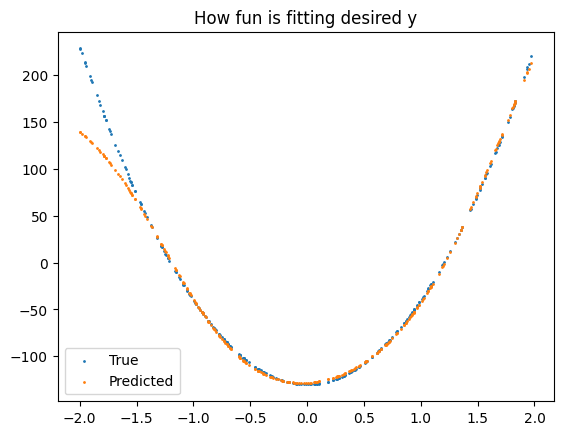

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.148949295492977
Epoch: 251, Loss (standarized): 0.00139884062329502
Epoch: 501, Loss (standarized): 0.0009444239669919709
Epoch: 751, Loss (standarized): 0.0008251243256088556
Epoch: 1001, Loss (standarized): 0.0007148770023988716
Epoch: 1251, Loss (standarized): 0.0006292813345137459
Epoch: 1501, Loss (standarized): 0.0005602084743275657
Epoch: 1751, Loss (standarized): 0.0005013007653295415
Epoch: 2001, Loss (standarized): 0.00044726180256796625
Epoch: 2251, Loss (standarized): 0.0004012532735406817
Epoch: 2501, Loss (standarized): 0.0003626072223365234
Epoch: 2751, Loss (standarized): 0.00032638200033952675
Epoch: 3001, Loss (standarized): 0.00029421862734394714
Epoch: 3251, Loss (standarized): 0.00026685990598942117
Epoch: 3501, Loss (standarized): 0.00024078133688198243
Epoch: 3751,

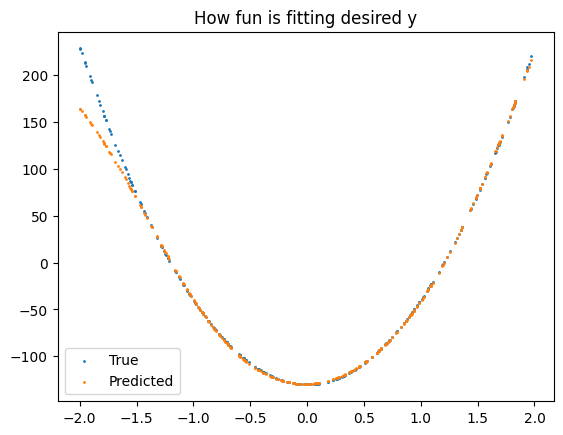

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.8059488718579058
Epoch: 251, Loss (standarized): 0.0002603342155269921
Epoch: 501, Loss (standarized): 0.00016026101714812692
Epoch: 751, Loss (standarized): 0.00010324011018282461
Epoch: 1001, Loss (standarized): 7.484485172988809e-05
Epoch: 1251, Loss (standarized): 6.0439636430963745e-05
Epoch: 1501, Loss (standarized): 5.472653814304518e-05
Epoch: 1751, Loss (standarized): 4.896950851888447e-05
Epoch: 2001, Loss (standarized): 4.551333321184158e-05
Epoch: 2251, Loss (standarized): 4.4849389031208585e-05
Epoch: 2501, Loss (standarized): 4.2089372752866696e-05
Epoch: 2751, Loss (standarized): 4.013272837598841e-05
Epoch: 3001, Loss (standarized): 3.894269856992285e-05
Epoch: 3251, Loss (standarized): 3.712716936018138e-05
Epoch: 3501, Loss (standarized): 3.627891997039532e-05
Epoch: 37

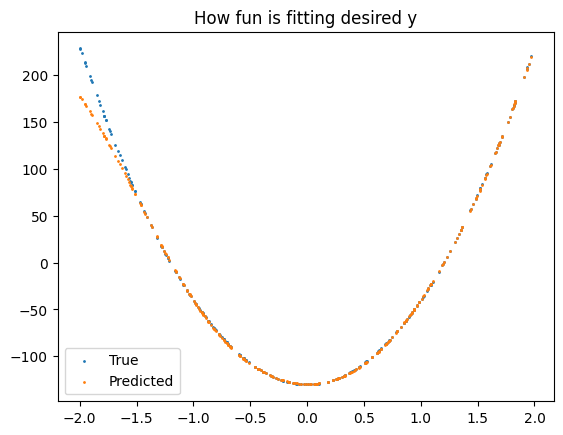

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.0943517285067443
Epoch: 251, Loss (standarized): 0.03803442293766293
Epoch: 501, Loss (standarized): 0.008380491311484644
Epoch: 751, Loss (standarized): 0.0028908935483306472
Epoch: 1001, Loss (standarized): 0.0015495936254788297
Epoch: 1251, Loss (standarized): 0.0011005046673051152
Epoch: 1501, Loss (standarized): 0.0009105707632172783
Epoch: 1751, Loss (standarized): 0.0008142595503658351
Epoch: 2001, Loss (standarized): 0.0007551558376361698
Epoch: 2251, Loss (standarized): 0.0007161306418080901
Epoch: 2501, Loss (standarized): 0.0006842398598969226
Epoch: 2751, Loss (standarized): 0.0006573240523969681
Epoch: 3001, Loss (standarized): 0.0006293214881890965
Epoch: 3251, Loss (standarized): 0.0006051475934739865
Epoch: 3501, Loss (standarized): 0.0005827734686217215
Epoch: 3751, Loss 

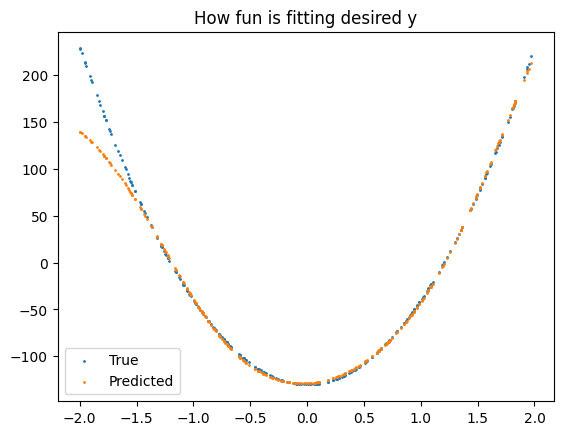

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.5393337337523807
Epoch: 251, Loss (standarized): 0.0158945173979001
Epoch: 501, Loss (standarized): 0.0033698871532599184
Epoch: 751, Loss (standarized): 0.0011724515694482515
Epoch: 1001, Loss (standarized): 0.0006229285102506734
Epoch: 1251, Loss (standarized): 0.0004518992950001076
Epoch: 1501, Loss (standarized): 0.0003818187663085234
Epoch: 1751, Loss (standarized): 0.0003391442097082091
Epoch: 2001, Loss (standarized): 0.000308016329441814
Epoch: 2251, Loss (standarized): 0.000277875124632525
Epoch: 2501, Loss (standarized): 0.0002550309473157336
Epoch: 2751, Loss (standarized): 0.00023359234847612008
Epoch: 3001, Loss (standarized): 0.00021766973248005513
Epoch: 3251, Loss (standarized): 0.00019980727485482947
Epoch: 3501, Loss (standarized): 0.00018659513848548584
Epoch: 3751, Lo

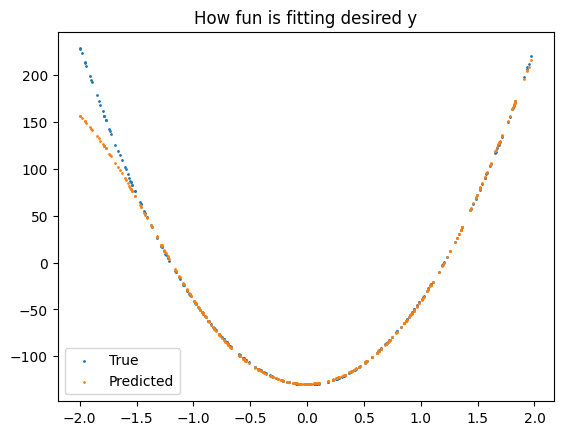

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.105165464212709
Epoch: 251, Loss (standarized): 0.0005856100682045331
Epoch: 501, Loss (standarized): 0.00038426038774032795
Epoch: 751, Loss (standarized): 0.00028984047994561204
Epoch: 1001, Loss (standarized): 0.00023295777965867773
Epoch: 1251, Loss (standarized): 0.0001855794135324904
Epoch: 1501, Loss (standarized): 0.00015209581203654937
Epoch: 1751, Loss (standarized): 0.00012540873678213053
Epoch: 2001, Loss (standarized): 0.00010106948645765913
Epoch: 2251, Loss (standarized): 8.310614122700368e-05
Epoch: 2501, Loss (standarized): 6.751042523492931e-05
Epoch: 2751, Loss (standarized): 5.6171528185294446e-05
Epoch: 3001, Loss (standarized): 4.471404892028585e-05
Epoch: 3251, Loss (standarized): 3.672492357649045e-05
Epoch: 3501, Loss (standarized): 3.320091875210613e-05
Epoch: 3

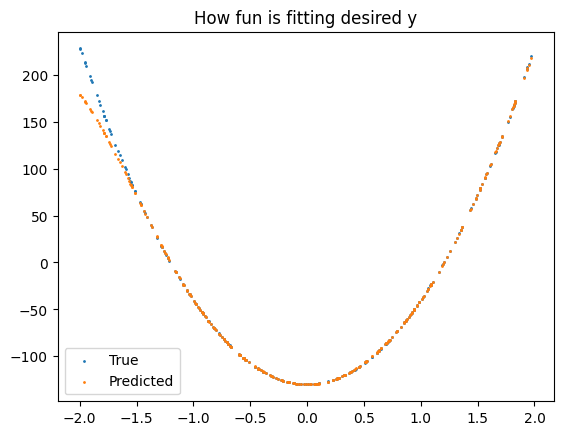

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.786905719785965
Epoch: 251, Loss (standarized): 3.784584787557685e-05
Epoch: 501, Loss (standarized): 2.7715462047416012e-05
Epoch: 751, Loss (standarized): 2.117051623780168e-05
Epoch: 1001, Loss (standarized): 1.796999094497126e-05
Epoch: 1251, Loss (standarized): 1.6154472659164634e-05
Epoch: 1501, Loss (standarized): 1.529626141651253e-05
Epoch: 1751, Loss (standarized): 1.3401113278399193e-05
Epoch: 2001, Loss (standarized): 1.7745869692312094e-05
Epoch: 2251, Loss (standarized): 1.121154635048306e-05
Epoch: 2501, Loss (standarized): 1.3074153232125106e-05
Epoch: 2751, Loss (standarized): 1.0431603531027237e-05
Epoch: 3001, Loss (standarized): 8.489633959204053e-06
Epoch: 3251, Loss (standarized): 7.88135359254849e-06
Epoch: 3501, Loss (standarized): 7.398953673716572e-06
Epoch: 3751, 

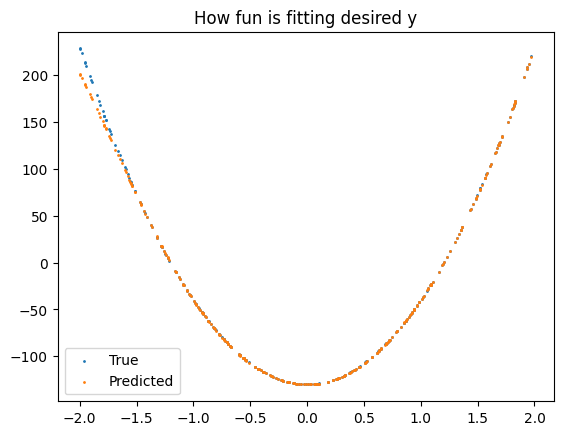

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.5290565619458043
Epoch: 251, Loss (standarized): 0.0007864356622115507
Epoch: 501, Loss (standarized): 0.00015772966013497485
Epoch: 751, Loss (standarized): 0.00011711976296948588
Epoch: 1001, Loss (standarized): 0.0001176043332462623
Epoch: 1251, Loss (standarized): 8.244238315162598e-05
Epoch: 1501, Loss (standarized): 0.00029397125812684875
Epoch: 1751, Loss (standarized): 3.831833678156114e-05
Epoch: 2001, Loss (standarized): 3.5484607437424505e-05
Epoch: 2251, Loss (standarized): 1.9260401408382738e-05
Epoch: 2501, Loss (standarized): 1.7368994596495055e-05
Epoch: 2751, Loss (standarized): 3.259377609007315e-05
Epoch: 3001, Loss (standarized): 1.140956147751432e-05
Epoch: 3251, Loss (standarized): 9.812309415594578e-06
Epoch: 3501, Loss (standarized): 7.922637645368172e-06
Epoch: 375

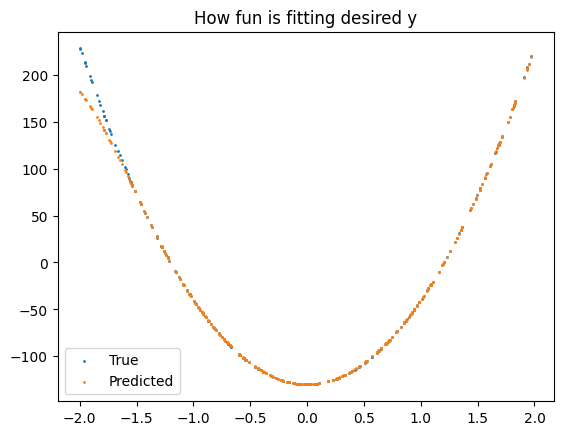

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.7731035202485184
Epoch: 251, Loss (standarized): 1.1741381301929805
Epoch: 501, Loss (standarized): 1.3609527669161372
Epoch: 751, Loss (standarized): 1.385536919978015
Epoch: 1001, Loss (standarized): 1.147389047662354
Epoch: 1251, Loss (standarized): 1.1710039782404613
Epoch: 1501, Loss (standarized): 1.0833094040748448
Epoch: 1751, Loss (standarized): 1.0303776078145608
Epoch: 2001, Loss (standarized): 1.1324476299745605
Epoch: 2251, Loss (standarized): 1.0786797262969015
Epoch: 2501, Loss (standarized): 1.019205133835986
Epoch: 2751, Loss (standarized): 1.4443920952008782
Epoch: 3001, Loss (standarized): 1.7235176993964891
Epoch: 3251, Loss (standarized): 1.2009668441342063
Epoch: 3501, Loss (standarized): 2.0047716347551137
Epoch: 3751, Loss (standarized): 1.0950966080458793
Epoch: 40

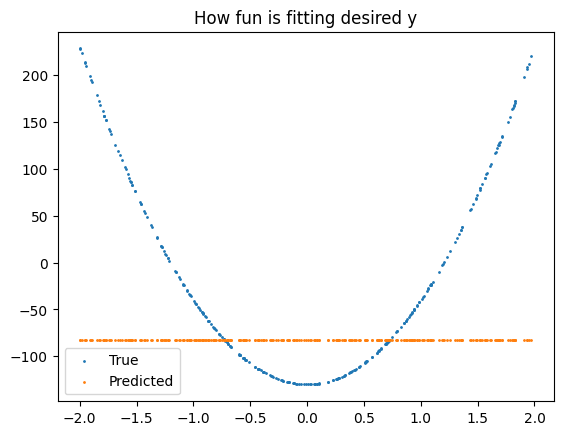

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.284860997115136
Epoch: 251, Loss (standarized): 0.00022593972864395808
Epoch: 501, Loss (standarized): 0.00011110929223424484
Epoch: 751, Loss (standarized): 5.488286798640311e-05
Epoch: 1001, Loss (standarized): 2.844698146918773e-05
Epoch: 1251, Loss (standarized): 1.6804325565058728e-05
Epoch: 1501, Loss (standarized): 1.0864420407425921e-05
Epoch: 1751, Loss (standarized): 8.055788767364317e-06
Epoch: 2001, Loss (standarized): 6.7657308297592196e-06
Epoch: 2251, Loss (standarized): 6.7700497299034825e-06
Epoch: 2501, Loss (standarized): 5.81515104227481e-06
Epoch: 2751, Loss (standarized): 5.790292838511002e-06
Epoch: 3001, Loss (standarized): 5.244793579848079e-06
Epoch: 3251, Loss (standarized): 5.027140538914448e-06
Epoch: 3501, Loss (standarized): 5.0449393531638514e-06
Epoch: 3751

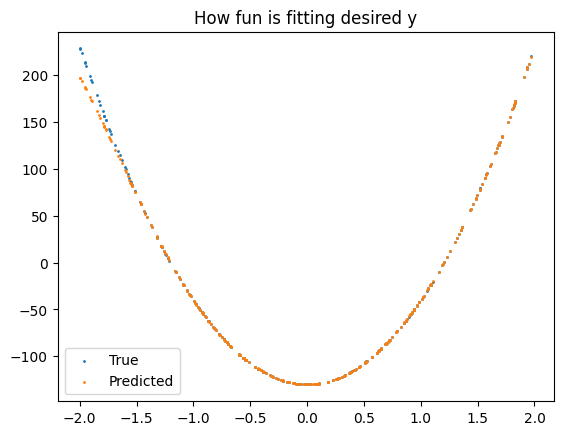

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.7457713623516082
Epoch: 251, Loss (standarized): 0.00020775660107486547
Epoch: 501, Loss (standarized): 0.00010977007672375655
Epoch: 751, Loss (standarized): 6.586976460361679e-05
Epoch: 1001, Loss (standarized): 5.719788440004864e-05
Epoch: 1251, Loss (standarized): 4.533263675615528e-05
Epoch: 1501, Loss (standarized): 3.146055464787157e-05
Epoch: 1751, Loss (standarized): 2.7286124161400883e-05
Epoch: 2001, Loss (standarized): 2.6069618373067436e-05
Epoch: 2251, Loss (standarized): 2.1724539424866175e-05
Epoch: 2501, Loss (standarized): 1.8177215070185056e-05
Epoch: 2751, Loss (standarized): 1.8121235121321106e-05
Epoch: 3001, Loss (standarized): 1.5187660671049592e-05
Epoch: 3251, Loss (standarized): 1.2348483609765257e-05
Epoch: 3501, Loss (standarized): 1.2066786131883146e-05
Epoch

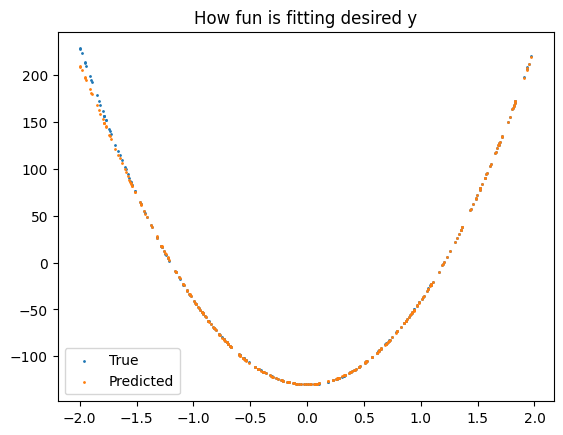

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.180709265260739
Epoch: 251, Loss (standarized): 0.28467986790168087
Epoch: 501, Loss (standarized): 0.2847132791860774
Epoch: 751, Loss (standarized): 0.3075760023784668
Epoch: 1001, Loss (standarized): 0.2891101425543563
Epoch: 1251, Loss (standarized): 0.3008729678162955
Epoch: 1501, Loss (standarized): 0.3173703196253534
Epoch: 1751, Loss (standarized): 0.0004253337640338565
Epoch: 2001, Loss (standarized): 0.001990729915795716
Epoch: 2251, Loss (standarized): 0.000818902665981873
Epoch: 2501, Loss (standarized): 0.0005872268280659261
Epoch: 2751, Loss (standarized): 0.0026453402208048934
Epoch: 3001, Loss (standarized): 0.0020517317963973424
Epoch: 3251, Loss (standarized): 0.0004802519541498852
Epoch: 3501, Loss (standarized): 0.0006191968184889108
Epoch: 3751, Loss (standarized): 0.

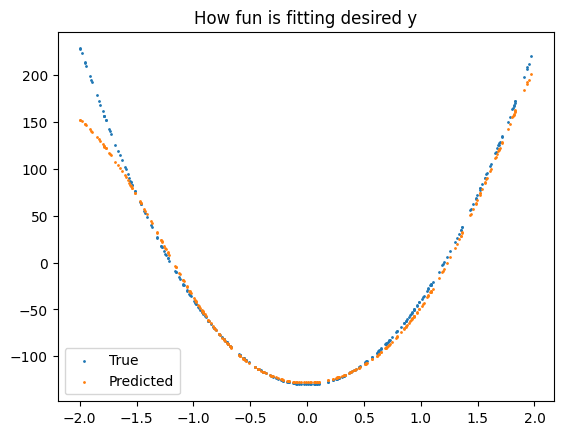

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.3718213771222607
Epoch: 251, Loss (standarized): 0.0002872924858413329
Epoch: 501, Loss (standarized): 0.00021034353729212585
Epoch: 751, Loss (standarized): 0.00016039553582092108
Epoch: 1001, Loss (standarized): 0.00013225233948660335
Epoch: 1251, Loss (standarized): 0.00010799458602815552
Epoch: 1501, Loss (standarized): 9.075217537938628e-05
Epoch: 1751, Loss (standarized): 7.308164090546286e-05
Epoch: 2001, Loss (standarized): 5.991116343528975e-05
Epoch: 2251, Loss (standarized): 5.0796633594466734e-05
Epoch: 2501, Loss (standarized): 3.859544811707475e-05
Epoch: 2751, Loss (standarized): 3.182835257225707e-05
Epoch: 3001, Loss (standarized): 2.668419434197052e-05
Epoch: 3251, Loss (standarized): 2.0283678140679437e-05
Epoch: 3501, Loss (standarized): 1.6321192932126603e-05
Epoch: 37

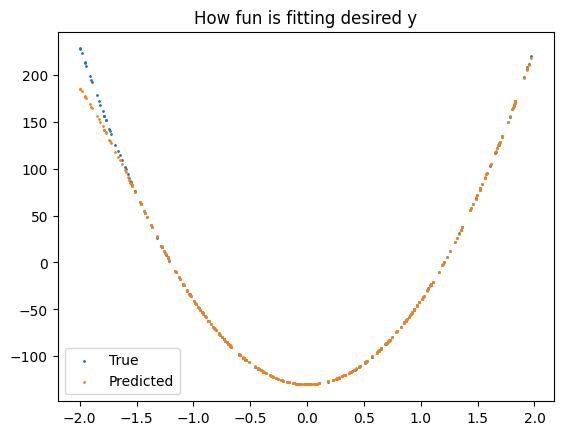

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.8985480081169022
Epoch: 251, Loss (standarized): 0.0003866275197218502
Epoch: 501, Loss (standarized): 0.00025565370578412824
Epoch: 751, Loss (standarized): 0.00018690216577873844
Epoch: 1001, Loss (standarized): 0.00014187758876057328
Epoch: 1251, Loss (standarized): 0.00010811465466065142
Epoch: 1501, Loss (standarized): 7.937739945117985e-05
Epoch: 1751, Loss (standarized): 6.224303139980182e-05
Epoch: 2001, Loss (standarized): 4.52727572201792e-05
Epoch: 2251, Loss (standarized): 3.257580622585123e-05
Epoch: 2501, Loss (standarized): 2.26062227754529e-05
Epoch: 2751, Loss (standarized): 1.572546418780132e-05
Epoch: 3001, Loss (standarized): 1.2551162219794183e-05
Epoch: 3251, Loss (standarized): 8.525141776233717e-06
Epoch: 3501, Loss (standarized): 6.6648670393516e-06
Epoch: 3751, L

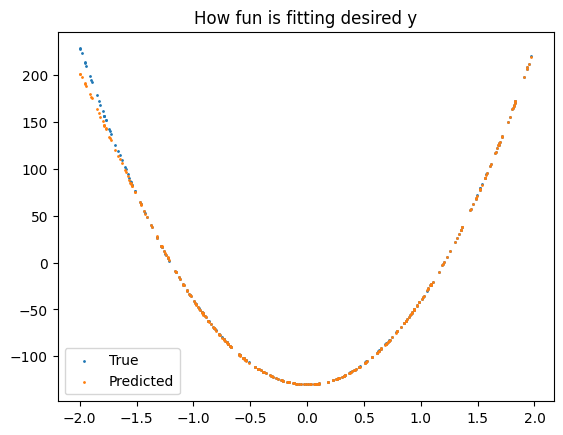

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 5.258001356904446
Epoch: 251, Loss (standarized): 1.0854490066348987
Epoch: 501, Loss (standarized): 1.04624399857796
Epoch: 751, Loss (standarized): 1.0279840876507262
Epoch: 1001, Loss (standarized): 1.091070224471121
Epoch: 1251, Loss (standarized): 1.0303252637853009
Epoch: 1501, Loss (standarized): 0.28501654753960687
Epoch: 1751, Loss (standarized): 0.28165147326794
Epoch: 2001, Loss (standarized): 0.28142937137396007
Epoch: 2251, Loss (standarized): 0.27644083344705705
Epoch: 2501, Loss (standarized): 0.2851796431192669
Epoch: 2751, Loss (standarized): 0.2804430315197557
Epoch: 3001, Loss (standarized): 0.2800977359046101
Epoch: 3251, Loss (standarized): 0.3275071850679235
Epoch: 3501, Loss (standarized): 0.2840262841430998
Epoch: 3751, Loss (standarized): 0.28130248543056413
Epoch: 

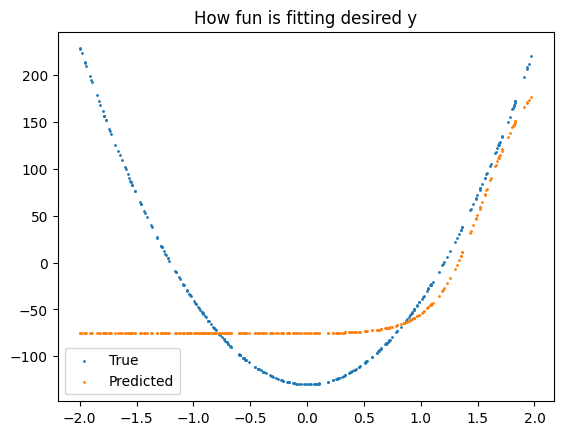

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.7388137044599423
Epoch: 251, Loss (standarized): 0.0006498520860926862
Epoch: 501, Loss (standarized): 0.00047443690899149515
Epoch: 751, Loss (standarized): 0.0003636074309377822
Epoch: 1001, Loss (standarized): 0.00027568412235061136
Epoch: 1251, Loss (standarized): 0.00020911748992104791
Epoch: 1501, Loss (standarized): 0.00015986701385702133
Epoch: 1751, Loss (standarized): 0.00012439000508738198
Epoch: 2001, Loss (standarized): 9.366774645533152e-05
Epoch: 2251, Loss (standarized): 7.195978972491348e-05
Epoch: 2501, Loss (standarized): 5.5507109711673214e-05
Epoch: 2751, Loss (standarized): 4.4470849420453964e-05
Epoch: 3001, Loss (standarized): 3.502431743084416e-05
Epoch: 3251, Loss (standarized): 2.8090706211994794e-05
Epoch: 3501, Loss (standarized): 2.4270684406662684e-05
Epoch: 

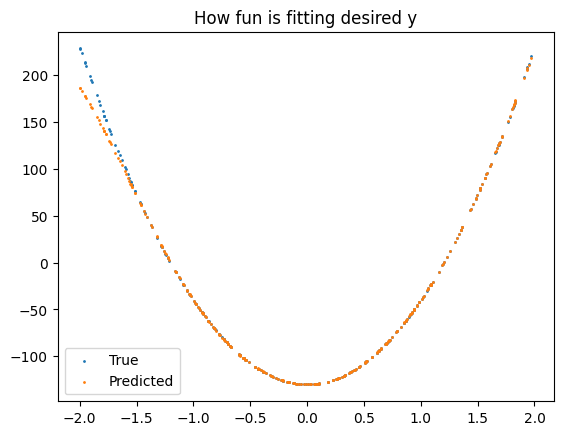

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.974960108958074
Epoch: 251, Loss (standarized): 0.00020035134708921946
Epoch: 501, Loss (standarized): 0.00012915559614662547
Epoch: 751, Loss (standarized): 8.997829171823716e-05
Epoch: 1001, Loss (standarized): 6.793645583971158e-05
Epoch: 1251, Loss (standarized): 5.143323447880871e-05
Epoch: 1501, Loss (standarized): 4.1231609032843734e-05
Epoch: 1751, Loss (standarized): 3.200953812008736e-05
Epoch: 2001, Loss (standarized): 2.6516502955991388e-05
Epoch: 2251, Loss (standarized): 2.2031328897218108e-05
Epoch: 2501, Loss (standarized): 1.7699670514872122e-05
Epoch: 2751, Loss (standarized): 1.4590130904568814e-05
Epoch: 3001, Loss (standarized): 1.1792304405291133e-05
Epoch: 3251, Loss (standarized): 1.001267567980854e-05
Epoch: 3501, Loss (standarized): 8.225276239954752e-06
Epoch: 3

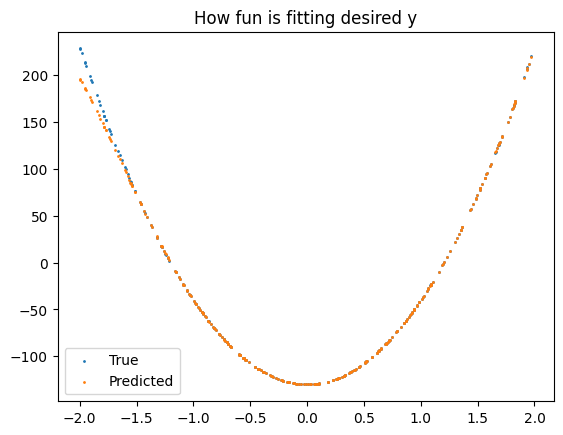

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.489945751618698
Epoch: 251, Loss (standarized): 0.00013506374773794086
Epoch: 501, Loss (standarized): 6.913440211101242e-05
Epoch: 751, Loss (standarized): 4.3205380995036366e-05
Epoch: 1001, Loss (standarized): 3.2174138358100354e-05
Epoch: 1251, Loss (standarized): 2.5222828738885297e-05
Epoch: 1501, Loss (standarized): 2.0736385690254243e-05
Epoch: 1751, Loss (standarized): 1.866438161941417e-05
Epoch: 2001, Loss (standarized): 1.5507937703718122e-05
Epoch: 2251, Loss (standarized): 1.5696251292657568e-05
Epoch: 2501, Loss (standarized): 1.352527122821961e-05
Epoch: 2751, Loss (standarized): 1.1980747613264502e-05
Epoch: 3001, Loss (standarized): 1.156425248833147e-05
Epoch: 3251, Loss (standarized): 1.06446712134822e-05
Epoch: 3501, Loss (standarized): 9.389373558872572e-06
Epoch: 37

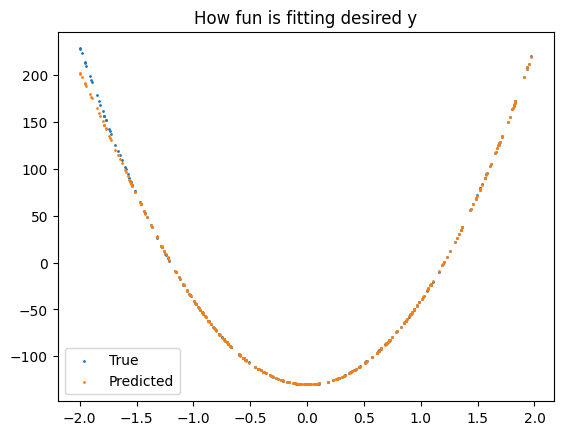

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.5446537034701604
Epoch: 251, Loss (standarized): 0.0010249136154211168
Epoch: 501, Loss (standarized): 0.00037216816992869615
Epoch: 751, Loss (standarized): 0.00027876522582699707
Epoch: 1001, Loss (standarized): 0.0002286673143574118
Epoch: 1251, Loss (standarized): 0.00018206344750437676
Epoch: 1501, Loss (standarized): 0.0001547661072081956
Epoch: 1751, Loss (standarized): 0.00013295577814960094
Epoch: 2001, Loss (standarized): 0.0001163968756201431
Epoch: 2251, Loss (standarized): 0.00010195751260317326
Epoch: 2501, Loss (standarized): 9.015900589087236e-05
Epoch: 2751, Loss (standarized): 8.087310929628954e-05
Epoch: 3001, Loss (standarized): 7.280274163461315e-05
Epoch: 3251, Loss (standarized): 6.570807170028079e-05
Epoch: 3501, Loss (standarized): 5.935728381044735e-05
Epoch: 375

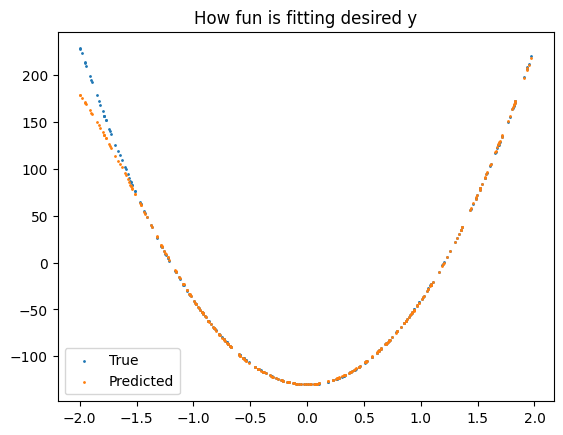

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.973903303171001
Epoch: 251, Loss (standarized): 0.0004964545241874294
Epoch: 501, Loss (standarized): 0.0003820003372628471
Epoch: 751, Loss (standarized): 0.0003161490780269839
Epoch: 1001, Loss (standarized): 0.00027278608432765344
Epoch: 1251, Loss (standarized): 0.0002319729752983584
Epoch: 1501, Loss (standarized): 0.00020144944758886894
Epoch: 1751, Loss (standarized): 0.00017496570774205316
Epoch: 2001, Loss (standarized): 0.0001543842357128727
Epoch: 2251, Loss (standarized): 0.000131508528435807
Epoch: 2501, Loss (standarized): 0.00011702768464138184
Epoch: 2751, Loss (standarized): 9.743279047153691e-05
Epoch: 3001, Loss (standarized): 8.435900189040427e-05
Epoch: 3251, Loss (standarized): 7.30651360079756e-05
Epoch: 3501, Loss (standarized): 6.0206702174835576e-05
Epoch: 3751,

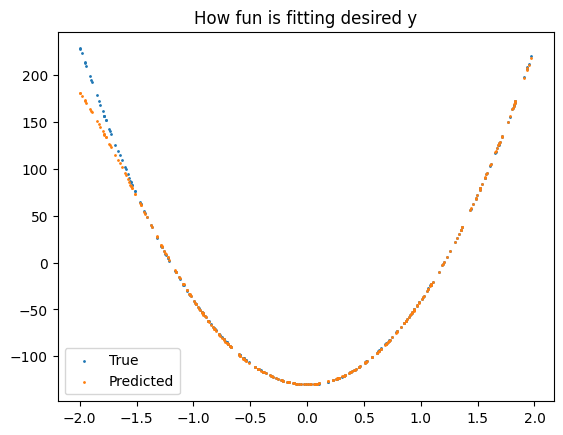

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.841625195532176
Epoch: 251, Loss (standarized): 0.0002741349102679545
Epoch: 501, Loss (standarized): 0.00017643241694901874
Epoch: 751, Loss (standarized): 0.00011879508306817581
Epoch: 1001, Loss (standarized): 8.967748110109123e-05
Epoch: 1251, Loss (standarized): 6.94063449985864e-05
Epoch: 1501, Loss (standarized): 5.7684110901027665e-05
Epoch: 1751, Loss (standarized): 4.788297776910403e-05
Epoch: 2001, Loss (standarized): 3.952243511637475e-05
Epoch: 2251, Loss (standarized): 3.3085662402925425e-05
Epoch: 2501, Loss (standarized): 2.9633590662036235e-05
Epoch: 2751, Loss (standarized): 2.628260382405363e-05
Epoch: 3001, Loss (standarized): 2.3519475020823284e-05
Epoch: 3251, Loss (standarized): 2.1090289107371862e-05
Epoch: 3501, Loss (standarized): 1.989137080597881e-05
Epoch: 37

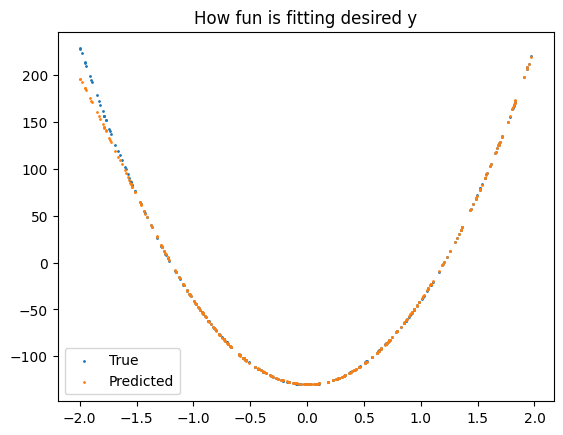

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.012446520108263
Epoch: 251, Loss (standarized): 0.00705113176288952
Epoch: 501, Loss (standarized): 0.0016105306763779938
Epoch: 751, Loss (standarized): 0.0010320602277398142
Epoch: 1001, Loss (standarized): 0.0009111676357208313
Epoch: 1251, Loss (standarized): 0.0008385007524762335
Epoch: 1501, Loss (standarized): 0.0007900009898543748
Epoch: 1751, Loss (standarized): 0.0007566790194974933
Epoch: 2001, Loss (standarized): 0.0007135854110068696
Epoch: 2251, Loss (standarized): 0.0006786322837379326
Epoch: 2501, Loss (standarized): 0.0006428207451290944
Epoch: 2751, Loss (standarized): 0.0006136554412185614
Epoch: 3001, Loss (standarized): 0.0005877649974304346
Epoch: 3251, Loss (standarized): 0.0005595384870725905
Epoch: 3501, Loss (standarized): 0.0005339419690907739
Epoch: 3751, Loss 

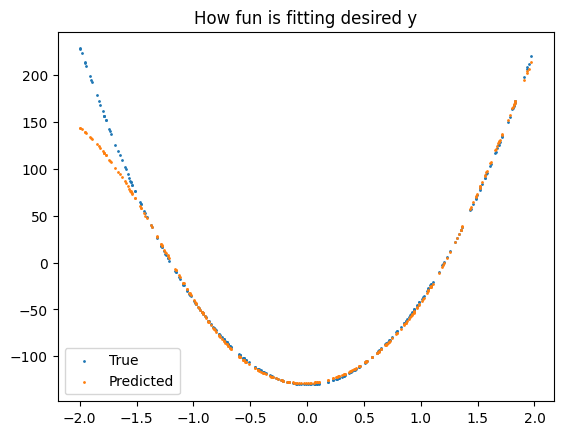

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.837795121561139
Epoch: 251, Loss (standarized): 0.0033733145816294214
Epoch: 501, Loss (standarized): 0.0007038562053062942
Epoch: 751, Loss (standarized): 0.00032567341683799073
Epoch: 1001, Loss (standarized): 0.0002490280943251969
Epoch: 1251, Loss (standarized): 0.00021835360080936378
Epoch: 1501, Loss (standarized): 0.00019833553764118486
Epoch: 1751, Loss (standarized): 0.00018265152149142704
Epoch: 2001, Loss (standarized): 0.0001720767279683119
Epoch: 2251, Loss (standarized): 0.0001589691695061141
Epoch: 2501, Loss (standarized): 0.00015101365441808244
Epoch: 2751, Loss (standarized): 0.0001417684450415254
Epoch: 3001, Loss (standarized): 0.00013536371199212568
Epoch: 3251, Loss (standarized): 0.0001289607222225233
Epoch: 3501, Loss (standarized): 0.00012377483815881094
Epoch: 3

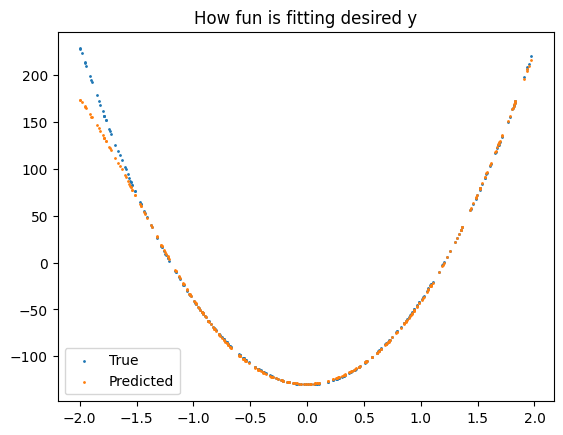

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.5994373109435065
Epoch: 251, Loss (standarized): 0.00048409155064060405
Epoch: 501, Loss (standarized): 0.000333148775337258
Epoch: 751, Loss (standarized): 0.00024954605994144277
Epoch: 1001, Loss (standarized): 0.00019980145769123316
Epoch: 1251, Loss (standarized): 0.000164049560163135
Epoch: 1501, Loss (standarized): 0.00013730924081276582
Epoch: 1751, Loss (standarized): 0.00011837509726791339
Epoch: 2001, Loss (standarized): 0.00010195517635358454
Epoch: 2251, Loss (standarized): 9.197093041439837e-05
Epoch: 2501, Loss (standarized): 8.189241803639872e-05
Epoch: 2751, Loss (standarized): 7.218537380973016e-05
Epoch: 3001, Loss (standarized): 6.546500019980976e-05
Epoch: 3251, Loss (standarized): 5.899233831666365e-05
Epoch: 3501, Loss (standarized): 5.510558801646462e-05
Epoch: 375

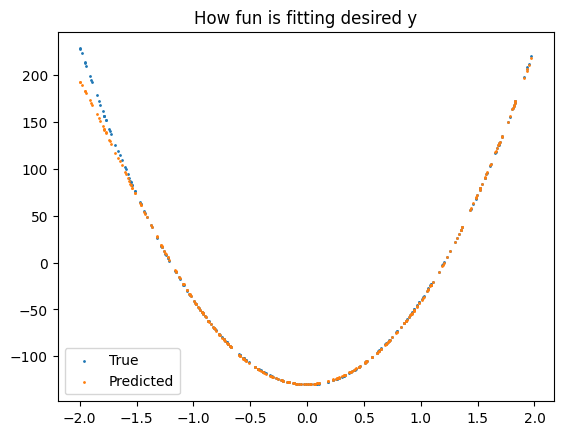

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.5517113292612104
Epoch: 251, Loss (standarized): 0.014642026139162477
Epoch: 501, Loss (standarized): 0.004679604885462658
Epoch: 751, Loss (standarized): 0.0022873731340268106
Epoch: 1001, Loss (standarized): 0.0013354911713483065
Epoch: 1251, Loss (standarized): 0.0008972255276540868
Epoch: 1501, Loss (standarized): 0.0006740100509807619
Epoch: 1751, Loss (standarized): 0.0005608332858212259
Epoch: 2001, Loss (standarized): 0.0004945945198419283
Epoch: 2251, Loss (standarized): 0.00045159876953991817
Epoch: 2501, Loss (standarized): 0.0004222380770086042
Epoch: 2751, Loss (standarized): 0.00040041177329118677
Epoch: 3001, Loss (standarized): 0.00038349046020823795
Epoch: 3251, Loss (standarized): 0.00036956611121101424
Epoch: 3501, Loss (standarized): 0.00035382980966592437
Epoch: 3751,

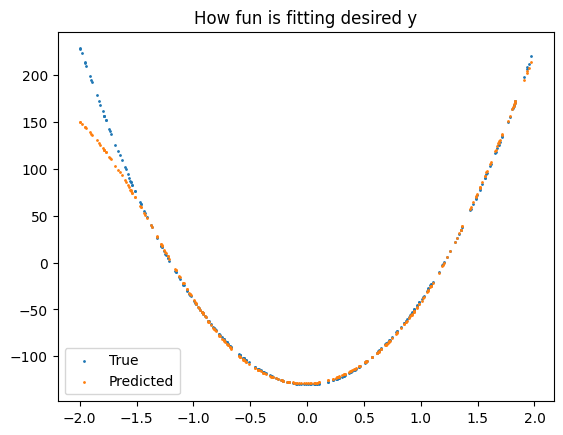

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.141784532517987
Epoch: 251, Loss (standarized): 0.008921947095964661
Epoch: 501, Loss (standarized): 0.001819785851692345
Epoch: 751, Loss (standarized): 0.0008566120851382803
Epoch: 1001, Loss (standarized): 0.000636409163499417
Epoch: 1251, Loss (standarized): 0.0005581859526405999
Epoch: 1501, Loss (standarized): 0.0005107927421944977
Epoch: 1751, Loss (standarized): 0.00046953209812051246
Epoch: 2001, Loss (standarized): 0.0004337406867190695
Epoch: 2251, Loss (standarized): 0.0004031471559047901
Epoch: 2501, Loss (standarized): 0.00037066688028960306
Epoch: 2751, Loss (standarized): 0.0003434225023061622
Epoch: 3001, Loss (standarized): 0.00031719833168819946
Epoch: 3251, Loss (standarized): 0.000293671770583812
Epoch: 3501, Loss (standarized): 0.00027055169515032137
Epoch: 3751, Lo

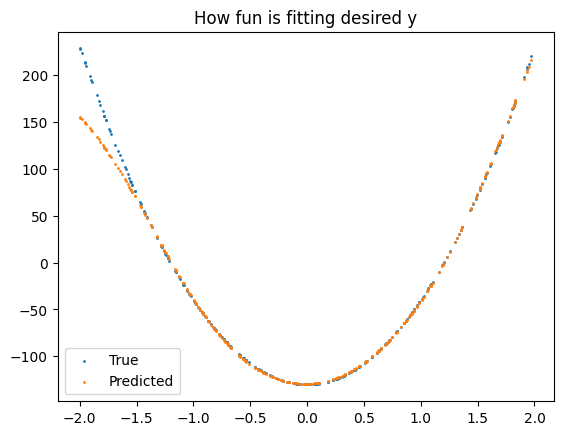

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 8.503878567012768
Epoch: 251, Loss (standarized): 0.0005148022904050238
Epoch: 501, Loss (standarized): 0.000373405366915714
Epoch: 751, Loss (standarized): 0.0003010479268846612
Epoch: 1001, Loss (standarized): 0.0002554707433462925
Epoch: 1251, Loss (standarized): 0.00022368624516550293
Epoch: 1501, Loss (standarized): 0.0001969974697918399
Epoch: 1751, Loss (standarized): 0.0001777026510380854
Epoch: 2001, Loss (standarized): 0.00015898661844850114
Epoch: 2251, Loss (standarized): 0.000143473781507889
Epoch: 2501, Loss (standarized): 0.00012992383907186453
Epoch: 2751, Loss (standarized): 0.00011624488649551349
Epoch: 3001, Loss (standarized): 0.00010337400580748895
Epoch: 3251, Loss (standarized): 9.191150028371724e-05
Epoch: 3501, Loss (standarized): 8.08447365268034e-05
Epoch: 3751, 

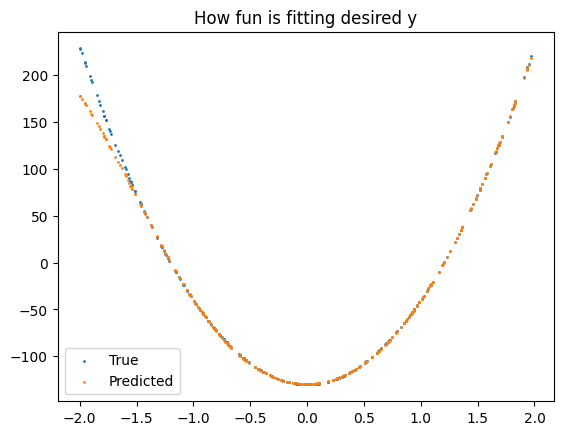

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.6078441384883002
Epoch: 251, Loss (standarized): 0.000573741961013823
Epoch: 501, Loss (standarized): 0.0005965585373739222
Epoch: 751, Loss (standarized): 0.00039289689125432
Epoch: 1001, Loss (standarized): 0.0007960425233993259
Epoch: 1251, Loss (standarized): 0.0003241182465652066
Epoch: 1501, Loss (standarized): 0.00019966423250268733
Epoch: 1751, Loss (standarized): 0.00012676529859145816
Epoch: 2001, Loss (standarized): 0.0001757444744137718
Epoch: 2251, Loss (standarized): 0.00012205818173411692
Epoch: 2501, Loss (standarized): 0.0001249566857210522
Epoch: 2751, Loss (standarized): 0.00027204369710029277
Epoch: 3001, Loss (standarized): 0.00017832483674923755
Epoch: 3251, Loss (standarized): 0.00010557559388305114
Epoch: 3501, Loss (standarized): 9.815005316287292e-05
Epoch: 3751, L

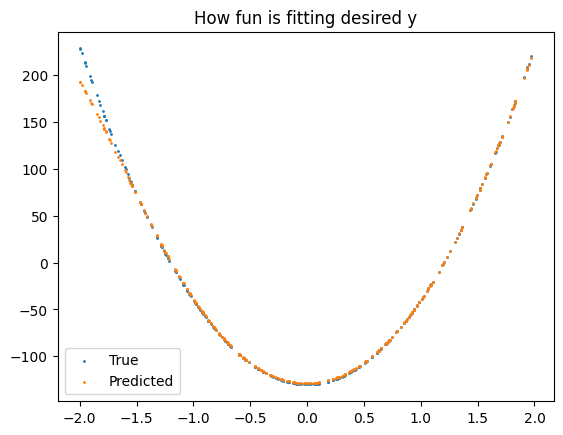

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.4249452235688187
Epoch: 251, Loss (standarized): 0.00010391281391124505
Epoch: 501, Loss (standarized): 4.871251309678796e-05
Epoch: 751, Loss (standarized): 2.9148987442899223e-05
Epoch: 1001, Loss (standarized): 3.8188625617474615e-05
Epoch: 1251, Loss (standarized): 1.6713842252454156e-05
Epoch: 1501, Loss (standarized): 1.9092639231840508e-05
Epoch: 1751, Loss (standarized): 2.2520248845923598e-05
Epoch: 2001, Loss (standarized): 1.235079435783739e-05
Epoch: 2251, Loss (standarized): 2.202698519754262e-05
Epoch: 2501, Loss (standarized): 1.3490592944703292e-05
Epoch: 2751, Loss (standarized): 2.567364877114423e-05
Epoch: 3001, Loss (standarized): 1.3654057382022372e-05
Epoch: 3251, Loss (standarized): 1.9979696003118728e-05
Epoch: 3501, Loss (standarized): 1.0343270537838165e-05
Epoch:

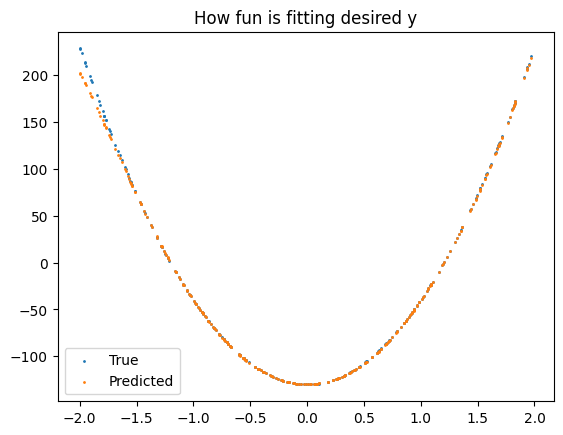

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.7124108945726983
Epoch: 251, Loss (standarized): 1.4272594878044391
Epoch: 501, Loss (standarized): 1.2054073781618817
Epoch: 751, Loss (standarized): 1.2869630963921197
Epoch: 1001, Loss (standarized): 1.0412112581495527
Epoch: 1251, Loss (standarized): 1.0685372993705242
Epoch: 1501, Loss (standarized): 1.1733135941724337
Epoch: 1751, Loss (standarized): 1.2938302574379703
Epoch: 2001, Loss (standarized): 1.0867291604909464
Epoch: 2251, Loss (standarized): 1.6816316537610068
Epoch: 2501, Loss (standarized): 1.0705165704362465
Epoch: 2751, Loss (standarized): 1.2413082073375863
Epoch: 3001, Loss (standarized): 1.1212362571555596
Epoch: 3251, Loss (standarized): 1.2520668743857188
Epoch: 3501, Loss (standarized): 1.2595498465231914
Epoch: 3751, Loss (standarized): 1.2550080280973628
Epoch:

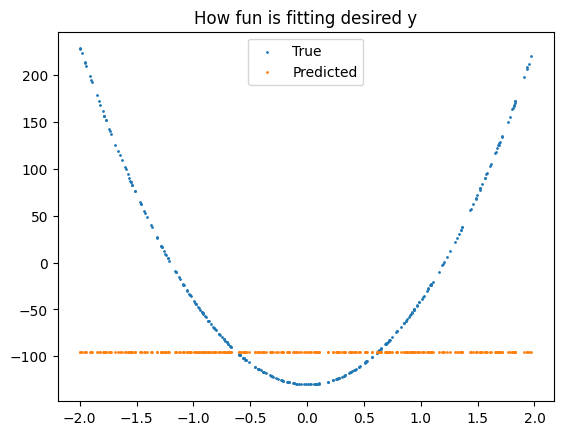

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.7890087420346783
Epoch: 251, Loss (standarized): 0.2615676906686211
Epoch: 501, Loss (standarized): 0.0005688394364628753
Epoch: 751, Loss (standarized): 0.0003709724120188389
Epoch: 1001, Loss (standarized): 0.0002344813639105787
Epoch: 1251, Loss (standarized): 0.00022629408704960777
Epoch: 1501, Loss (standarized): 0.00016403306089585802
Epoch: 1751, Loss (standarized): 0.00016971745625252505
Epoch: 2001, Loss (standarized): 0.00020313504743192074
Epoch: 2251, Loss (standarized): 0.0001469293862711591
Epoch: 2501, Loss (standarized): 0.00013503707022329367
Epoch: 2751, Loss (standarized): 9.465250795073433e-05
Epoch: 3001, Loss (standarized): 0.00010796154672978726
Epoch: 3251, Loss (standarized): 0.00017589805293327619
Epoch: 3501, Loss (standarized): 0.00010015280612240497
Epoch: 3751

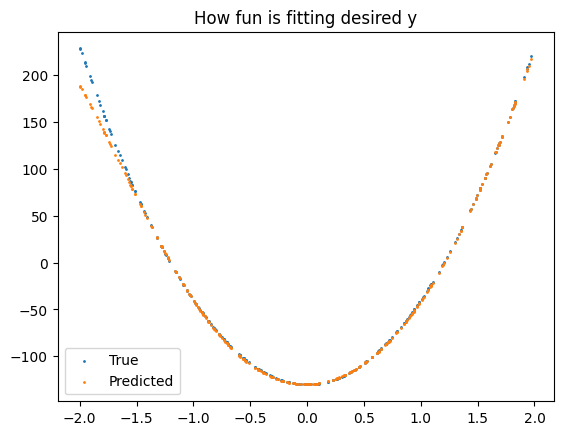

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.3817382055561558
Epoch: 251, Loss (standarized): 0.0004701554601735927
Epoch: 501, Loss (standarized): 0.0002442376125125904
Epoch: 751, Loss (standarized): 0.00019366459140080262
Epoch: 1001, Loss (standarized): 0.00020375850600915036
Epoch: 1251, Loss (standarized): 0.00035196807481081274
Epoch: 1501, Loss (standarized): 0.0003423536084861096
Epoch: 1751, Loss (standarized): 9.427915059217235e-05
Epoch: 2001, Loss (standarized): 0.0001677971148223226
Epoch: 2251, Loss (standarized): 0.00013225340092520946
Epoch: 2501, Loss (standarized): 5.759603622244039e-05
Epoch: 2751, Loss (standarized): 6.324145571581488e-05
Epoch: 3001, Loss (standarized): 5.14771965900762e-05
Epoch: 3251, Loss (standarized): 4.5309419503154236e-05
Epoch: 3501, Loss (standarized): 1.9497778655798097e-05
Epoch: 375

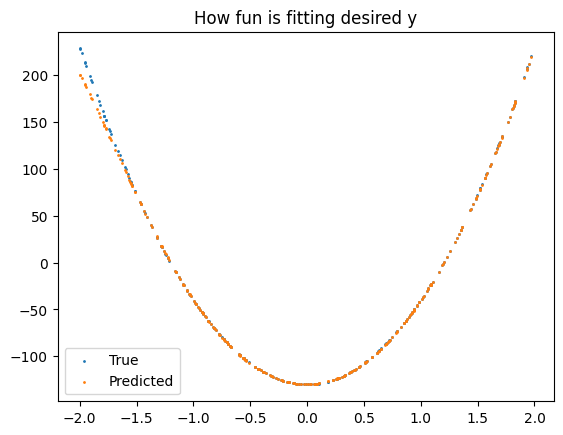

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.9028919586898936
Epoch: 251, Loss (standarized): 1.2520583621552768
Epoch: 501, Loss (standarized): 1.094618521127437
Epoch: 751, Loss (standarized): 1.0506885482050548
Epoch: 1001, Loss (standarized): 1.038359646335827
Epoch: 1251, Loss (standarized): 1.1028330013016592
Epoch: 1501, Loss (standarized): 1.0175384258205828
Epoch: 1751, Loss (standarized): 1.2356031132251126
Epoch: 2001, Loss (standarized): 1.252303746666998
Epoch: 2251, Loss (standarized): 1.009011514717992
Epoch: 2501, Loss (standarized): 1.3609642855487036
Epoch: 2751, Loss (standarized): 1.0824097843797897
Epoch: 3001, Loss (standarized): 1.1530836706867111
Epoch: 3251, Loss (standarized): 1.105383816740175
Epoch: 3501, Loss (standarized): 1.1647202008459854
Epoch: 3751, Loss (standarized): 1.2120857124864919
Epoch: 400

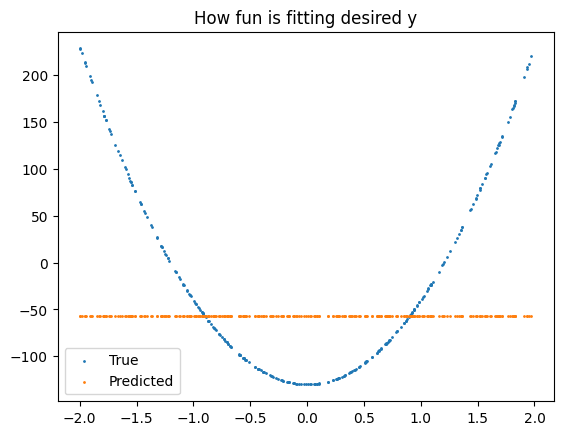

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.4976870131234599
Epoch: 251, Loss (standarized): 0.0005815232743396598
Epoch: 501, Loss (standarized): 0.0003842921750123215
Epoch: 751, Loss (standarized): 0.0003078888106289516
Epoch: 1001, Loss (standarized): 0.0002453361386930112
Epoch: 1251, Loss (standarized): 0.00019737622717581213
Epoch: 1501, Loss (standarized): 0.00018597211415371438
Epoch: 1751, Loss (standarized): 0.0001646765363453639
Epoch: 2001, Loss (standarized): 0.00013767389414964598
Epoch: 2251, Loss (standarized): 0.0001416168345092388
Epoch: 2501, Loss (standarized): 0.00013203237753901985
Epoch: 2751, Loss (standarized): 0.00011618618063732604
Epoch: 3001, Loss (standarized): 0.00010618616880990704
Epoch: 3251, Loss (standarized): 9.989292182628382e-05
Epoch: 3501, Loss (standarized): 8.933668265679307e-05
Epoch: 375

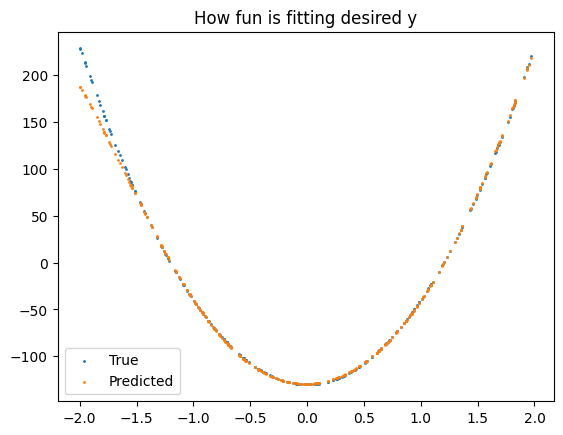

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.6174903779566292
Epoch: 251, Loss (standarized): 0.0004116171525381276
Epoch: 501, Loss (standarized): 0.00029795720614748857
Epoch: 751, Loss (standarized): 0.00017663430715325493
Epoch: 1001, Loss (standarized): 0.00018916184881903158
Epoch: 1251, Loss (standarized): 0.00016871620218075935
Epoch: 1501, Loss (standarized): 0.00013975006503003833
Epoch: 1751, Loss (standarized): 0.00010882789375545763
Epoch: 2001, Loss (standarized): 9.066865307463642e-05
Epoch: 2251, Loss (standarized): 0.00010865499011452515
Epoch: 2501, Loss (standarized): 8.57995353492509e-05
Epoch: 2751, Loss (standarized): 7.291922653229619e-05
Epoch: 3001, Loss (standarized): 7.00185534443006e-05
Epoch: 3251, Loss (standarized): 8.22017466812424e-05
Epoch: 3501, Loss (standarized): 6.504022768656716e-05
Epoch: 3751

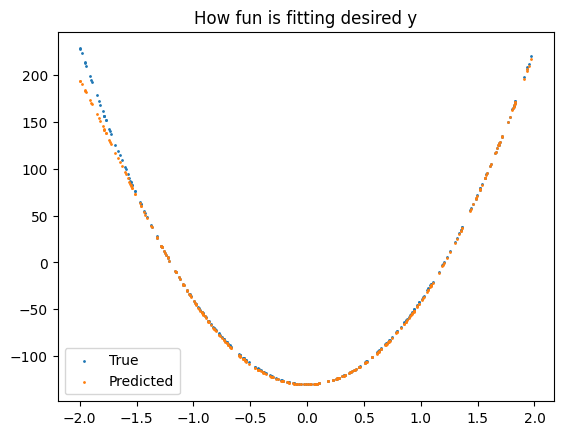

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.092783770853349
Epoch: 251, Loss (standarized): 0.286050587748186
Epoch: 501, Loss (standarized): 0.29734069517859807
Epoch: 751, Loss (standarized): 0.2985701950549296
Epoch: 1001, Loss (standarized): 0.29247348400658396
Epoch: 1251, Loss (standarized): 0.28672691417238344
Epoch: 1501, Loss (standarized): 0.2912228852577878
Epoch: 1751, Loss (standarized): 0.28880961843499814
Epoch: 2001, Loss (standarized): 0.2790351666404479
Epoch: 2251, Loss (standarized): 0.27879448819706476
Epoch: 2501, Loss (standarized): 0.3093211847842921
Epoch: 2751, Loss (standarized): 0.36810205946769164
Epoch: 3001, Loss (standarized): 0.3034000347929192
Epoch: 3251, Loss (standarized): 0.2787989821711168
Epoch: 3501, Loss (standarized): 0.26763073045728925
Epoch: 3751, Loss (standarized): 0.416925951956349
E

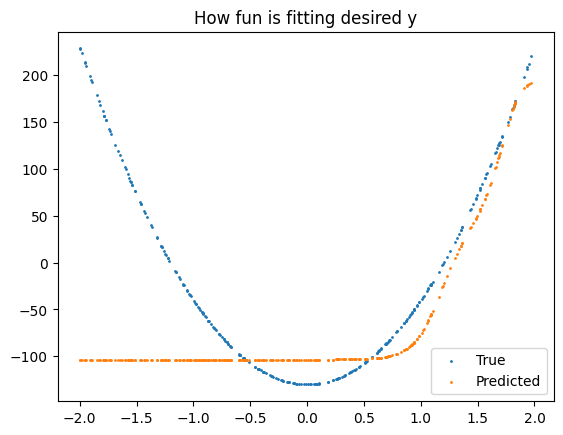

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.407345548225265
Epoch: 251, Loss (standarized): 0.0011902387583135896
Epoch: 501, Loss (standarized): 0.0006984528302610758
Epoch: 751, Loss (standarized): 0.0005408759148358936
Epoch: 1001, Loss (standarized): 0.0004354625830991871
Epoch: 1251, Loss (standarized): 0.0003631368361417134
Epoch: 1501, Loss (standarized): 0.0003230834005542286
Epoch: 1751, Loss (standarized): 0.0002911361075239103
Epoch: 2001, Loss (standarized): 0.0002489610310170679
Epoch: 2251, Loss (standarized): 0.00023069055478521175
Epoch: 2501, Loss (standarized): 0.00021692301000851742
Epoch: 2751, Loss (standarized): 0.00020761634400853434
Epoch: 3001, Loss (standarized): 0.0001902662475240359
Epoch: 3251, Loss (standarized): 0.00017986628301952154
Epoch: 3501, Loss (standarized): 0.00017177571824049013
Epoch: 3751,

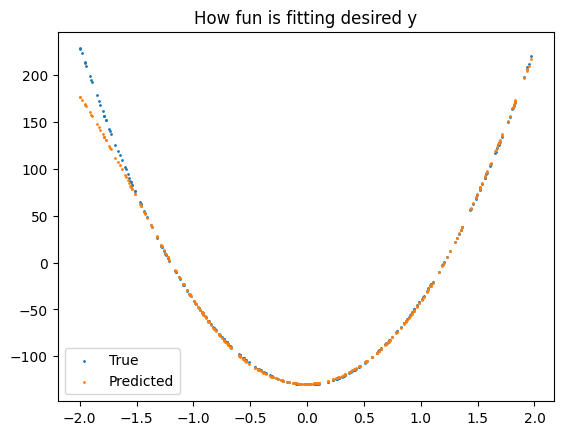

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.8603346207037939
Epoch: 251, Loss (standarized): 0.0005807138992202289
Epoch: 501, Loss (standarized): 0.000438678364405004
Epoch: 751, Loss (standarized): 0.0002953301679016009
Epoch: 1001, Loss (standarized): 0.0002794727953482698
Epoch: 1251, Loss (standarized): 0.00021013614541572645
Epoch: 1501, Loss (standarized): 0.00017755990922972565
Epoch: 1751, Loss (standarized): 0.00016513339041086686
Epoch: 2001, Loss (standarized): 0.00017093288753193745
Epoch: 2251, Loss (standarized): 0.00013592639566321722
Epoch: 2501, Loss (standarized): 0.00013408151016367848
Epoch: 2751, Loss (standarized): 0.00011652997795283782
Epoch: 3001, Loss (standarized): 0.00010467615242092949
Epoch: 3251, Loss (standarized): 0.00010699085045001596
Epoch: 3501, Loss (standarized): 0.00010793326184578636
Epoch:

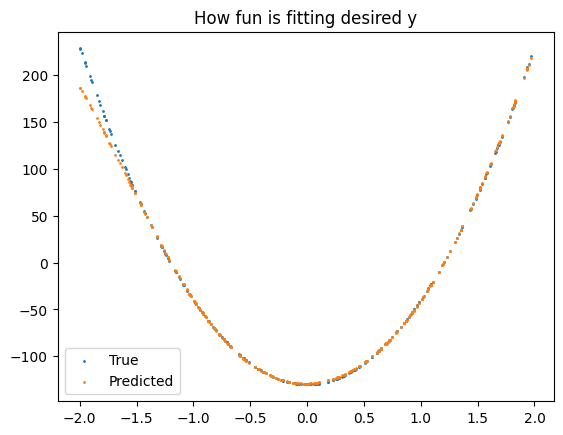

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.203183742118318
Epoch: 251, Loss (standarized): 0.31124725708225864
Epoch: 501, Loss (standarized): 0.2660977266555433
Epoch: 751, Loss (standarized): 0.28639948246612396
Epoch: 1001, Loss (standarized): 0.2633526156879028
Epoch: 1251, Loss (standarized): 0.2813297311758335
Epoch: 1501, Loss (standarized): 0.27237088833301165
Epoch: 1751, Loss (standarized): 0.2684295727810413
Epoch: 2001, Loss (standarized): 0.2809376066640903
Epoch: 2251, Loss (standarized): 0.26764876161454704
Epoch: 2501, Loss (standarized): 0.26984002697134124
Epoch: 2751, Loss (standarized): 0.2787493031109002
Epoch: 3001, Loss (standarized): 0.2917088990682279
Epoch: 3251, Loss (standarized): 0.286491750997027
Epoch: 3501, Loss (standarized): 0.3001370766273103
Epoch: 3751, Loss (standarized): 0.31228354028735017
E

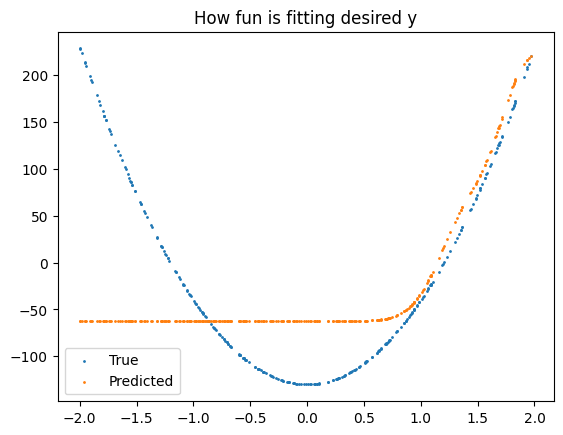

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.2266081892725356
Epoch: 251, Loss (standarized): 0.0015782384173089127
Epoch: 501, Loss (standarized): 0.0008565754227777711
Epoch: 751, Loss (standarized): 0.0006488638170489299
Epoch: 1001, Loss (standarized): 0.0005431708569180084
Epoch: 1251, Loss (standarized): 0.00047459571724407226
Epoch: 1501, Loss (standarized): 0.00043378524970834
Epoch: 1751, Loss (standarized): 0.0004025298889161164
Epoch: 2001, Loss (standarized): 0.0003639376443420111
Epoch: 2251, Loss (standarized): 0.00034012205023982044
Epoch: 2501, Loss (standarized): 0.00031541291129414973
Epoch: 2751, Loss (standarized): 0.0002921690626282814
Epoch: 3001, Loss (standarized): 0.00027399288310534544
Epoch: 3251, Loss (standarized): 0.0002592075728670174
Epoch: 3501, Loss (standarized): 0.00025158173909467643
Epoch: 3751,

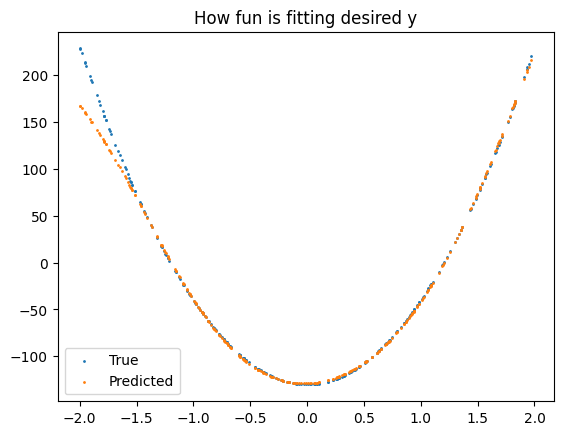

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.55430566241532
Epoch: 251, Loss (standarized): 0.2723741672958018
Epoch: 501, Loss (standarized): 0.2686413686388541
Epoch: 751, Loss (standarized): 0.26591344692791913
Epoch: 1001, Loss (standarized): 0.26414907863338766
Epoch: 1251, Loss (standarized): 0.2647142502102195
Epoch: 1501, Loss (standarized): 0.2636134517094369
Epoch: 1751, Loss (standarized): 0.2632925247019363
Epoch: 2001, Loss (standarized): 0.2639228177557404
Epoch: 2251, Loss (standarized): 0.26444372862177334
Epoch: 2501, Loss (standarized): 0.2632970223060224
Epoch: 2751, Loss (standarized): 0.26387758265087297
Epoch: 3001, Loss (standarized): 0.2632923221937007
Epoch: 3251, Loss (standarized): 0.26277456537265526
Epoch: 3501, Loss (standarized): 0.2625077351309962
Epoch: 3751, Loss (standarized): 0.2629462764029529
E

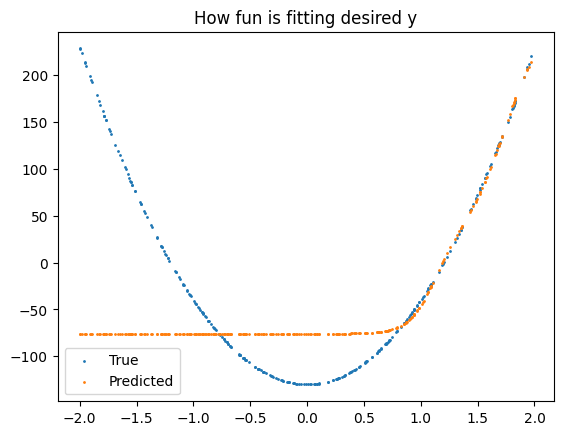

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.822938169024212
Epoch: 251, Loss (standarized): 0.2723602823372649
Epoch: 501, Loss (standarized): 0.2675370980020848
Epoch: 751, Loss (standarized): 0.26881528280985223
Epoch: 1001, Loss (standarized): 0.267684285373559
Epoch: 1251, Loss (standarized): 0.2673508233148941
Epoch: 1501, Loss (standarized): 0.26867074136209035
Epoch: 1751, Loss (standarized): 0.26343348248771337
Epoch: 2001, Loss (standarized): 0.000959962987832529
Epoch: 2251, Loss (standarized): 0.000520932723492525
Epoch: 2501, Loss (standarized): 0.0002985269750605871
Epoch: 2751, Loss (standarized): 0.00022986235536487536
Epoch: 3001, Loss (standarized): 0.00024696366730682004
Epoch: 3251, Loss (standarized): 0.00019340009720037854
Epoch: 3501, Loss (standarized): 0.00021073862622241987
Epoch: 3751, Loss (standarized):

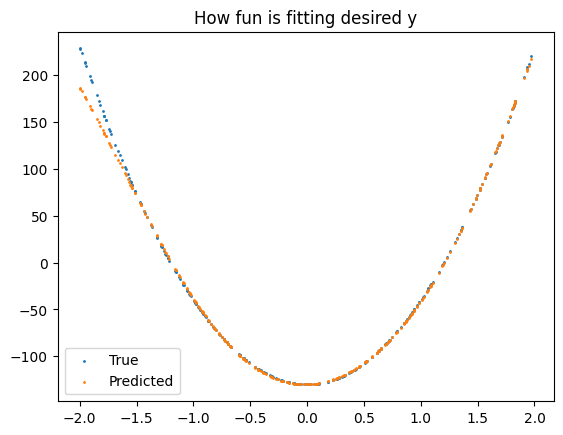

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.4899884205488656
Epoch: 251, Loss (standarized): 0.02322934190849889
Epoch: 501, Loss (standarized): 0.0027561888810540306
Epoch: 751, Loss (standarized): 0.0014879268083950485
Epoch: 1001, Loss (standarized): 0.0011497973326930425
Epoch: 1251, Loss (standarized): 0.0009814348526520735
Epoch: 1501, Loss (standarized): 0.0008572722426486671
Epoch: 1751, Loss (standarized): 0.0007738869614413623
Epoch: 2001, Loss (standarized): 0.0007073181593422476
Epoch: 2251, Loss (standarized): 0.0006629633633155067
Epoch: 2501, Loss (standarized): 0.0006143247642945722
Epoch: 2751, Loss (standarized): 0.0005796412809857906
Epoch: 3001, Loss (standarized): 0.000550034749413277
Epoch: 3251, Loss (standarized): 0.0005210472320742302
Epoch: 3501, Loss (standarized): 0.0005006395741276357
Epoch: 3751, Loss 

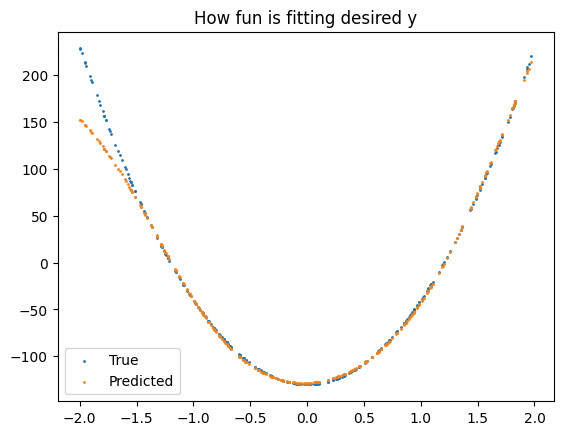

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.8199416476333021
Epoch: 251, Loss (standarized): 0.002751231054806936
Epoch: 501, Loss (standarized): 0.0009107619500441111
Epoch: 751, Loss (standarized): 0.0006909529179392242
Epoch: 1001, Loss (standarized): 0.0005728614857941813
Epoch: 1251, Loss (standarized): 0.0005139559484062694
Epoch: 1501, Loss (standarized): 0.00045311192661201863
Epoch: 1751, Loss (standarized): 0.00041951773830122333
Epoch: 2001, Loss (standarized): 0.0003862875539593457
Epoch: 2251, Loss (standarized): 0.0003554801734544678
Epoch: 2501, Loss (standarized): 0.00032928520070337267
Epoch: 2751, Loss (standarized): 0.00031484105005354194
Epoch: 3001, Loss (standarized): 0.0002927908963784961
Epoch: 3251, Loss (standarized): 0.0002797433582577971
Epoch: 3501, Loss (standarized): 0.00026562098644873275
Epoch: 375

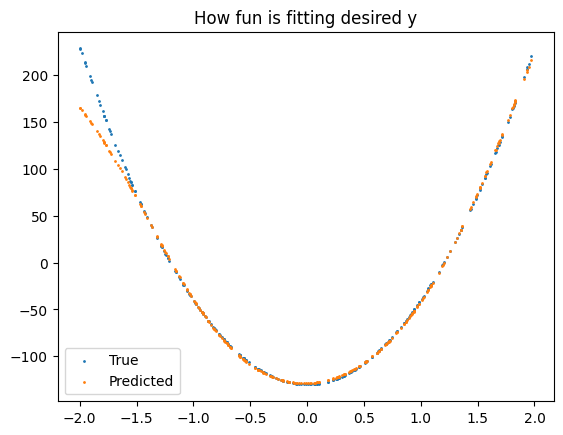

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.283897625464649
Epoch: 251, Loss (standarized): 0.0012993220698060029
Epoch: 501, Loss (standarized): 0.0006003487377710471
Epoch: 751, Loss (standarized): 0.0003451721509644903
Epoch: 1001, Loss (standarized): 0.00029732625420180565
Epoch: 1251, Loss (standarized): 0.0002814617668503683
Epoch: 1501, Loss (standarized): 0.00018925563566755496
Epoch: 1751, Loss (standarized): 0.00019125413288329055
Epoch: 2001, Loss (standarized): 0.0001610925287418664
Epoch: 2251, Loss (standarized): 0.00014288175800110798
Epoch: 2501, Loss (standarized): 0.00012731581488445998
Epoch: 2751, Loss (standarized): 0.00014686993442743332
Epoch: 3001, Loss (standarized): 0.00011616771116671219
Epoch: 3251, Loss (standarized): 0.00010734443541006912
Epoch: 3501, Loss (standarized): 0.00012087445444605964
Epoch:

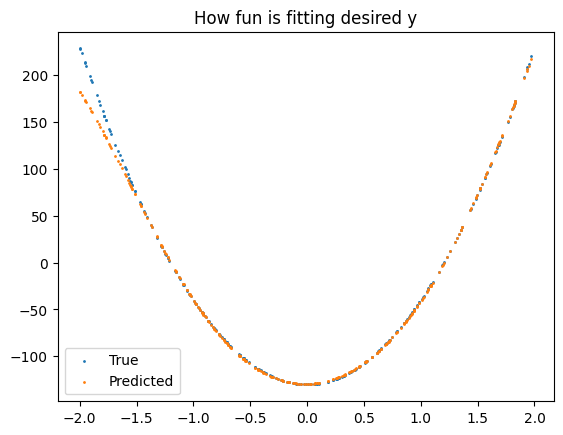

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.9199589742837517
Epoch: 251, Loss (standarized): 0.32943581626648333
Epoch: 501, Loss (standarized): 0.030920664481649887
Epoch: 751, Loss (standarized): 0.007201110089435734
Epoch: 1001, Loss (standarized): 0.0028707875651702913
Epoch: 1251, Loss (standarized): 0.0017968331226201513
Epoch: 1501, Loss (standarized): 0.0014211636032305502
Epoch: 1751, Loss (standarized): 0.0012359371598772055
Epoch: 2001, Loss (standarized): 0.0011135576733994526
Epoch: 2251, Loss (standarized): 0.0010237482902671878
Epoch: 2501, Loss (standarized): 0.0009523279219093823
Epoch: 2751, Loss (standarized): 0.0008923839174878468
Epoch: 3001, Loss (standarized): 0.0008380289890529062
Epoch: 3251, Loss (standarized): 0.0007960434080538053
Epoch: 3501, Loss (standarized): 0.0007600131017639773
Epoch: 3751, Loss (

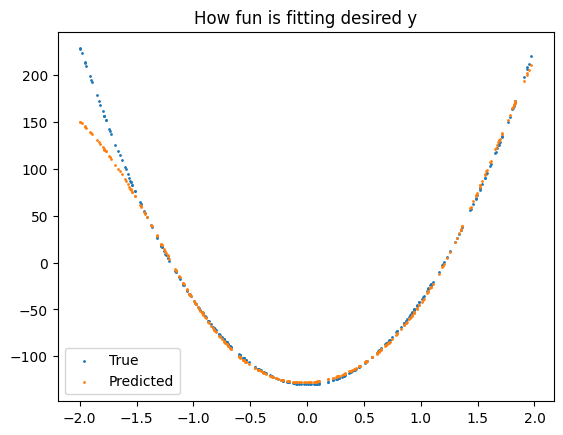

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.405587345818106
Epoch: 251, Loss (standarized): 0.2099444960321059
Epoch: 501, Loss (standarized): 0.008197110538510658
Epoch: 751, Loss (standarized): 0.0022371742607044487
Epoch: 1001, Loss (standarized): 0.0014832321487963113
Epoch: 1251, Loss (standarized): 0.0011816616155210285
Epoch: 1501, Loss (standarized): 0.0010049230973949025
Epoch: 1751, Loss (standarized): 0.0008799366743177052
Epoch: 2001, Loss (standarized): 0.0007938975570291692
Epoch: 2251, Loss (standarized): 0.0007324408705927909
Epoch: 2501, Loss (standarized): 0.0006745629758793855
Epoch: 2751, Loss (standarized): 0.0006365148447709343
Epoch: 3001, Loss (standarized): 0.0005943875914897632
Epoch: 3251, Loss (standarized): 0.0005629109599616658
Epoch: 3501, Loss (standarized): 0.0005334149204387797
Epoch: 3751, Loss (

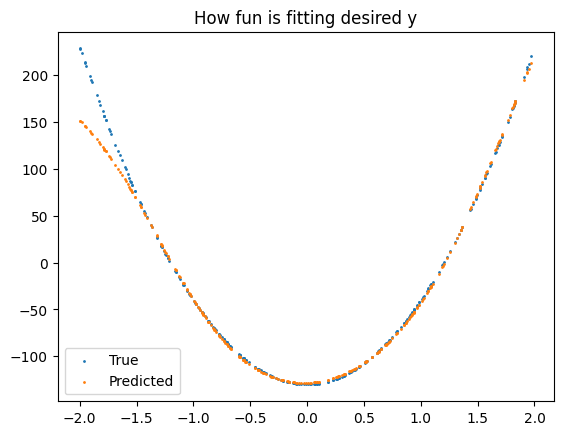

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.962282679363924
Epoch: 251, Loss (standarized): 0.0012426398455781954
Epoch: 501, Loss (standarized): 0.0006127545794221617
Epoch: 751, Loss (standarized): 0.000496588643115548
Epoch: 1001, Loss (standarized): 0.0003850202767231768
Epoch: 1251, Loss (standarized): 0.00033668136818667513
Epoch: 1501, Loss (standarized): 0.0002896081215931364
Epoch: 1751, Loss (standarized): 0.00025806981320914297
Epoch: 2001, Loss (standarized): 0.00024351627143816374
Epoch: 2251, Loss (standarized): 0.00023434760971521664
Epoch: 2501, Loss (standarized): 0.00020701806158453625
Epoch: 2751, Loss (standarized): 0.00019195998012371042
Epoch: 3001, Loss (standarized): 0.0001759519556023595
Epoch: 3251, Loss (standarized): 0.0001663221996495588
Epoch: 3501, Loss (standarized): 0.00016103386828417187
Epoch: 37

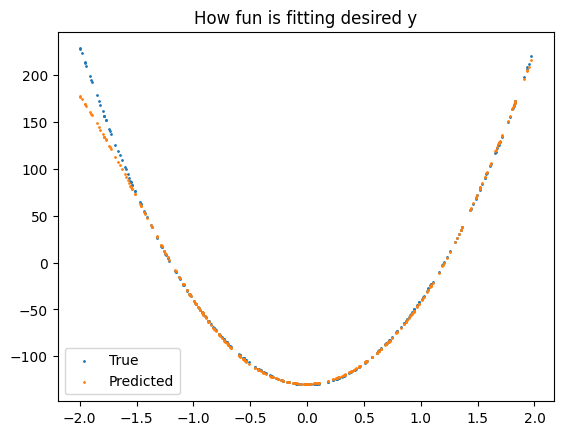

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.0305050715032684
Epoch: 251, Loss (standarized): 3.6657072606266544e-05
Epoch: 501, Loss (standarized): 2.7621613202316237e-05
Epoch: 751, Loss (standarized): 2.3141098772000284e-05
Epoch: 1001, Loss (standarized): 1.9247997925960597e-05
Epoch: 1251, Loss (standarized): 2.3729966964287642e-05
Epoch: 1501, Loss (standarized): 1.8272903683509236e-05
Epoch: 1751, Loss (standarized): 1.656127396060565e-05
Epoch: 2001, Loss (standarized): 1.3158156637755907e-05
Epoch: 2251, Loss (standarized): 1.274178812488867e-05
Epoch: 2501, Loss (standarized): 1.0718112101824164e-05
Epoch: 2751, Loss (standarized): 1.1265180397683197e-05
Epoch: 3001, Loss (standarized): 1.0026616472784059e-05
Epoch: 3251, Loss (standarized): 1.003560396124559e-05
Epoch: 3501, Loss (standarized): 1.0539317830407062e-05
Epoch:

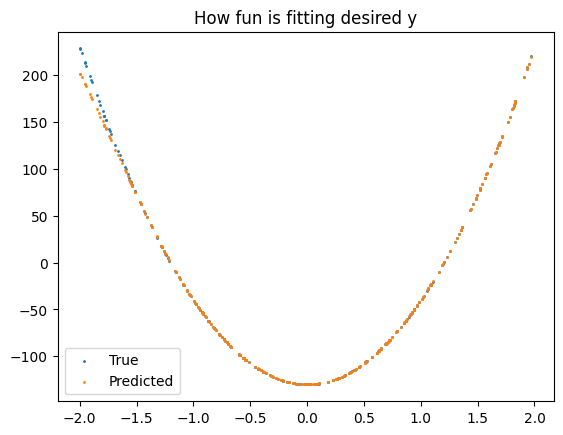

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.455296467214301
Epoch: 251, Loss (standarized): 2.607917959035976e-05
Epoch: 501, Loss (standarized): 1.9546986137908286e-05
Epoch: 751, Loss (standarized): 1.671240469500948e-05
Epoch: 1001, Loss (standarized): 1.540565469868943e-05
Epoch: 1251, Loss (standarized): 1.0846921769211809e-05
Epoch: 1501, Loss (standarized): 1.076027084561983e-05
Epoch: 1751, Loss (standarized): 8.865448161319862e-06
Epoch: 2001, Loss (standarized): 6.329866789177974e-06
Epoch: 2251, Loss (standarized): 6.324033517233511e-06
Epoch: 2501, Loss (standarized): 4.763778969354744e-06
Epoch: 2751, Loss (standarized): 6.357795037942769e-06
Epoch: 3001, Loss (standarized): 4.617914326084735e-06
Epoch: 3251, Loss (standarized): 4.2154962132578456e-06
Epoch: 3501, Loss (standarized): 4.629828695225131e-06
Epoch: 3751, L

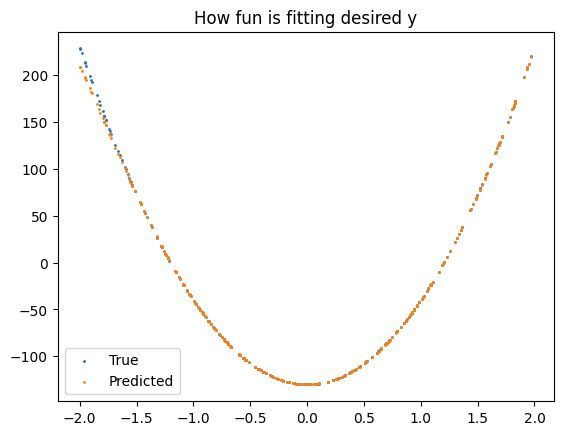

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.9986159424881116
Epoch: 251, Loss (standarized): 1.1642495612843389
Epoch: 501, Loss (standarized): 0.61076690505682
Epoch: 751, Loss (standarized): 0.3350288422697276
Epoch: 1001, Loss (standarized): 0.31622920668345555
Epoch: 1251, Loss (standarized): 0.5400117647417648
Epoch: 1501, Loss (standarized): 0.35348597260660514
Epoch: 1751, Loss (standarized): 0.46315512560699135
Epoch: 2001, Loss (standarized): 0.3591832171936701
Epoch: 2251, Loss (standarized): 0.2905591858960455
Epoch: 2501, Loss (standarized): 0.3655618348222207
Epoch: 2751, Loss (standarized): 0.7703650152140186
Epoch: 3001, Loss (standarized): 0.4587249325308769
Epoch: 3251, Loss (standarized): 0.4739998772347184
Epoch: 3501, Loss (standarized): 0.4058405555374721
Epoch: 3751, Loss (standarized): 0.33416269616698074
Epoc

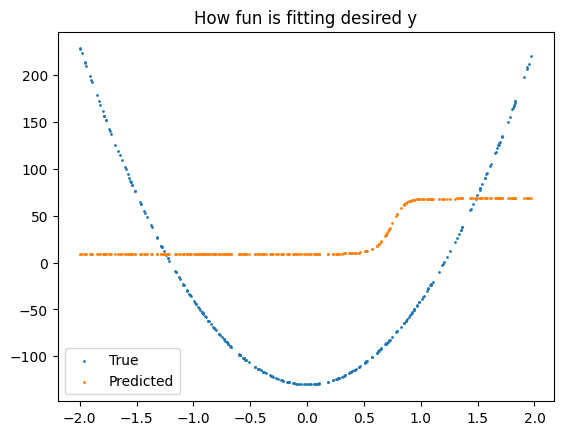

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.8165548477730307
Epoch: 251, Loss (standarized): 0.000147874104568967
Epoch: 501, Loss (standarized): 3.2967457532538757e-05
Epoch: 751, Loss (standarized): 1.976226285611764e-05
Epoch: 1001, Loss (standarized): 1.7795975266226594e-05
Epoch: 1251, Loss (standarized): 1.589059653457934e-05
Epoch: 1501, Loss (standarized): 1.4414026039476974e-05
Epoch: 1751, Loss (standarized): 1.456194226325459e-05
Epoch: 2001, Loss (standarized): 1.162092090478549e-05
Epoch: 2251, Loss (standarized): 1.2604512064588712e-05
Epoch: 2501, Loss (standarized): 9.641700265821525e-06
Epoch: 2751, Loss (standarized): 9.629017053020766e-06
Epoch: 3001, Loss (standarized): 8.919967666275705e-06
Epoch: 3251, Loss (standarized): 8.39880801054454e-06
Epoch: 3501, Loss (standarized): 9.562434909154643e-06
Epoch: 3751, L

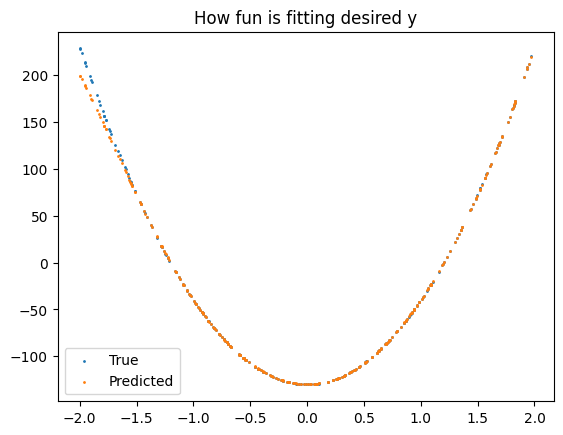

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.509605329067526
Epoch: 251, Loss (standarized): 0.00015393180235389177
Epoch: 501, Loss (standarized): 7.410898946881078e-05
Epoch: 751, Loss (standarized): 2.347069087415691e-05
Epoch: 1001, Loss (standarized): 5.276958650613885e-06
Epoch: 1251, Loss (standarized): 2.101816989562765e-06
Epoch: 1501, Loss (standarized): 1.7480746903404887e-06
Epoch: 1751, Loss (standarized): 1.6698243278229058e-06
Epoch: 2001, Loss (standarized): 1.6557835217812946e-06
Epoch: 2251, Loss (standarized): 1.2010511074623754e-06
Epoch: 2501, Loss (standarized): 1.1740779532634311e-06
Epoch: 2751, Loss (standarized): 1.3275450756316553e-06
Epoch: 3001, Loss (standarized): 8.989697928334494e-07
Epoch: 3251, Loss (standarized): 1.012603347927251e-06
Epoch: 3501, Loss (standarized): 8.624774258818525e-07
Epoch: 37

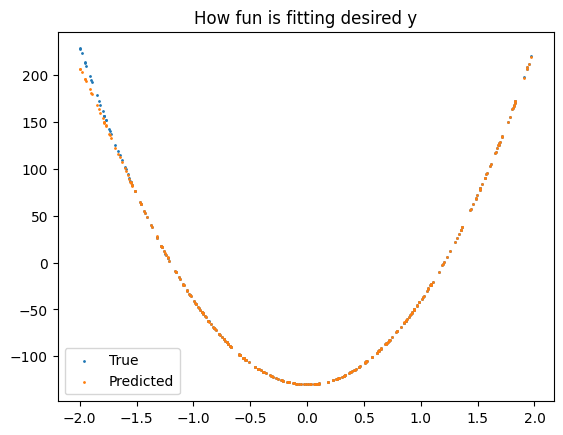

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.084556330469774
Epoch: 251, Loss (standarized): 1.1333265065615823
Epoch: 501, Loss (standarized): 1.0957638663403353
Epoch: 751, Loss (standarized): 1.2399471389740095
Epoch: 1001, Loss (standarized): 1.2431500910630928
Epoch: 1251, Loss (standarized): 1.10881440847573
Epoch: 1501, Loss (standarized): 1.1414909040869454
Epoch: 1751, Loss (standarized): 1.0877623240753094
Epoch: 2001, Loss (standarized): 1.1070479589024416
Epoch: 2251, Loss (standarized): 1.0517313807841726
Epoch: 2501, Loss (standarized): 1.1159013596014322
Epoch: 2751, Loss (standarized): 1.007252985056773
Epoch: 3001, Loss (standarized): 1.3977016221935843
Epoch: 3251, Loss (standarized): 1.1014387643343995
Epoch: 3501, Loss (standarized): 1.060077912439624
Epoch: 3751, Loss (standarized): 1.1295868402994966
Epoch: 400

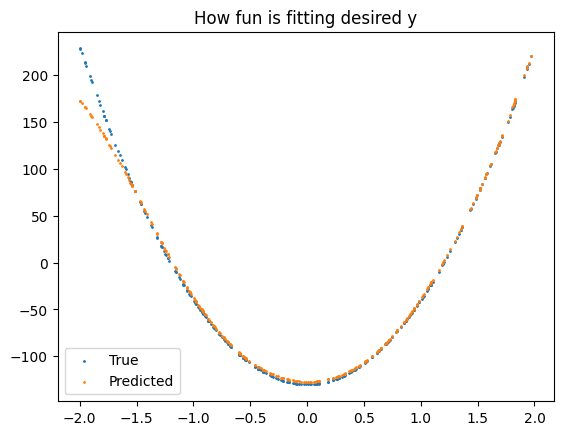

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.927813986764817
Epoch: 251, Loss (standarized): 0.0004245745369513322
Epoch: 501, Loss (standarized): 0.00022168308609304214
Epoch: 751, Loss (standarized): 0.00013015486889322465
Epoch: 1001, Loss (standarized): 7.517825911117e-05
Epoch: 1251, Loss (standarized): 4.1928544673452515e-05
Epoch: 1501, Loss (standarized): 2.61922285529492e-05
Epoch: 1751, Loss (standarized): 1.7866706258905577e-05
Epoch: 2001, Loss (standarized): 1.3895503058778792e-05
Epoch: 2251, Loss (standarized): 1.1481355341670621e-05
Epoch: 2501, Loss (standarized): 1.056050045317647e-05
Epoch: 2751, Loss (standarized): 9.698518157814482e-06
Epoch: 3001, Loss (standarized): 9.172307833404752e-06
Epoch: 3251, Loss (standarized): 8.729856932473082e-06
Epoch: 3501, Loss (standarized): 8.385114062991452e-06
Epoch: 3751, Lo

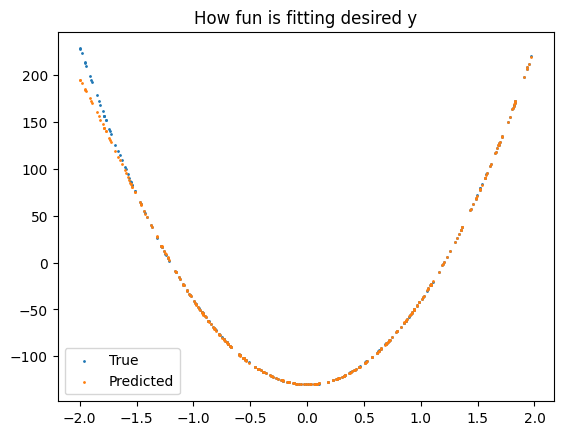

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.9951421444788786
Epoch: 251, Loss (standarized): 9.878893461768318e-05
Epoch: 501, Loss (standarized): 3.488973765854961e-05
Epoch: 751, Loss (standarized): 2.818087206325893e-05
Epoch: 1001, Loss (standarized): 2.16801254314383e-05
Epoch: 1251, Loss (standarized): 2.0984798021203888e-05
Epoch: 1501, Loss (standarized): 1.973888949574634e-05
Epoch: 1751, Loss (standarized): 1.7749429351116664e-05
Epoch: 2001, Loss (standarized): 1.8624022313401072e-05
Epoch: 2251, Loss (standarized): 1.5674800456061178e-05
Epoch: 2501, Loss (standarized): 1.4412452505700255e-05
Epoch: 2751, Loss (standarized): 1.5110823282147272e-05
Epoch: 3001, Loss (standarized): 1.359085035213417e-05
Epoch: 3251, Loss (standarized): 1.6306780866218328e-05
Epoch: 3501, Loss (standarized): 1.2318241555680075e-05
Epoch: 3

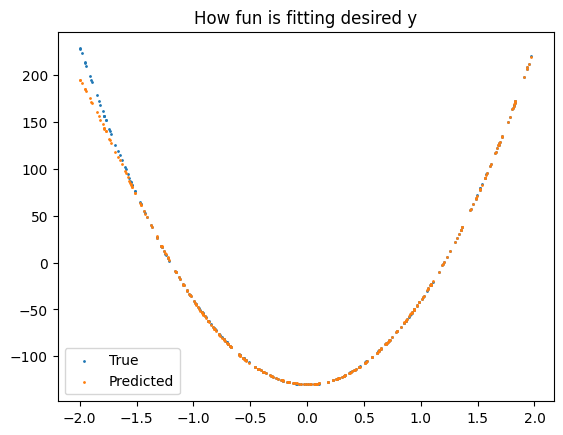

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.3475300946276043
Epoch: 251, Loss (standarized): 0.32985000353866534
Epoch: 501, Loss (standarized): 0.27650179237087646
Epoch: 751, Loss (standarized): 0.29778102507022625
Epoch: 1001, Loss (standarized): 0.2732989580110936
Epoch: 1251, Loss (standarized): 0.2786936693949873
Epoch: 1501, Loss (standarized): 0.3852363700503194
Epoch: 1751, Loss (standarized): 0.2953414150982985
Epoch: 2001, Loss (standarized): 0.33501376436021596
Epoch: 2251, Loss (standarized): 0.27028351604600265
Epoch: 2501, Loss (standarized): 0.2841438178888826
Epoch: 2751, Loss (standarized): 0.283506306314635
Epoch: 3001, Loss (standarized): 0.27193457831612017
Epoch: 3251, Loss (standarized): 0.29403584965895524
Epoch: 3501, Loss (standarized): 0.0004183011580992463
Epoch: 3751, Loss (standarized): 0.0001150441086

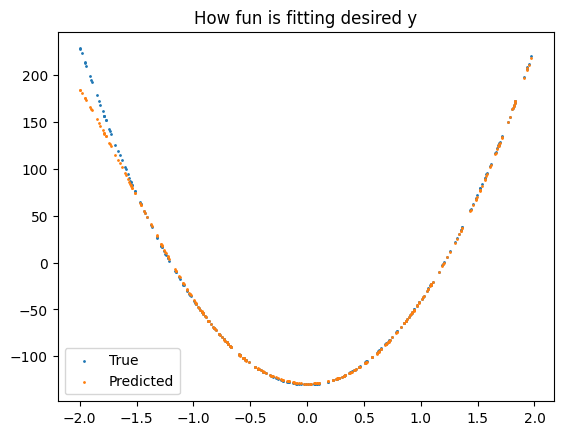

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.5914195286038333
Epoch: 251, Loss (standarized): 0.0007348183618055181
Epoch: 501, Loss (standarized): 0.00036599361679692165
Epoch: 751, Loss (standarized): 0.00018825725757641793
Epoch: 1001, Loss (standarized): 0.00011303725405339488
Epoch: 1251, Loss (standarized): 6.841844749231667e-05
Epoch: 1501, Loss (standarized): 4.7285625852475264e-05
Epoch: 1751, Loss (standarized): 3.775479837865859e-05
Epoch: 2001, Loss (standarized): 3.213651284642279e-05
Epoch: 2251, Loss (standarized): 2.8700826018749277e-05
Epoch: 2501, Loss (standarized): 2.712079892833169e-05
Epoch: 2751, Loss (standarized): 2.5360490735392448e-05
Epoch: 3001, Loss (standarized): 2.490068524285395e-05
Epoch: 3251, Loss (standarized): 2.389480826199386e-05
Epoch: 3501, Loss (standarized): 2.4204750177855857e-05
Epoch: 37

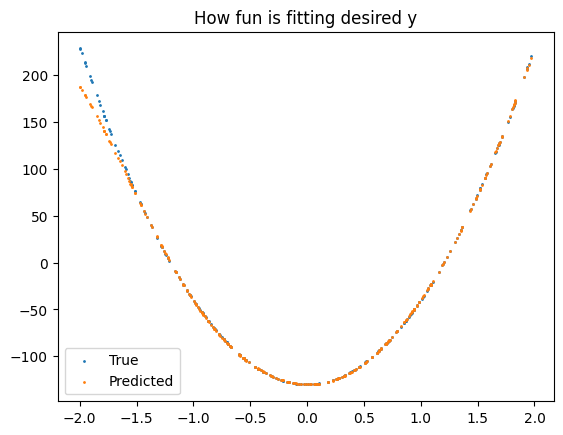

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.67688580633371
Epoch: 251, Loss (standarized): 0.0005423694696725025
Epoch: 501, Loss (standarized): 0.0003550087675304995
Epoch: 751, Loss (standarized): 0.0002318937805833702
Epoch: 1001, Loss (standarized): 0.00015444413484618877
Epoch: 1251, Loss (standarized): 0.00010479039424306592
Epoch: 1501, Loss (standarized): 6.77407826139601e-05
Epoch: 1751, Loss (standarized): 4.474795449003229e-05
Epoch: 2001, Loss (standarized): 2.9861751858986742e-05
Epoch: 2251, Loss (standarized): 2.59625251436358e-05
Epoch: 2501, Loss (standarized): 1.8641900273235673e-05
Epoch: 2751, Loss (standarized): 1.6341720377058568e-05
Epoch: 3001, Loss (standarized): 1.5076800340101702e-05
Epoch: 3251, Loss (standarized): 1.4055818991448244e-05
Epoch: 3501, Loss (standarized): 1.4424686287803282e-05
Epoch: 3751

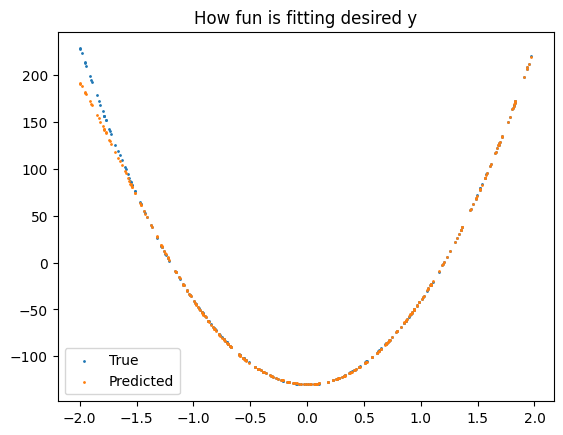

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.5479812270797018
Epoch: 251, Loss (standarized): 0.00022251070373313802
Epoch: 501, Loss (standarized): 0.00011065976471017363
Epoch: 751, Loss (standarized): 8.93883755052554e-05
Epoch: 1001, Loss (standarized): 3.5437379320936335e-05
Epoch: 1251, Loss (standarized): 2.3554585002241797e-05
Epoch: 1501, Loss (standarized): 2.153582263921983e-05
Epoch: 1751, Loss (standarized): 1.455686602328721e-05
Epoch: 2001, Loss (standarized): 2.0943554238414233e-05
Epoch: 2251, Loss (standarized): 1.4393472184990712e-05
Epoch: 2501, Loss (standarized): 1.1425455434046548e-05
Epoch: 2751, Loss (standarized): 8.959352570355196e-06
Epoch: 3001, Loss (standarized): 7.548010903037161e-06
Epoch: 3251, Loss (standarized): 7.07148713924894e-06
Epoch: 3501, Loss (standarized): 7.913302698224745e-06
Epoch: 375

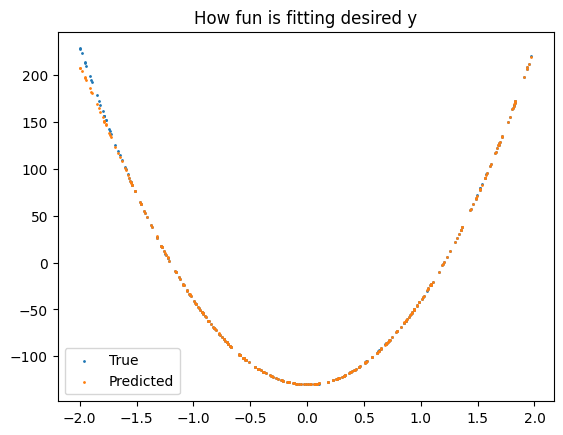

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.6427425209346507
Epoch: 251, Loss (standarized): 0.0027127700233637907
Epoch: 501, Loss (standarized): 0.0011000495569017568
Epoch: 751, Loss (standarized): 0.0007902183670040875
Epoch: 1001, Loss (standarized): 0.0006466257389517448
Epoch: 1251, Loss (standarized): 0.0005575704184422265
Epoch: 1501, Loss (standarized): 0.000494536000738262
Epoch: 1751, Loss (standarized): 0.00044976745442791566
Epoch: 2001, Loss (standarized): 0.00041082857406127667
Epoch: 2251, Loss (standarized): 0.0003903361776278504
Epoch: 2501, Loss (standarized): 0.00034558984671073753
Epoch: 2751, Loss (standarized): 0.00032231814345862225
Epoch: 3001, Loss (standarized): 0.00030291437014135566
Epoch: 3251, Loss (standarized): 0.00027821271162647174
Epoch: 3501, Loss (standarized): 0.0002637752327409203
Epoch: 375

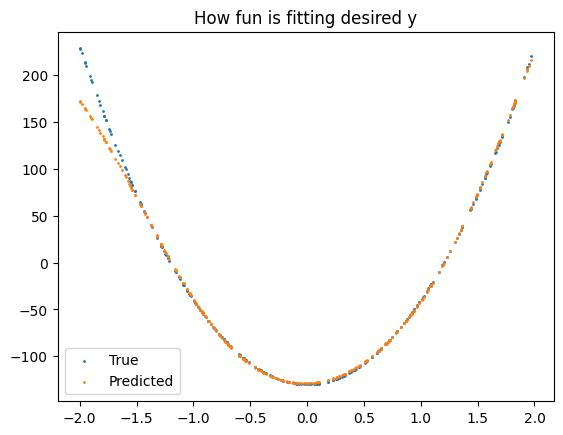

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.493133471183143
Epoch: 251, Loss (standarized): 0.0004964915823523281
Epoch: 501, Loss (standarized): 0.0003581863262401243
Epoch: 751, Loss (standarized): 0.0002937338005777384
Epoch: 1001, Loss (standarized): 0.00024416792973263587
Epoch: 1251, Loss (standarized): 0.0002118477983757511
Epoch: 1501, Loss (standarized): 0.00019023709727155746
Epoch: 1751, Loss (standarized): 0.00018693145132538924
Epoch: 2001, Loss (standarized): 0.00014317958344706598
Epoch: 2251, Loss (standarized): 0.00012498005807218442
Epoch: 2501, Loss (standarized): 0.0001142554606484783
Epoch: 2751, Loss (standarized): 0.0001001028146080907
Epoch: 3001, Loss (standarized): 9.199472461651893e-05
Epoch: 3251, Loss (standarized): 8.488412636464312e-05
Epoch: 3501, Loss (standarized): 7.619784360280441e-05
Epoch: 375

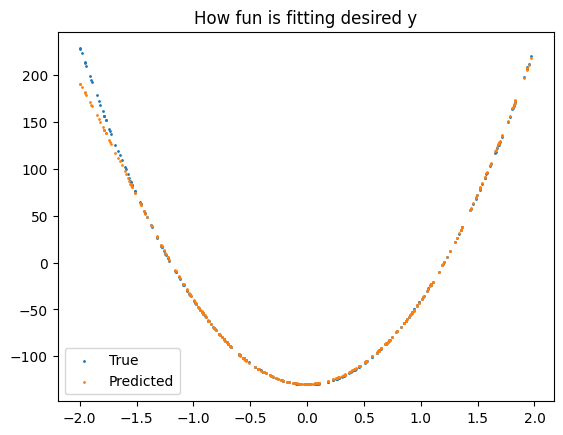

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.702425721160809
Epoch: 251, Loss (standarized): 9.95709277384688e-05
Epoch: 501, Loss (standarized): 3.483495215055867e-05
Epoch: 751, Loss (standarized): 2.7793995562799127e-05
Epoch: 1001, Loss (standarized): 2.0657776768687944e-05
Epoch: 1251, Loss (standarized): 1.7919281997973145e-05
Epoch: 1501, Loss (standarized): 1.6856651481939775e-05
Epoch: 1751, Loss (standarized): 1.3853867893684807e-05
Epoch: 2001, Loss (standarized): 1.2589892757943895e-05
Epoch: 2251, Loss (standarized): 1.2223487276160136e-05
Epoch: 2501, Loss (standarized): 1.0374818053189597e-05
Epoch: 2751, Loss (standarized): 9.084563460476516e-06
Epoch: 3001, Loss (standarized): 8.17807134063783e-06
Epoch: 3251, Loss (standarized): 7.446946194003084e-06
Epoch: 3501, Loss (standarized): 7.040202273678506e-06
Epoch: 37

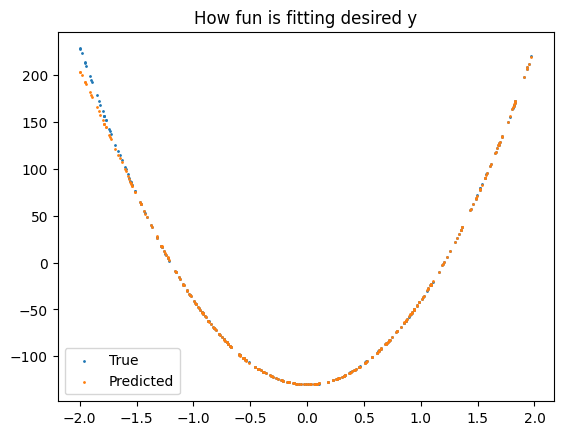

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.206194414258624
Epoch: 251, Loss (standarized): 0.013351275056214914
Epoch: 501, Loss (standarized): 0.0012442491387997712
Epoch: 751, Loss (standarized): 0.0008066566991619442
Epoch: 1001, Loss (standarized): 0.0006863171969226804
Epoch: 1251, Loss (standarized): 0.000616060205744069
Epoch: 1501, Loss (standarized): 0.0005526141410359103
Epoch: 1751, Loss (standarized): 0.0005071044542108385
Epoch: 2001, Loss (standarized): 0.0004668663949225946
Epoch: 2251, Loss (standarized): 0.0004309151322736336
Epoch: 2501, Loss (standarized): 0.0003998636312896172
Epoch: 2751, Loss (standarized): 0.0003763070350192401
Epoch: 3001, Loss (standarized): 0.00035143657039634154
Epoch: 3251, Loss (standarized): 0.0003301897555093501
Epoch: 3501, Loss (standarized): 0.0003129275848304736
Epoch: 3751, Loss

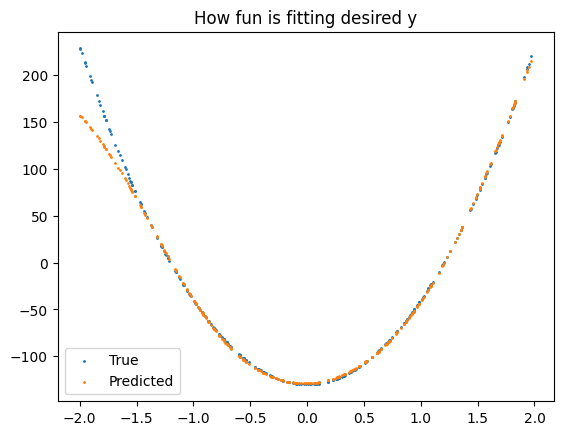

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.9515210129757738
Epoch: 251, Loss (standarized): 0.003516277166136392
Epoch: 501, Loss (standarized): 0.002128178549341367
Epoch: 751, Loss (standarized): 0.0016182940736407323
Epoch: 1001, Loss (standarized): 0.001346313096942613
Epoch: 1251, Loss (standarized): 0.00111224028550973
Epoch: 1501, Loss (standarized): 0.0009297523692148087
Epoch: 1751, Loss (standarized): 0.0008100183625469022
Epoch: 2001, Loss (standarized): 0.0007154571892034136
Epoch: 2251, Loss (standarized): 0.0006370672063601353
Epoch: 2501, Loss (standarized): 0.0005699353197490459
Epoch: 2751, Loss (standarized): 0.0005009478327768019
Epoch: 3001, Loss (standarized): 0.0004482544576399556
Epoch: 3251, Loss (standarized): 0.00038949528037835157
Epoch: 3501, Loss (standarized): 0.00033789129998811524
Epoch: 3751, Loss

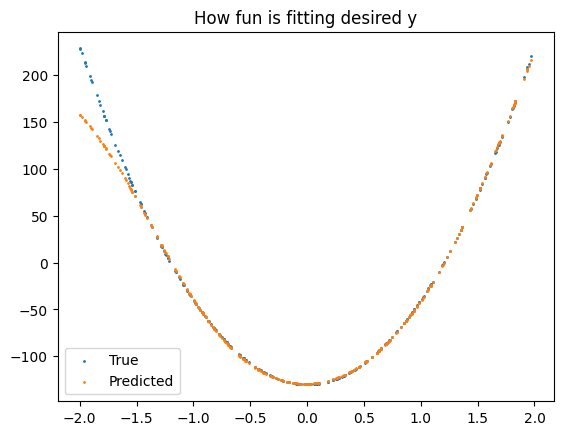

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.591548492283899
Epoch: 251, Loss (standarized): 0.0007712135838096458
Epoch: 501, Loss (standarized): 0.0005225031477008326
Epoch: 751, Loss (standarized): 0.00038558529274030235
Epoch: 1001, Loss (standarized): 0.0002945876196660019
Epoch: 1251, Loss (standarized): 0.0002373391342517878
Epoch: 1501, Loss (standarized): 0.00021236848991864927
Epoch: 1751, Loss (standarized): 0.000176061314443784
Epoch: 2001, Loss (standarized): 0.00016142695511522603
Epoch: 2251, Loss (standarized): 0.0001437694594279715
Epoch: 2501, Loss (standarized): 0.00013883924410933816
Epoch: 2751, Loss (standarized): 0.00011165280741002386
Epoch: 3001, Loss (standarized): 9.999597240283224e-05
Epoch: 3251, Loss (standarized): 8.908824495516031e-05
Epoch: 3501, Loss (standarized): 8.083707611699343e-05
Epoch: 3751

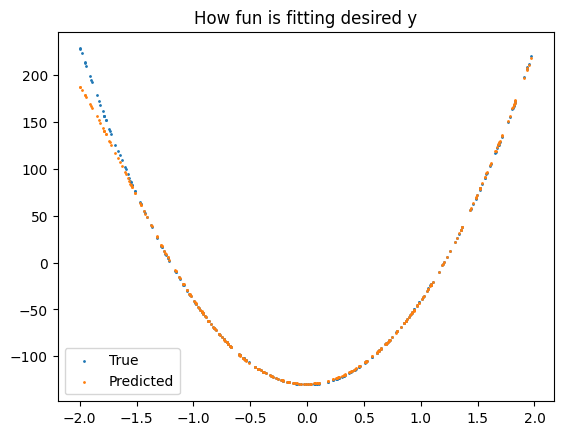

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.5253186966188497
Epoch: 251, Loss (standarized): 0.31390549884928537
Epoch: 501, Loss (standarized): 0.013196620499238369
Epoch: 751, Loss (standarized): 0.0035771514075469677
Epoch: 1001, Loss (standarized): 0.0018327054185598422
Epoch: 1251, Loss (standarized): 0.0013432175801404444
Epoch: 1501, Loss (standarized): 0.0011360737902544149
Epoch: 1751, Loss (standarized): 0.0010245756821924206
Epoch: 2001, Loss (standarized): 0.0009413659512727618
Epoch: 2251, Loss (standarized): 0.0008803303633029302
Epoch: 2501, Loss (standarized): 0.0008268723089682351
Epoch: 2751, Loss (standarized): 0.0007782383101466543
Epoch: 3001, Loss (standarized): 0.0007401161249484922
Epoch: 3251, Loss (standarized): 0.0007059555017242618
Epoch: 3501, Loss (standarized): 0.0006748612783390543
Epoch: 3751, Loss 

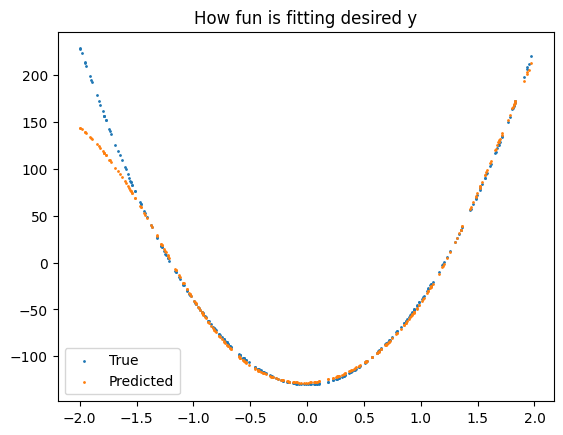

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.0747118921720746
Epoch: 251, Loss (standarized): 0.040900518811036984
Epoch: 501, Loss (standarized): 0.004342525499198543
Epoch: 751, Loss (standarized): 0.0015158566135862923
Epoch: 1001, Loss (standarized): 0.000977566418352985
Epoch: 1251, Loss (standarized): 0.0007834396655280934
Epoch: 1501, Loss (standarized): 0.0006750541544291528
Epoch: 1751, Loss (standarized): 0.0005984376643283107
Epoch: 2001, Loss (standarized): 0.000550916172362763
Epoch: 2251, Loss (standarized): 0.0005044035804661782
Epoch: 2501, Loss (standarized): 0.00047145446866392446
Epoch: 2751, Loss (standarized): 0.0004479695843901413
Epoch: 3001, Loss (standarized): 0.00042161229842652544
Epoch: 3251, Loss (standarized): 0.00040521335260056796
Epoch: 3501, Loss (standarized): 0.0003878983481201136
Epoch: 3751, Lo

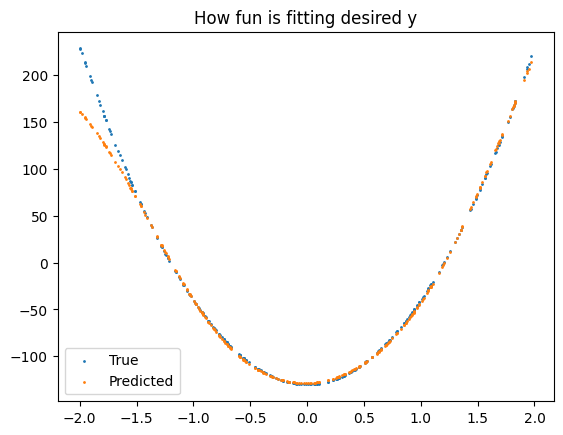

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.5398181597241805
Epoch: 251, Loss (standarized): 0.0008147304811658305
Epoch: 501, Loss (standarized): 0.0005300718959464229
Epoch: 751, Loss (standarized): 0.0004301431228108627
Epoch: 1001, Loss (standarized): 0.00031931149996300434
Epoch: 1251, Loss (standarized): 0.0002670939092258026
Epoch: 1501, Loss (standarized): 0.00023062631620306365
Epoch: 1751, Loss (standarized): 0.0002001910298458138
Epoch: 2001, Loss (standarized): 0.0001764313242371329
Epoch: 2251, Loss (standarized): 0.00015488926338331734
Epoch: 2501, Loss (standarized): 0.00013721932751533847
Epoch: 2751, Loss (standarized): 0.0001227257891016648
Epoch: 3001, Loss (standarized): 0.00011560316936215242
Epoch: 3251, Loss (standarized): 9.845532048089062e-05
Epoch: 3501, Loss (standarized): 9.110314675824981e-05
Epoch: 37

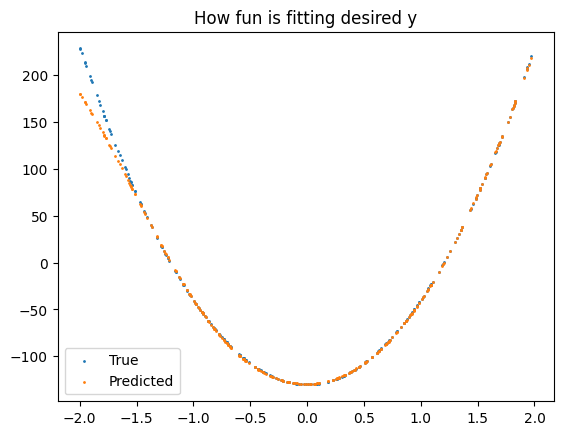

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.5768641754061947
Epoch: 251, Loss (standarized): 4.095252188333304e-05
Epoch: 501, Loss (standarized): 2.277930098030952e-05
Epoch: 751, Loss (standarized): 1.4267138556149695e-05
Epoch: 1001, Loss (standarized): 1.2800845648807387e-05
Epoch: 1251, Loss (standarized): 1.0333670590449512e-05
Epoch: 1501, Loss (standarized): 5.7900803493145995e-06
Epoch: 1751, Loss (standarized): 4.9719126870603475e-06
Epoch: 2001, Loss (standarized): 6.943882842514183e-06
Epoch: 2251, Loss (standarized): 4.015477624376706e-06
Epoch: 2501, Loss (standarized): 2.9420732437554083e-06
Epoch: 2751, Loss (standarized): 3.8754083644477395e-06
Epoch: 3001, Loss (standarized): 2.2608467102230825e-06
Epoch: 3251, Loss (standarized): 1.7245651001017587e-06
Epoch: 3501, Loss (standarized): 1.6495549671022706e-06
Epoch: 

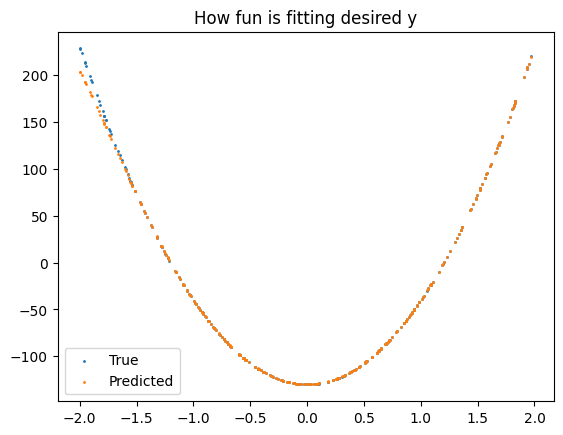

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.5218967323811063
Epoch: 251, Loss (standarized): 0.0007628184985453276
Epoch: 501, Loss (standarized): 0.0017088485283207624
Epoch: 751, Loss (standarized): 0.00010460821871525921
Epoch: 1001, Loss (standarized): 5.090032842039487e-05
Epoch: 1251, Loss (standarized): 1.2547067063567734e-05
Epoch: 1501, Loss (standarized): 3.857009736495348e-06
Epoch: 1751, Loss (standarized): 5.7236349614615345e-06
Epoch: 2001, Loss (standarized): 2.9991662816876387e-06
Epoch: 2251, Loss (standarized): 1.703353593065628e-05
Epoch: 2501, Loss (standarized): 6.946795223625883e-05
Epoch: 2751, Loss (standarized): 3.864264775526247e-05
Epoch: 3001, Loss (standarized): 3.357820611467788e-06
Epoch: 3251, Loss (standarized): 2.8956804596563222e-06
Epoch: 3501, Loss (standarized): 8.542013908081444e-06
Epoch: 3751

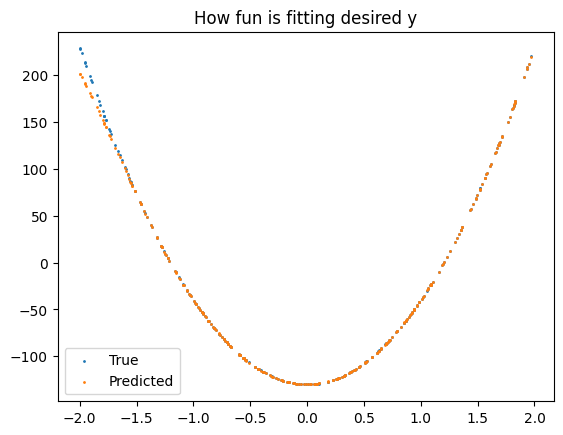

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.783254056078558
Epoch: 251, Loss (standarized): 1.0673984539581323
Epoch: 501, Loss (standarized): 1.0400034831389204
Epoch: 751, Loss (standarized): 1.0670973454681192
Epoch: 1001, Loss (standarized): 1.1363372057827412
Epoch: 1251, Loss (standarized): 1.072853900389198
Epoch: 1501, Loss (standarized): 1.2186383474104148
Epoch: 1751, Loss (standarized): 1.2664612615646544
Epoch: 2001, Loss (standarized): 1.2678540668001959
Epoch: 2251, Loss (standarized): 1.1246330909297637
Epoch: 2501, Loss (standarized): 1.1124979010038893
Epoch: 2751, Loss (standarized): 1.16248210643479
Epoch: 3001, Loss (standarized): 1.085201987640669
Epoch: 3251, Loss (standarized): 1.1236370008095278
Epoch: 3501, Loss (standarized): 2.0712982054147933
Epoch: 3751, Loss (standarized): 1.1412025862478445
Epoch: 4001

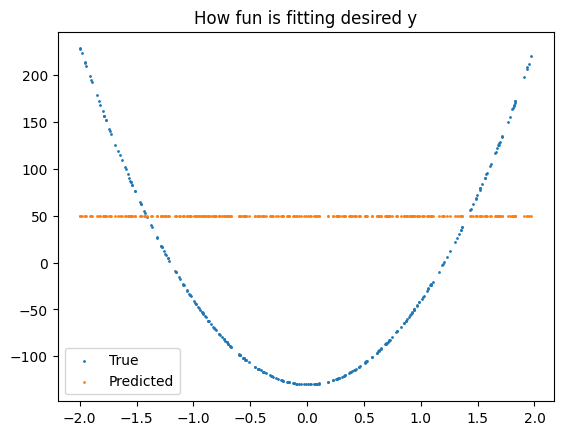

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.6276718357751552
Epoch: 251, Loss (standarized): 0.00011663155349213987
Epoch: 501, Loss (standarized): 4.851011750225497e-05
Epoch: 751, Loss (standarized): 2.5617053930393343e-05
Epoch: 1001, Loss (standarized): 1.8452637819171223e-05
Epoch: 1251, Loss (standarized): 1.6151930564561668e-05
Epoch: 1501, Loss (standarized): 1.3503876520994217e-05
Epoch: 1751, Loss (standarized): 1.2496092778512687e-05
Epoch: 2001, Loss (standarized): 1.2711938927409298e-05
Epoch: 2251, Loss (standarized): 1.0172737178120295e-05
Epoch: 2501, Loss (standarized): 9.314416454411713e-06
Epoch: 2751, Loss (standarized): 1.0173128161123359e-05
Epoch: 3001, Loss (standarized): 8.578108723212628e-06
Epoch: 3251, Loss (standarized): 7.787800624440427e-06
Epoch: 3501, Loss (standarized): 9.435574772579062e-06
Epoch: 

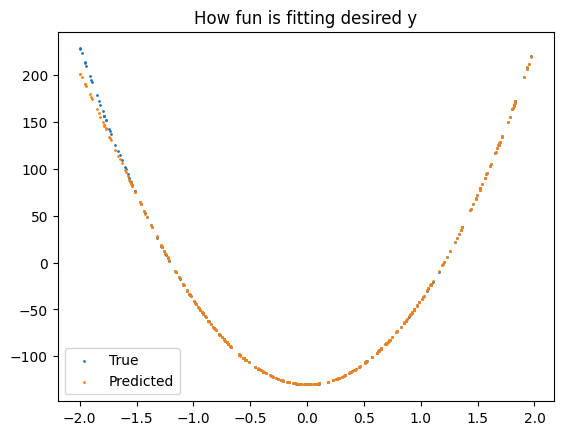

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.1933600403268647
Epoch: 251, Loss (standarized): 8.445434287493348e-05
Epoch: 501, Loss (standarized): 8.555753001612393e-05
Epoch: 751, Loss (standarized): 3.919582407234112e-05
Epoch: 1001, Loss (standarized): 3.778960960192953e-05
Epoch: 1251, Loss (standarized): 3.526738332989275e-05
Epoch: 1501, Loss (standarized): 4.4555900597746345e-05
Epoch: 1751, Loss (standarized): 2.5012645980810937e-05
Epoch: 2001, Loss (standarized): 2.2605210238481183e-05
Epoch: 2251, Loss (standarized): 1.5781897025016793e-05
Epoch: 2501, Loss (standarized): 2.533678772886184e-05
Epoch: 2751, Loss (standarized): 1.3564373468905782e-05
Epoch: 3001, Loss (standarized): 1.3576391981320278e-05
Epoch: 3251, Loss (standarized): 9.547030669381817e-06
Epoch: 3501, Loss (standarized): 1.0144303305384448e-05
Epoch: 3

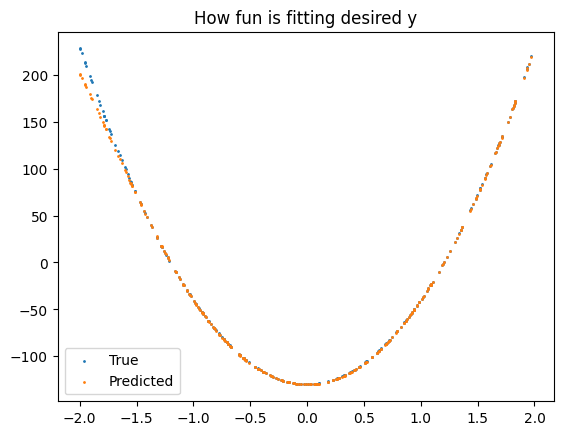

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.3899312307524505
Epoch: 251, Loss (standarized): 1.7492831198358736e-05
Epoch: 501, Loss (standarized): 4.330286635943528e-05
Epoch: 751, Loss (standarized): 1.140719871268729e-05
Epoch: 1001, Loss (standarized): 6.194185868288739e-06
Epoch: 1251, Loss (standarized): 8.023028836939432e-06
Epoch: 1501, Loss (standarized): 1.1497748455047178e-05
Epoch: 1751, Loss (standarized): 8.233346377919638e-06
Epoch: 2001, Loss (standarized): 6.504754251273761e-06
Epoch: 2251, Loss (standarized): 1.62172532063943e-05
Epoch: 2501, Loss (standarized): 8.8400961034643e-06
Epoch: 2751, Loss (standarized): 5.446446539537073e-06
Epoch: 3001, Loss (standarized): 1.1488113015303952e-05
Epoch: 3251, Loss (standarized): 2.7752456590510234e-06
Epoch: 3501, Loss (standarized): 3.081834595906355e-06
Epoch: 3751, L

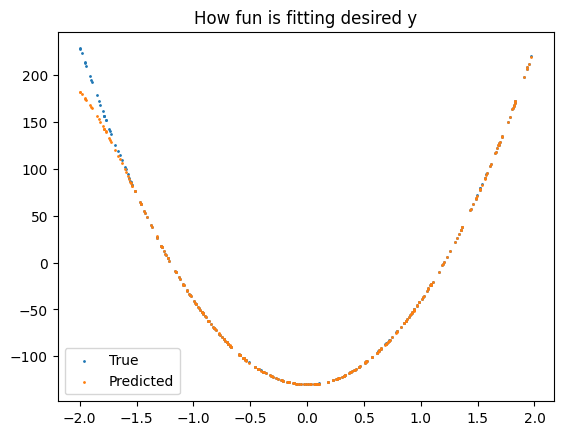

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.9916290245346426
Epoch: 251, Loss (standarized): 0.0002452342018959425
Epoch: 501, Loss (standarized): 0.00010433994288425728
Epoch: 751, Loss (standarized): 5.387392135646107e-05
Epoch: 1001, Loss (standarized): 2.7262982793444002e-05
Epoch: 1251, Loss (standarized): 1.6896709072013896e-05
Epoch: 1501, Loss (standarized): 1.2168176560897434e-05
Epoch: 1751, Loss (standarized): 1.05432739715148e-05
Epoch: 2001, Loss (standarized): 9.648078420639177e-06
Epoch: 2251, Loss (standarized): 8.969859522090576e-06
Epoch: 2501, Loss (standarized): 7.897045557323909e-06
Epoch: 2751, Loss (standarized): 7.678087395853345e-06
Epoch: 3001, Loss (standarized): 7.52399099524072e-06
Epoch: 3251, Loss (standarized): 7.0426283703795744e-06
Epoch: 3501, Loss (standarized): 6.7618717671010665e-06
Epoch: 3751,

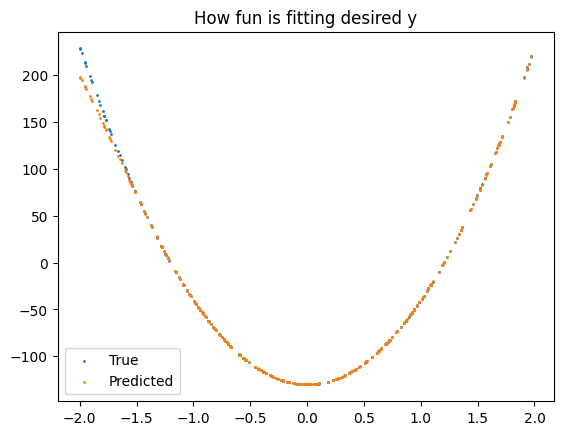

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.293269184664462
Epoch: 251, Loss (standarized): 0.0007147931883939797
Epoch: 501, Loss (standarized): 0.0004426013383508423
Epoch: 751, Loss (standarized): 0.00027137061880731734
Epoch: 1001, Loss (standarized): 0.0002999677615263249
Epoch: 1251, Loss (standarized): 0.00017145956434027143
Epoch: 1501, Loss (standarized): 0.00015032020206118228
Epoch: 1751, Loss (standarized): 0.00011051117336593921
Epoch: 2001, Loss (standarized): 6.247124987185318e-05
Epoch: 2251, Loss (standarized): 4.1356931699554294e-05
Epoch: 2501, Loss (standarized): 2.072123286337258e-05
Epoch: 2751, Loss (standarized): 1.0909763789623028e-05
Epoch: 3001, Loss (standarized): 1.642440385595978e-05
Epoch: 3251, Loss (standarized): 1.3720564328073425e-05
Epoch: 3501, Loss (standarized): 1.0368186494873423e-05
Epoch: 3

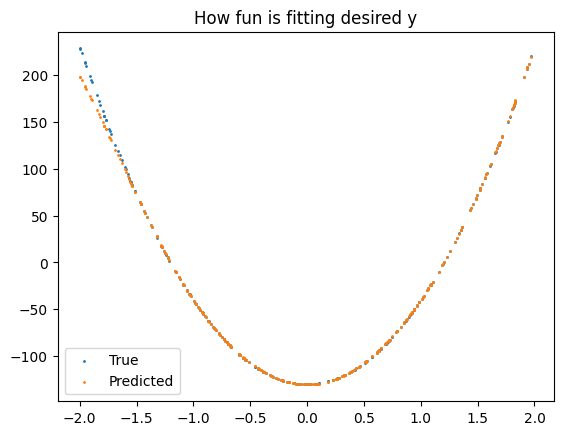

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.423382110465514
Epoch: 251, Loss (standarized): 1.0739226121953416
Epoch: 501, Loss (standarized): 0.9457484632195704
Epoch: 751, Loss (standarized): 0.949810591513441
Epoch: 1001, Loss (standarized): 0.9544048047696015
Epoch: 1251, Loss (standarized): 0.9713697298595834
Epoch: 1501, Loss (standarized): 1.0021997310996265
Epoch: 1751, Loss (standarized): 1.010451625094217
Epoch: 2001, Loss (standarized): 0.947364876196653
Epoch: 2251, Loss (standarized): 1.073178697608278
Epoch: 2501, Loss (standarized): 0.9421395418577252
Epoch: 2751, Loss (standarized): 0.9982198134651399
Epoch: 3001, Loss (standarized): 1.0187253509367944
Epoch: 3251, Loss (standarized): 0.9419251178382475
Epoch: 3501, Loss (standarized): 0.9589791493737544
Epoch: 3751, Loss (standarized): 0.9809439745425726
Epoch: 400

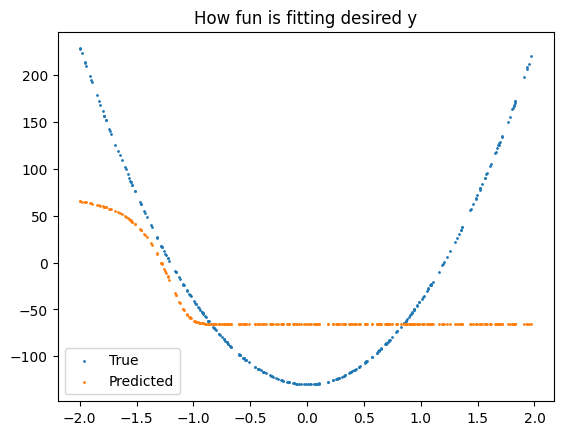

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.6331821474573895
Epoch: 251, Loss (standarized): 0.0016089777536512498
Epoch: 501, Loss (standarized): 0.0009051162395808759
Epoch: 751, Loss (standarized): 0.0006332562508834806
Epoch: 1001, Loss (standarized): 0.0004728919924568758
Epoch: 1251, Loss (standarized): 0.0004038084389432783
Epoch: 1501, Loss (standarized): 0.00029141913501319887
Epoch: 1751, Loss (standarized): 0.00022321635588310493
Epoch: 2001, Loss (standarized): 0.00017784628112047288
Epoch: 2251, Loss (standarized): 0.00014254591910260904
Epoch: 2501, Loss (standarized): 0.00011196064808114229
Epoch: 2751, Loss (standarized): 8.735520500140663e-05
Epoch: 3001, Loss (standarized): 6.981620143153939e-05
Epoch: 3251, Loss (standarized): 5.821566817893999e-05
Epoch: 3501, Loss (standarized): 5.316588446615294e-05
Epoch: 3751

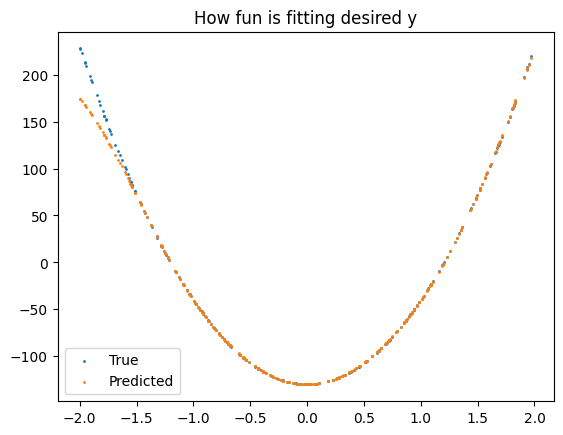

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.921697955712888
Epoch: 251, Loss (standarized): 0.0009352554301619704
Epoch: 501, Loss (standarized): 0.00048327344367969617
Epoch: 751, Loss (standarized): 0.00029861820309620745
Epoch: 1001, Loss (standarized): 0.00018832600651006413
Epoch: 1251, Loss (standarized): 0.00011220163493855405
Epoch: 1501, Loss (standarized): 7.022543467132825e-05
Epoch: 1751, Loss (standarized): 4.210424709042553e-05
Epoch: 2001, Loss (standarized): 2.9825187453503342e-05
Epoch: 2251, Loss (standarized): 2.4240302580849555e-05
Epoch: 2501, Loss (standarized): 1.8352464797683126e-05
Epoch: 2751, Loss (standarized): 1.681983266308594e-05
Epoch: 3001, Loss (standarized): 1.5034840302959064e-05
Epoch: 3251, Loss (standarized): 1.4914043103542254e-05
Epoch: 3501, Loss (standarized): 1.4817383492977724e-05
Epoch:

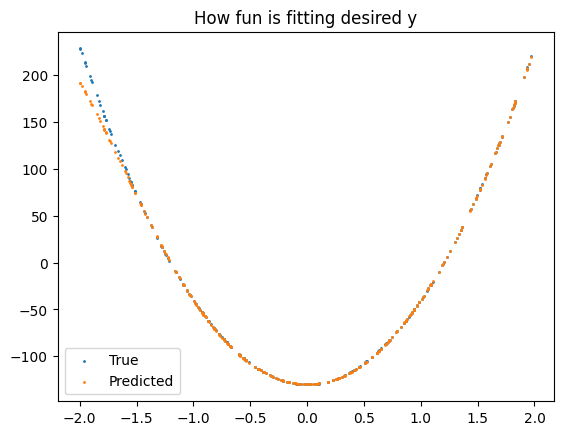

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.135232238193693
Epoch: 251, Loss (standarized): 0.00018317925599350664
Epoch: 501, Loss (standarized): 5.7144407393314254e-05
Epoch: 751, Loss (standarized): 3.8911662121812796e-05
Epoch: 1001, Loss (standarized): 2.5907454756406205e-05
Epoch: 1251, Loss (standarized): 2.8668558234531467e-05
Epoch: 1501, Loss (standarized): 1.4312570818374005e-05
Epoch: 1751, Loss (standarized): 1.74556431442496e-05
Epoch: 2001, Loss (standarized): 6.481576136984806e-06
Epoch: 2251, Loss (standarized): 6.7725096814070525e-06
Epoch: 2501, Loss (standarized): 4.611184235691025e-06
Epoch: 2751, Loss (standarized): 3.189909481417825e-06
Epoch: 3001, Loss (standarized): 4.929662810852137e-06
Epoch: 3251, Loss (standarized): 2.2468007430888534e-06
Epoch: 3501, Loss (standarized): 2.2622494534078047e-06
Epoch: 3

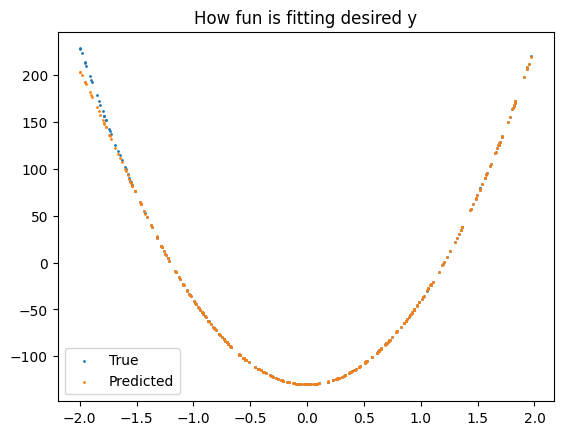

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.11062061821788
Epoch: 251, Loss (standarized): 0.0013382481654913535
Epoch: 501, Loss (standarized): 0.0008021717379938995
Epoch: 751, Loss (standarized): 0.0006099803786767053
Epoch: 1001, Loss (standarized): 0.0004925775804899227
Epoch: 1251, Loss (standarized): 0.00039523960224082446
Epoch: 1501, Loss (standarized): 0.00032975076317017936
Epoch: 1751, Loss (standarized): 0.000284886957151334
Epoch: 2001, Loss (standarized): 0.0002457109065432149
Epoch: 2251, Loss (standarized): 0.0002177929072978479
Epoch: 2501, Loss (standarized): 0.00018239314034103265
Epoch: 2751, Loss (standarized): 0.0001607723033631955
Epoch: 3001, Loss (standarized): 0.00014524539215612136
Epoch: 3251, Loss (standarized): 0.0001255953157375669
Epoch: 3501, Loss (standarized): 0.00011775403064509529
Epoch: 3751, 

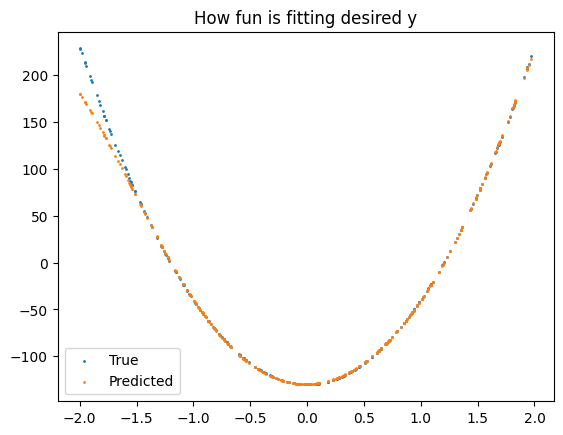

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.866534299242364
Epoch: 251, Loss (standarized): 0.0010365980716680516
Epoch: 501, Loss (standarized): 0.0006380084066067638
Epoch: 751, Loss (standarized): 0.00045282752476418365
Epoch: 1001, Loss (standarized): 0.0003438648238712358
Epoch: 1251, Loss (standarized): 0.0002568387129363559
Epoch: 1501, Loss (standarized): 0.00017611167519932314
Epoch: 1751, Loss (standarized): 0.00012917825408210266
Epoch: 2001, Loss (standarized): 8.839301215972954e-05
Epoch: 2251, Loss (standarized): 6.141768291824946e-05
Epoch: 2501, Loss (standarized): 4.376752264149213e-05
Epoch: 2751, Loss (standarized): 3.2816350470793275e-05
Epoch: 3001, Loss (standarized): 2.6143796943682643e-05
Epoch: 3251, Loss (standarized): 2.0660840522874956e-05
Epoch: 3501, Loss (standarized): 2.070616656769529e-05
Epoch: 37

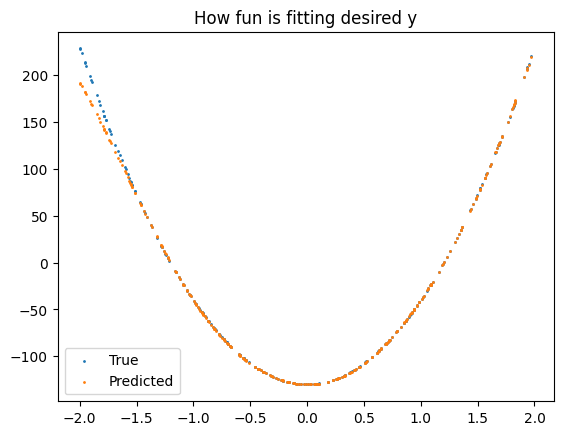

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.042707905384514
Epoch: 251, Loss (standarized): 0.00017184704825524822
Epoch: 501, Loss (standarized): 0.00010440231300202222
Epoch: 751, Loss (standarized): 7.244655164572409e-05
Epoch: 1001, Loss (standarized): 6.19624684865094e-05
Epoch: 1251, Loss (standarized): 4.927217029515021e-05
Epoch: 1501, Loss (standarized): 3.733844817500353e-05
Epoch: 1751, Loss (standarized): 2.922933307439485e-05
Epoch: 2001, Loss (standarized): 2.5469981439965016e-05
Epoch: 2251, Loss (standarized): 2.1880050896510514e-05
Epoch: 2501, Loss (standarized): 1.862617829411126e-05
Epoch: 2751, Loss (standarized): 1.929197691815362e-05
Epoch: 3001, Loss (standarized): 1.3346736846722219e-05
Epoch: 3251, Loss (standarized): 1.1742945277547007e-05
Epoch: 3501, Loss (standarized): 1.1431580325261727e-05
Epoch: 37

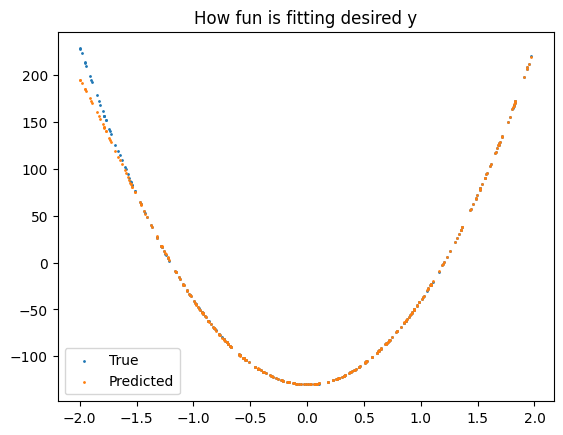

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.5719564544102629
Epoch: 251, Loss (standarized): 0.02948093754519533
Epoch: 501, Loss (standarized): 0.003341271951378021
Epoch: 751, Loss (standarized): 0.0023575327157941686
Epoch: 1001, Loss (standarized): 0.0019655781809832813
Epoch: 1251, Loss (standarized): 0.0017132685802520808
Epoch: 1501, Loss (standarized): 0.0015090477459323815
Epoch: 1751, Loss (standarized): 0.0013536770937429483
Epoch: 2001, Loss (standarized): 0.0012367779013416787
Epoch: 2251, Loss (standarized): 0.001133426631767538
Epoch: 2501, Loss (standarized): 0.001046654620616516
Epoch: 2751, Loss (standarized): 0.0009794498723273862
Epoch: 3001, Loss (standarized): 0.0009136224603055551
Epoch: 3251, Loss (standarized): 0.0008644238977972378
Epoch: 3501, Loss (standarized): 0.0008137504005272179
Epoch: 3751, Loss (s

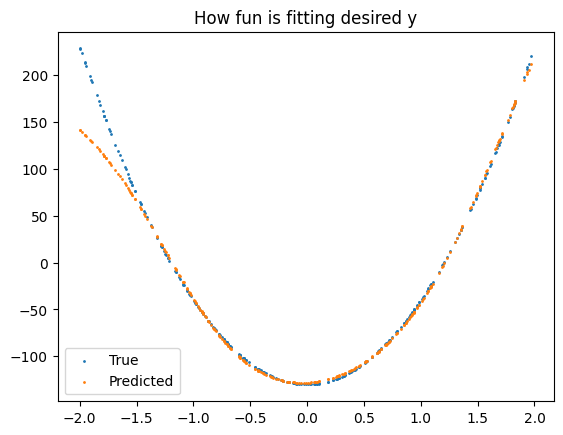

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.313680375701435
Epoch: 251, Loss (standarized): 0.003242831529302921
Epoch: 501, Loss (standarized): 0.0018598591213024097
Epoch: 751, Loss (standarized): 0.0013801882475020313
Epoch: 1001, Loss (standarized): 0.0010981398465635718
Epoch: 1251, Loss (standarized): 0.0009140304800366334
Epoch: 1501, Loss (standarized): 0.000766155914526541
Epoch: 1751, Loss (standarized): 0.0006684248383045454
Epoch: 2001, Loss (standarized): 0.0005842310252252282
Epoch: 2251, Loss (standarized): 0.0005053431788899868
Epoch: 2501, Loss (standarized): 0.00044231225219466244
Epoch: 2751, Loss (standarized): 0.0003834614086935297
Epoch: 3001, Loss (standarized): 0.00034117866004965526
Epoch: 3251, Loss (standarized): 0.0002873902709370595
Epoch: 3501, Loss (standarized): 0.000254710448041038
Epoch: 3751, Los

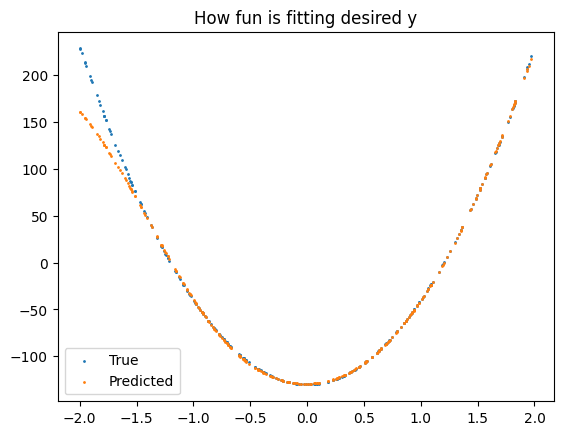

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.749879843557291
Epoch: 251, Loss (standarized): 0.0009234426563559375
Epoch: 501, Loss (standarized): 0.0005694863027276083
Epoch: 751, Loss (standarized): 0.0002836341674764335
Epoch: 1001, Loss (standarized): 0.00019873745283377164
Epoch: 1251, Loss (standarized): 8.76392850952266e-05
Epoch: 1501, Loss (standarized): 4.6618604860382856e-05
Epoch: 1751, Loss (standarized): 3.4152957687378586e-05
Epoch: 2001, Loss (standarized): 2.209715739703755e-05
Epoch: 2251, Loss (standarized): 1.838849526996377e-05
Epoch: 2501, Loss (standarized): 1.705134292617461e-05
Epoch: 2751, Loss (standarized): 1.610046946266299e-05
Epoch: 3001, Loss (standarized): 1.4093225390744838e-05
Epoch: 3251, Loss (standarized): 1.4145719754844181e-05
Epoch: 3501, Loss (standarized): 1.4414291943403545e-05
Epoch: 375

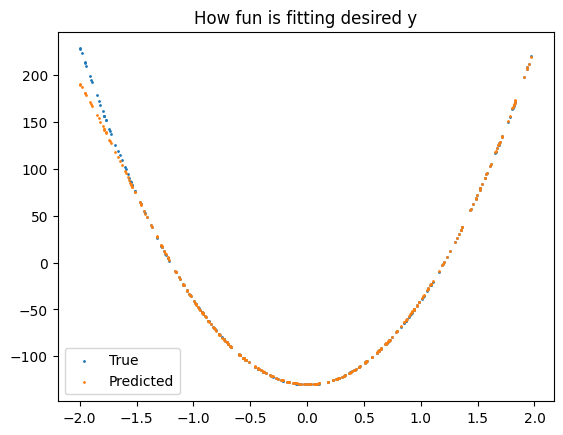

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.520986567187821
Epoch: 251, Loss (standarized): 0.642023123377247
Epoch: 501, Loss (standarized): 0.02924057205803162
Epoch: 751, Loss (standarized): 0.007522021806271382
Epoch: 1001, Loss (standarized): 0.003023259379425898
Epoch: 1251, Loss (standarized): 0.0016838768080591699
Epoch: 1501, Loss (standarized): 0.0012047156530959665
Epoch: 1751, Loss (standarized): 0.0010094574878315467
Epoch: 2001, Loss (standarized): 0.000908024673323813
Epoch: 2251, Loss (standarized): 0.0008364606200338335
Epoch: 2501, Loss (standarized): 0.0007905681619679786
Epoch: 2751, Loss (standarized): 0.0007548143436442309
Epoch: 3001, Loss (standarized): 0.0007252636591357157
Epoch: 3251, Loss (standarized): 0.0006996709056076898
Epoch: 3501, Loss (standarized): 0.0006730903099768743
Epoch: 3751, Loss (standa

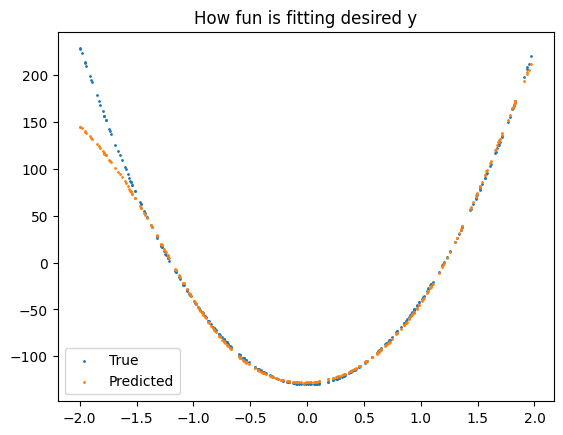

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.064016575301381
Epoch: 251, Loss (standarized): 0.08480586557504337
Epoch: 501, Loss (standarized): 0.004163778746358487
Epoch: 751, Loss (standarized): 0.001497912067765964
Epoch: 1001, Loss (standarized): 0.0011124723807655053
Epoch: 1251, Loss (standarized): 0.0009317061724529153
Epoch: 1501, Loss (standarized): 0.0007784170693079872
Epoch: 1751, Loss (standarized): 0.0006646290461371303
Epoch: 2001, Loss (standarized): 0.0005633134157664481
Epoch: 2251, Loss (standarized): 0.0004811863536135805
Epoch: 2501, Loss (standarized): 0.000413481241939921
Epoch: 2751, Loss (standarized): 0.00035351217971830496
Epoch: 3001, Loss (standarized): 0.00030513427733866395
Epoch: 3251, Loss (standarized): 0.00026124963941743655
Epoch: 3501, Loss (standarized): 0.0002291526013197411
Epoch: 3751, Loss

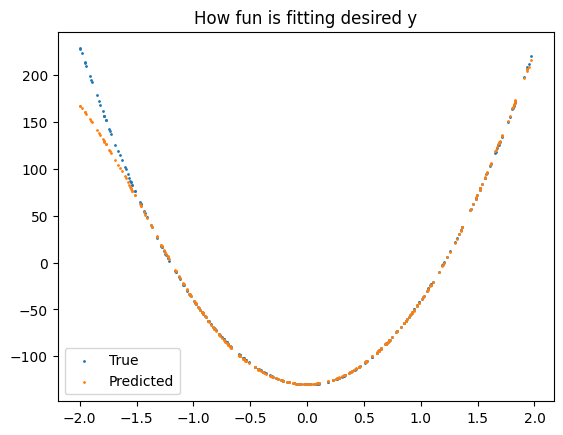

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.540463569201869
Epoch: 251, Loss (standarized): 0.0005633842697334788
Epoch: 501, Loss (standarized): 0.00033982154391687386
Epoch: 751, Loss (standarized): 0.00026618200431466723
Epoch: 1001, Loss (standarized): 0.00021637526333281412
Epoch: 1251, Loss (standarized): 0.00019022840459679473
Epoch: 1501, Loss (standarized): 0.00017983326337183217
Epoch: 1751, Loss (standarized): 0.00013599023105936346
Epoch: 2001, Loss (standarized): 0.00012354457163387116
Epoch: 2251, Loss (standarized): 0.00010292244950658225
Epoch: 2501, Loss (standarized): 9.18442455421764e-05
Epoch: 2751, Loss (standarized): 7.32795555455339e-05
Epoch: 3001, Loss (standarized): 6.481062254466318e-05
Epoch: 3251, Loss (standarized): 5.8547806623913185e-05
Epoch: 3501, Loss (standarized): 4.189565024079936e-05
Epoch: 3

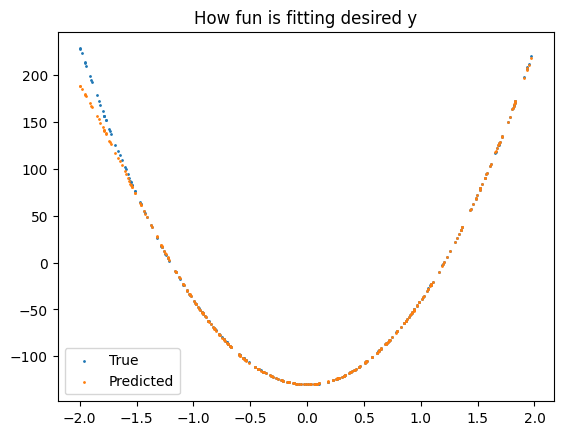

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.1727138971366262
Epoch: 251, Loss (standarized): 8.138605030480445e-05
Epoch: 501, Loss (standarized): 4.12200711247449e-05
Epoch: 751, Loss (standarized): 3.415436546668596e-05
Epoch: 1001, Loss (standarized): 2.9007776445921716e-05
Epoch: 1251, Loss (standarized): 3.504458083730615e-05
Epoch: 1501, Loss (standarized): 4.735286894714798e-05
Epoch: 1751, Loss (standarized): 2.4433869407173483e-05
Epoch: 2001, Loss (standarized): 2.1094674201214383e-05
Epoch: 2251, Loss (standarized): 2.955408471101371e-05
Epoch: 2501, Loss (standarized): 2.080215588928761e-05
Epoch: 2751, Loss (standarized): 1.5175114392775644e-05
Epoch: 3001, Loss (standarized): 1.6967387497162994e-05
Epoch: 3251, Loss (standarized): 1.5743731434005104e-05
Epoch: 3501, Loss (standarized): 1.5385850336413952e-05
Epoch: 3751

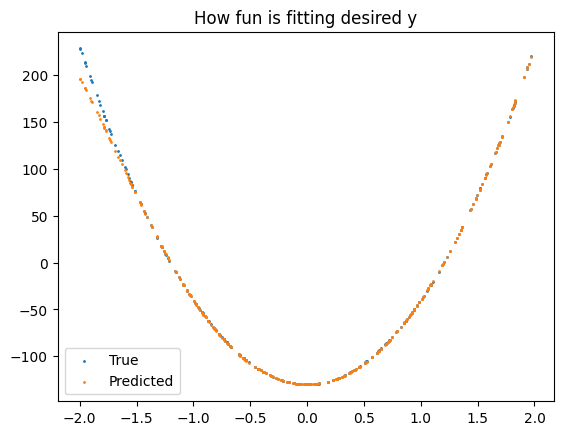

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.8003008141996526
Epoch: 251, Loss (standarized): 2.6821063077098886e-05
Epoch: 501, Loss (standarized): 2.177445499389108e-05
Epoch: 751, Loss (standarized): 8.543790790174475e-06
Epoch: 1001, Loss (standarized): 4.239893184323824e-06
Epoch: 1251, Loss (standarized): 4.7624339925723935e-06
Epoch: 1501, Loss (standarized): 5.030669889177948e-06
Epoch: 1751, Loss (standarized): 3.862606387159792e-06
Epoch: 2001, Loss (standarized): 3.874555303349234e-06
Epoch: 2251, Loss (standarized): 2.481474360926266e-06
Epoch: 2501, Loss (standarized): 2.535982498956748e-06
Epoch: 2751, Loss (standarized): 2.9527667243114666e-06
Epoch: 3001, Loss (standarized): 1.6625552313093314e-06
Epoch: 3251, Loss (standarized): 1.926844916062868e-06
Epoch: 3501, Loss (standarized): 1.6193957358578201e-06
Epoch: 3751

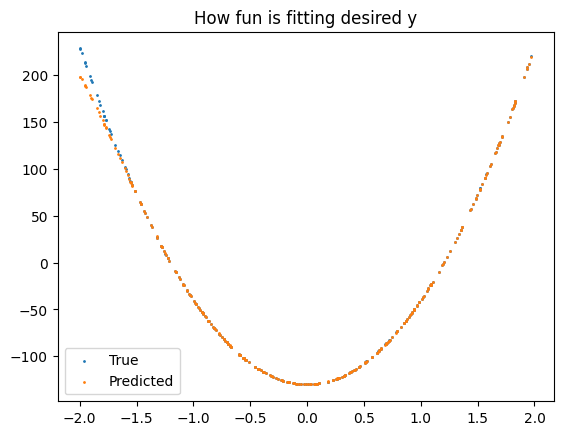

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.3085617894616624
Epoch: 251, Loss (standarized): 1.3933707375753863
Epoch: 501, Loss (standarized): 1.5740415535976822
Epoch: 751, Loss (standarized): 1.0691650142776012
Epoch: 1001, Loss (standarized): 1.2012484018670841
Epoch: 1251, Loss (standarized): 1.103033390291355
Epoch: 1501, Loss (standarized): 1.09347027299432
Epoch: 1751, Loss (standarized): 1.3730531893972273
Epoch: 2001, Loss (standarized): 1.108242706060777
Epoch: 2251, Loss (standarized): 1.0148656877014153
Epoch: 2501, Loss (standarized): 1.1563989900711615
Epoch: 2751, Loss (standarized): 1.8886010094292758
Epoch: 3001, Loss (standarized): 1.1297214871603996
Epoch: 3251, Loss (standarized): 1.1593732577887752
Epoch: 3501, Loss (standarized): 1.3038357130083047
Epoch: 3751, Loss (standarized): 1.3729237933681784
Epoch: 400

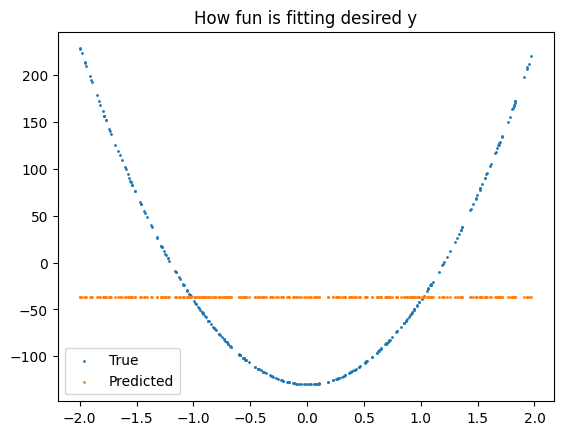

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.7155355348237336
Epoch: 251, Loss (standarized): 4.762598155546922e-05
Epoch: 501, Loss (standarized): 3.2342899571376085e-05
Epoch: 751, Loss (standarized): 3.535331183296787e-05
Epoch: 1001, Loss (standarized): 3.834184104427574e-05
Epoch: 1251, Loss (standarized): 2.5687044608590533e-05
Epoch: 1501, Loss (standarized): 2.2977880707678854e-05
Epoch: 1751, Loss (standarized): 2.1799841880170658e-05
Epoch: 2001, Loss (standarized): 2.124765132496014e-05
Epoch: 2251, Loss (standarized): 2.8327871001024254e-05
Epoch: 2501, Loss (standarized): 1.7364419652516762e-05
Epoch: 2751, Loss (standarized): 1.7652686407269555e-05
Epoch: 3001, Loss (standarized): 2.1415268577868713e-05
Epoch: 3251, Loss (standarized): 1.5499605991020275e-05
Epoch: 3501, Loss (standarized): 1.363875906235328e-05
Epoch: 

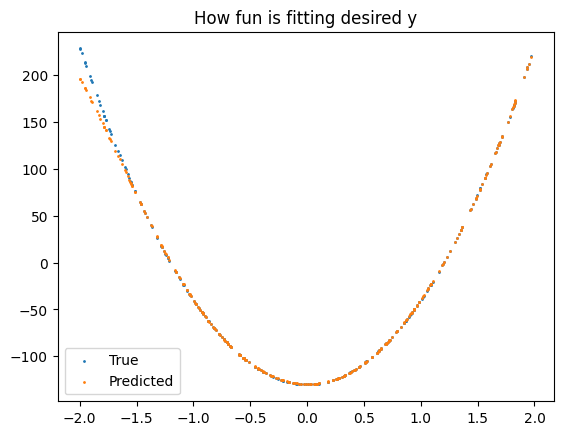

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.339419987012496
Epoch: 251, Loss (standarized): 0.00011113307526475666
Epoch: 501, Loss (standarized): 6.918463336684872e-05
Epoch: 751, Loss (standarized): 8.500040325712822e-05
Epoch: 1001, Loss (standarized): 5.497256674125102e-05
Epoch: 1251, Loss (standarized): 3.17141125089057e-05
Epoch: 1501, Loss (standarized): 2.6228936933587193e-05
Epoch: 1751, Loss (standarized): 2.3620143581472552e-05
Epoch: 2001, Loss (standarized): 1.794030376675929e-05
Epoch: 2251, Loss (standarized): 1.9546374949021205e-05
Epoch: 2501, Loss (standarized): 1.2530023723816442e-05
Epoch: 2751, Loss (standarized): 1.1317054896443303e-05
Epoch: 3001, Loss (standarized): 1.197199695171987e-05
Epoch: 3251, Loss (standarized): 6.805388181491741e-06
Epoch: 3501, Loss (standarized): 7.7312201110822e-06
Epoch: 3751, 

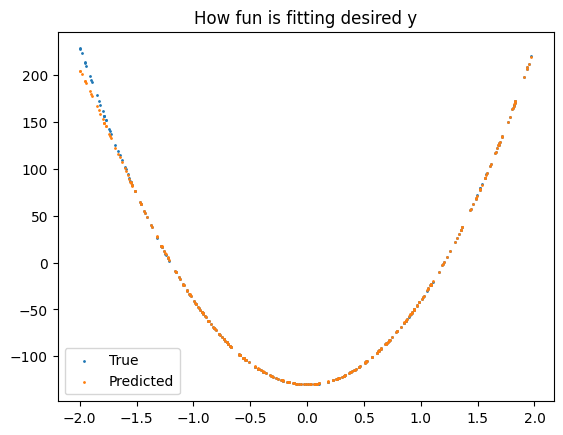

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.5840348105904303
Epoch: 251, Loss (standarized): 1.2515487250961859
Epoch: 501, Loss (standarized): 1.1169044686488416
Epoch: 751, Loss (standarized): 1.7483552321994282
Epoch: 1001, Loss (standarized): 1.0362221071539166
Epoch: 1251, Loss (standarized): 1.3056332271274942
Epoch: 1501, Loss (standarized): 1.1661650642731562
Epoch: 1751, Loss (standarized): 1.2213926146211047
Epoch: 2001, Loss (standarized): 1.1323369392504097
Epoch: 2251, Loss (standarized): 1.1838670357829444
Epoch: 2501, Loss (standarized): 1.1152723564885543
Epoch: 2751, Loss (standarized): 1.098347634754239
Epoch: 3001, Loss (standarized): 1.0642277580682793
Epoch: 3251, Loss (standarized): 1.470999403317477
Epoch: 3501, Loss (standarized): 1.3026586687441148
Epoch: 3751, Loss (standarized): 1.0866486737566292
Epoch: 

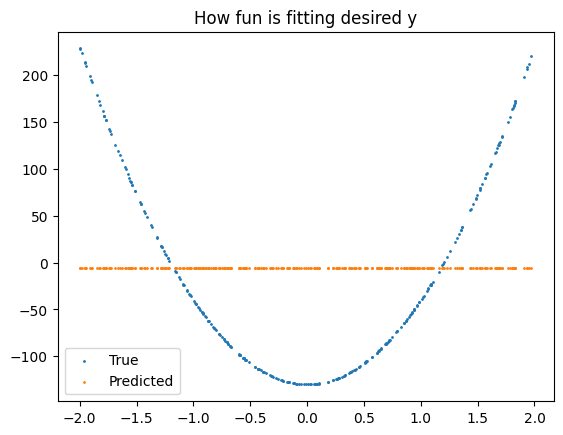

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.469104646795629
Epoch: 251, Loss (standarized): 0.0005723751374225949
Epoch: 501, Loss (standarized): 0.0003175799857906309
Epoch: 751, Loss (standarized): 0.00014260075312329617
Epoch: 1001, Loss (standarized): 6.140641787377923e-05
Epoch: 1251, Loss (standarized): 3.318577377197795e-05
Epoch: 1501, Loss (standarized): 2.1738719927467224e-05
Epoch: 1751, Loss (standarized): 1.601078571576758e-05
Epoch: 2001, Loss (standarized): 1.3908889502169583e-05
Epoch: 2251, Loss (standarized): 1.230073786695615e-05
Epoch: 2501, Loss (standarized): 1.3346141919825115e-05
Epoch: 2751, Loss (standarized): 1.1218581887630795e-05
Epoch: 3001, Loss (standarized): 1.0969255999092494e-05
Epoch: 3251, Loss (standarized): 1.2044306216401869e-05
Epoch: 3501, Loss (standarized): 1.1408160282340924e-05
Epoch: 37

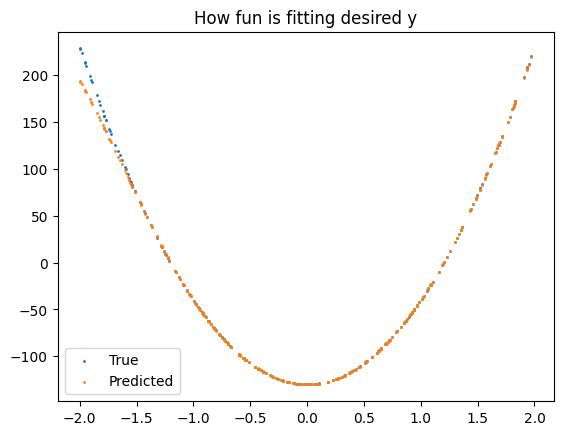

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.5099951114782284
Epoch: 251, Loss (standarized): 0.0002466664859361584
Epoch: 501, Loss (standarized): 5.825554358972477e-05
Epoch: 751, Loss (standarized): 2.610562183131923e-05
Epoch: 1001, Loss (standarized): 2.092390054027524e-05
Epoch: 1251, Loss (standarized): 2.008121958618857e-05
Epoch: 1501, Loss (standarized): 1.8643758912241346e-05
Epoch: 1751, Loss (standarized): 1.6068899966223065e-05
Epoch: 2001, Loss (standarized): 1.3771636366452256e-05
Epoch: 2251, Loss (standarized): 1.4393460344817966e-05
Epoch: 2501, Loss (standarized): 1.6230486981953876e-05
Epoch: 2751, Loss (standarized): 1.810372748319804e-05
Epoch: 3001, Loss (standarized): 1.559533078993974e-05
Epoch: 3251, Loss (standarized): 1.1701787693409017e-05
Epoch: 3501, Loss (standarized): 1.2780398554072103e-05
Epoch: 3

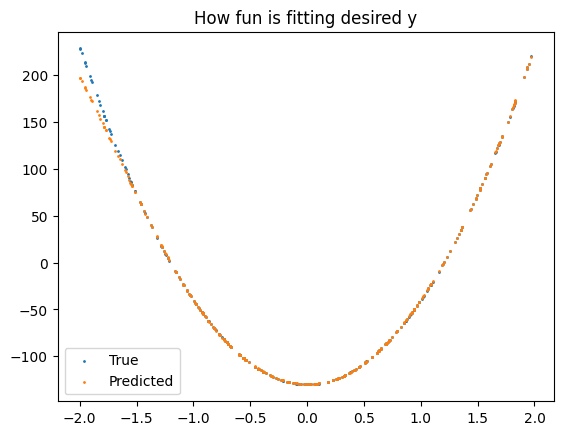

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.3516317549382078
Epoch: 251, Loss (standarized): 1.1110736365821596
Epoch: 501, Loss (standarized): 0.00010922368150780286
Epoch: 751, Loss (standarized): 1.6950698771826584e-05
Epoch: 1001, Loss (standarized): 1.0064975866132896e-05
Epoch: 1251, Loss (standarized): 3.763588977474742e-06
Epoch: 1501, Loss (standarized): 3.6616457648973804e-06
Epoch: 1751, Loss (standarized): 2.96301437232922e-06
Epoch: 2001, Loss (standarized): 3.5547056057385203e-06
Epoch: 2251, Loss (standarized): 2.317316263382328e-06
Epoch: 2501, Loss (standarized): 2.958212425534126e-06
Epoch: 2751, Loss (standarized): 2.2059138918754293e-06
Epoch: 3001, Loss (standarized): 1.7135713918788313e-06
Epoch: 3251, Loss (standarized): 2.2265147407053124e-06
Epoch: 3501, Loss (standarized): 2.9173689854516132e-06
Epoch: 375

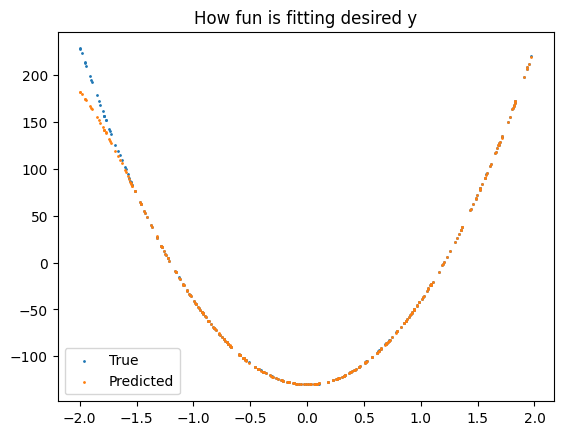

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.8024586106993392
Epoch: 251, Loss (standarized): 0.0010837915523722323
Epoch: 501, Loss (standarized): 0.0003477202180469978
Epoch: 751, Loss (standarized): 0.00018239751389205401
Epoch: 1001, Loss (standarized): 8.55714075979738e-05
Epoch: 1251, Loss (standarized): 5.2021887652707375e-05
Epoch: 1501, Loss (standarized): 3.992264749218948e-05
Epoch: 1751, Loss (standarized): 3.314324652048685e-05
Epoch: 2001, Loss (standarized): 2.9291618025818467e-05
Epoch: 2251, Loss (standarized): 2.7517865063620916e-05
Epoch: 2501, Loss (standarized): 2.5425851121525473e-05
Epoch: 2751, Loss (standarized): 2.660807070639563e-05
Epoch: 3001, Loss (standarized): 2.4990407880953113e-05
Epoch: 3251, Loss (standarized): 2.319794714067011e-05
Epoch: 3501, Loss (standarized): 2.317278735712162e-05
Epoch: 3751

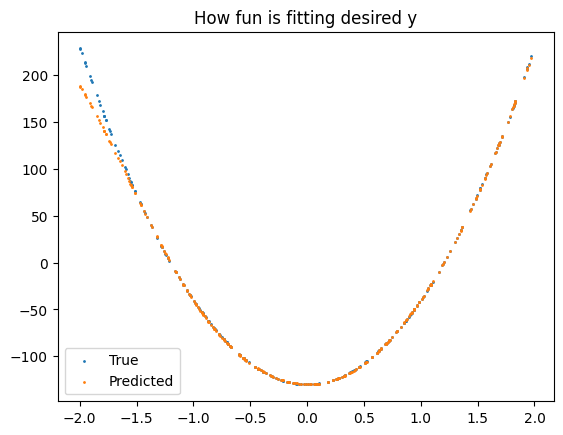

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.6229380522376058
Epoch: 251, Loss (standarized): 0.00045000234784577813
Epoch: 501, Loss (standarized): 0.00014664155971791826
Epoch: 751, Loss (standarized): 5.9903806322962974e-05
Epoch: 1001, Loss (standarized): 3.217373499800698e-05
Epoch: 1251, Loss (standarized): 2.364752014698036e-05
Epoch: 1501, Loss (standarized): 2.0707215208552768e-05
Epoch: 1751, Loss (standarized): 1.876590127618787e-05
Epoch: 2001, Loss (standarized): 1.909346541939356e-05
Epoch: 2251, Loss (standarized): 2.0077580037512705e-05
Epoch: 2501, Loss (standarized): 1.6652902429200376e-05
Epoch: 2751, Loss (standarized): 1.6874149807400356e-05
Epoch: 3001, Loss (standarized): 1.5639186993163172e-05
Epoch: 3251, Loss (standarized): 1.532635920978546e-05
Epoch: 3501, Loss (standarized): 1.518943868737873e-05
Epoch: 

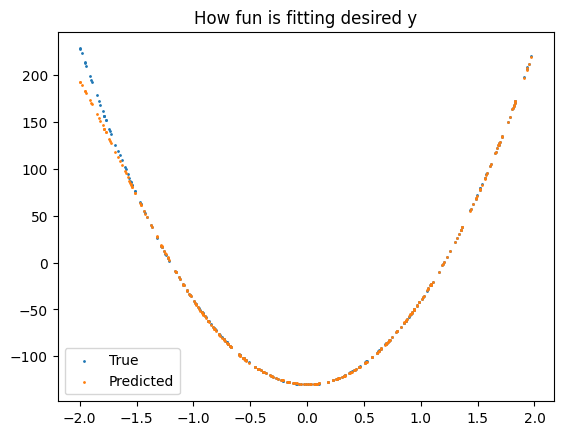

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 5.366677419450971
Epoch: 251, Loss (standarized): 1.0757875845636484
Epoch: 501, Loss (standarized): 1.0069635370568426
Epoch: 751, Loss (standarized): 1.00800054425063
Epoch: 1001, Loss (standarized): 1.0094150453189568
Epoch: 1251, Loss (standarized): 1.0076387410561505
Epoch: 1501, Loss (standarized): 1.0032803977585716
Epoch: 1751, Loss (standarized): 1.0172552637216097
Epoch: 2001, Loss (standarized): 1.0315314324587797
Epoch: 2251, Loss (standarized): 1.0319553040615923
Epoch: 2501, Loss (standarized): 1.0115135377876106
Epoch: 2751, Loss (standarized): 1.009017999353942
Epoch: 3001, Loss (standarized): 1.0316119089900078
Epoch: 3251, Loss (standarized): 1.0091557724244373
Epoch: 3501, Loss (standarized): 1.0012039632973406
Epoch: 3751, Loss (standarized): 1.0309370782342575
Epoch: 40

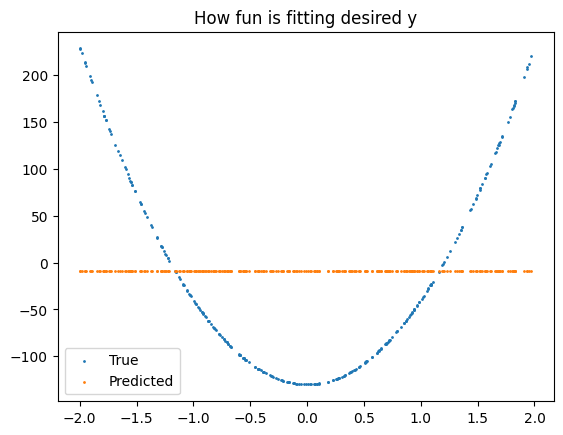

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.001815091706149
Epoch: 251, Loss (standarized): 0.023449222213231865
Epoch: 501, Loss (standarized): 0.001504009549717162
Epoch: 751, Loss (standarized): 0.0009988921737495854
Epoch: 1001, Loss (standarized): 0.0007142355576970668
Epoch: 1251, Loss (standarized): 0.0005147658677180271
Epoch: 1501, Loss (standarized): 0.0003812800141697987
Epoch: 1751, Loss (standarized): 0.00027078489173983317
Epoch: 2001, Loss (standarized): 0.00020066186531803737
Epoch: 2251, Loss (standarized): 0.0001425917809081278
Epoch: 2501, Loss (standarized): 9.821511373073965e-05
Epoch: 2751, Loss (standarized): 7.594514960435848e-05
Epoch: 3001, Loss (standarized): 5.9527331303467876e-05
Epoch: 3251, Loss (standarized): 4.8053854656289386e-05
Epoch: 3501, Loss (standarized): 4.1504613640755106e-05
Epoch: 3751, 

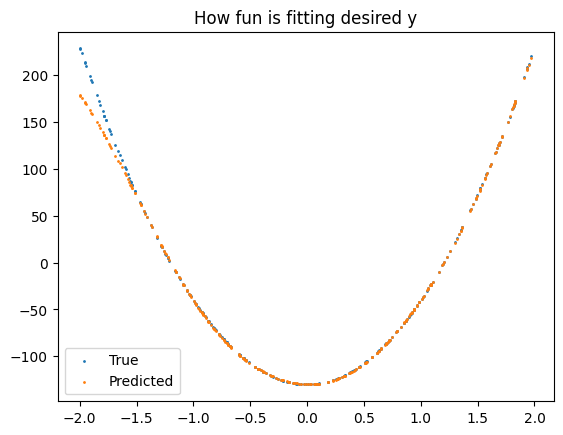

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.2962207955152345
Epoch: 251, Loss (standarized): 0.0014587592141746951
Epoch: 501, Loss (standarized): 0.0006913131471710668
Epoch: 751, Loss (standarized): 0.00041832862968611123
Epoch: 1001, Loss (standarized): 0.00023031049651497725
Epoch: 1251, Loss (standarized): 0.00014827269687221932
Epoch: 1501, Loss (standarized): 7.510858847022635e-05
Epoch: 1751, Loss (standarized): 4.696883924136524e-05
Epoch: 2001, Loss (standarized): 3.4799142852577e-05
Epoch: 2251, Loss (standarized): 2.7607483756533504e-05
Epoch: 2501, Loss (standarized): 2.716938233016943e-05
Epoch: 2751, Loss (standarized): 2.332148587340355e-05
Epoch: 3001, Loss (standarized): 2.2344788431919488e-05
Epoch: 3251, Loss (standarized): 2.2303291676615775e-05
Epoch: 3501, Loss (standarized): 2.136457895071073e-05
Epoch: 375

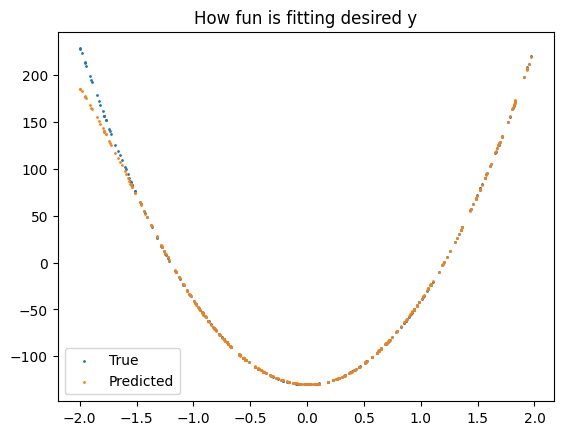

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.691103492827626
Epoch: 251, Loss (standarized): 1.0390394794459237
Epoch: 501, Loss (standarized): 1.0186500638380613
Epoch: 751, Loss (standarized): 1.004694720010959
Epoch: 1001, Loss (standarized): 1.0012386130635853
Epoch: 1251, Loss (standarized): 1.0197591507811592
Epoch: 1501, Loss (standarized): 1.0109932572911509
Epoch: 1751, Loss (standarized): 0.0006699278310847081
Epoch: 2001, Loss (standarized): 0.00021895612376188724
Epoch: 2251, Loss (standarized): 8.002144640804298e-05
Epoch: 2501, Loss (standarized): 5.1652102015146086e-05
Epoch: 2751, Loss (standarized): 3.922867893797511e-05
Epoch: 3001, Loss (standarized): 2.7434839375859602e-05
Epoch: 3251, Loss (standarized): 2.9595427283667267e-05
Epoch: 3501, Loss (standarized): 2.420931744019912e-05
Epoch: 3751, Loss (standarized

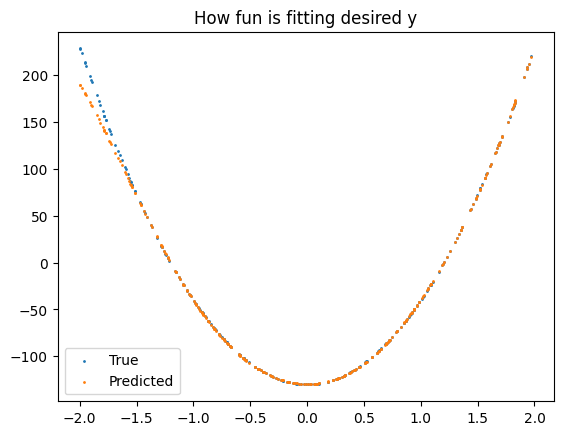

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.282896118126819
Epoch: 251, Loss (standarized): 1.0082987392498315
Epoch: 501, Loss (standarized): 0.9822905832780716
Epoch: 751, Loss (standarized): 0.014550665259348994
Epoch: 1001, Loss (standarized): 0.0016802220825444152
Epoch: 1251, Loss (standarized): 0.0010989751693072126
Epoch: 1501, Loss (standarized): 0.0008852370210748462
Epoch: 1751, Loss (standarized): 0.0007463307857787494
Epoch: 2001, Loss (standarized): 0.0006599119682951371
Epoch: 2251, Loss (standarized): 0.0005823056104630936
Epoch: 2501, Loss (standarized): 0.0005211574747709425
Epoch: 2751, Loss (standarized): 0.00047568917294987394
Epoch: 3001, Loss (standarized): 0.00042204550821994797
Epoch: 3251, Loss (standarized): 0.00038528167514299523
Epoch: 3501, Loss (standarized): 0.00034938104087296664
Epoch: 3751, Loss (

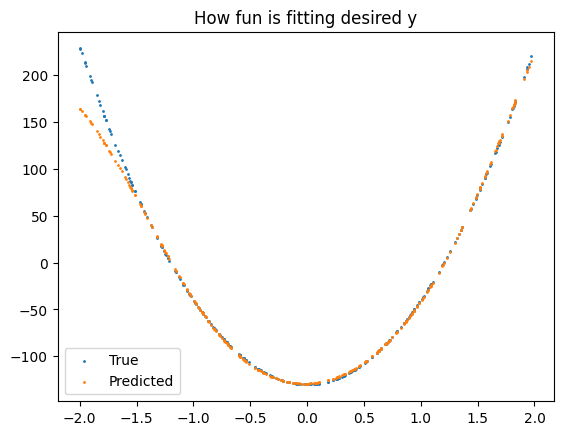

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.8590555486250775
Epoch: 251, Loss (standarized): 1.004752402013325
Epoch: 501, Loss (standarized): 0.00787152507277163
Epoch: 751, Loss (standarized): 0.0006219142024384793
Epoch: 1001, Loss (standarized): 0.00030215352119535976
Epoch: 1251, Loss (standarized): 0.0001841895654941417
Epoch: 1501, Loss (standarized): 0.00012697945350512591
Epoch: 1751, Loss (standarized): 9.259540680551744e-05
Epoch: 2001, Loss (standarized): 7.471061400819537e-05
Epoch: 2251, Loss (standarized): 6.486835871076174e-05
Epoch: 2501, Loss (standarized): 5.3927074010071855e-05
Epoch: 2751, Loss (standarized): 4.8643840123820977e-05
Epoch: 3001, Loss (standarized): 4.602371113410754e-05
Epoch: 3251, Loss (standarized): 4.372078268064309e-05
Epoch: 3501, Loss (standarized): 4.1120481600840566e-05
Epoch: 3751, Lo

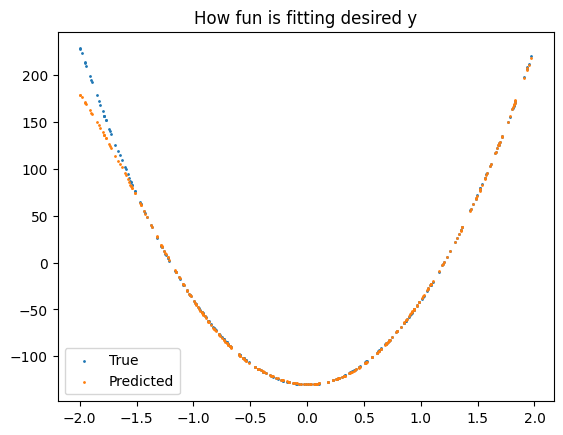

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.579135583186562
Epoch: 251, Loss (standarized): 0.001919350080584825
Epoch: 501, Loss (standarized): 0.0006416444689890636
Epoch: 751, Loss (standarized): 0.0003978374054433606
Epoch: 1001, Loss (standarized): 0.0002452661350909237
Epoch: 1251, Loss (standarized): 0.00022366256024401696
Epoch: 1501, Loss (standarized): 8.670380193027524e-05
Epoch: 1751, Loss (standarized): 4.7571004594721856e-05
Epoch: 2001, Loss (standarized): 3.0359581272772278e-05
Epoch: 2251, Loss (standarized): 2.8434205566655162e-05
Epoch: 2501, Loss (standarized): 2.242078290440962e-05
Epoch: 2751, Loss (standarized): 2.396181824164117e-05
Epoch: 3001, Loss (standarized): 2.0210155010932324e-05
Epoch: 3251, Loss (standarized): 3.095333576142289e-05
Epoch: 3501, Loss (standarized): 2.329170954930484e-05
Epoch: 3751

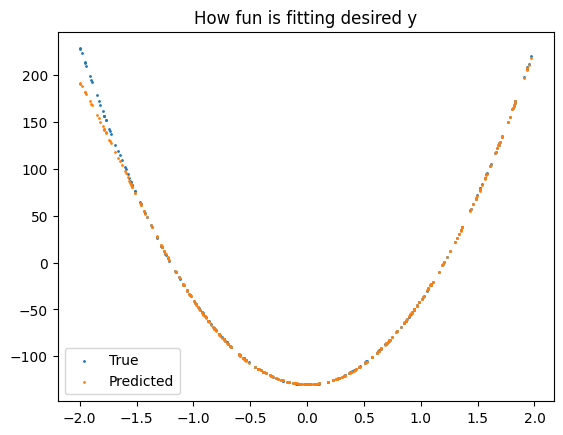

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.204392820059608
Epoch: 251, Loss (standarized): 1.0015252665391456
Epoch: 501, Loss (standarized): 0.9967547960273624
Epoch: 751, Loss (standarized): 0.9938853841017293
Epoch: 1001, Loss (standarized): 0.9583328796592199
Epoch: 1251, Loss (standarized): 0.1748406943987093
Epoch: 1501, Loss (standarized): 0.020384219958917496
Epoch: 1751, Loss (standarized): 0.00689916263600433
Epoch: 2001, Loss (standarized): 0.003717935467637631
Epoch: 2251, Loss (standarized): 0.002790486185089397
Epoch: 2501, Loss (standarized): 0.0023321444924451814
Epoch: 2751, Loss (standarized): 0.0020056189759807505
Epoch: 3001, Loss (standarized): 0.0017725340086912076
Epoch: 3251, Loss (standarized): 0.0015986720613864406
Epoch: 3501, Loss (standarized): 0.0014443810937961302
Epoch: 3751, Loss (standarized): 0.0

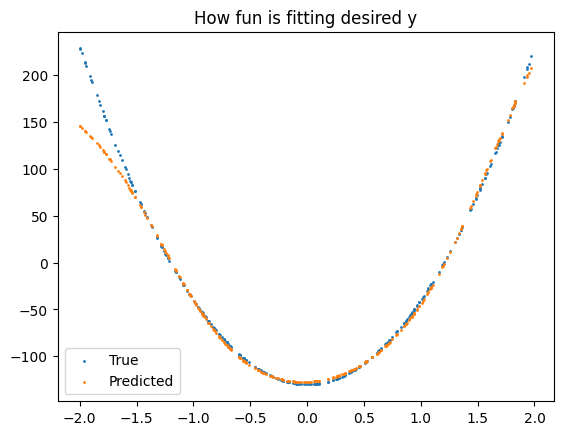

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.222096324624616
Epoch: 251, Loss (standarized): 1.0035585959912516
Epoch: 501, Loss (standarized): 1.0019016673179857
Epoch: 751, Loss (standarized): 0.9993550639230137
Epoch: 1001, Loss (standarized): 0.5341779889937555
Epoch: 1251, Loss (standarized): 0.2620839437199481
Epoch: 1501, Loss (standarized): 0.016687066300039445
Epoch: 1751, Loss (standarized): 0.0036822566254142426
Epoch: 2001, Loss (standarized): 0.002296661262407528
Epoch: 2251, Loss (standarized): 0.0017884321224467768
Epoch: 2501, Loss (standarized): 0.001504897433197325
Epoch: 2751, Loss (standarized): 0.001331360879822162
Epoch: 3001, Loss (standarized): 0.001157708670704733
Epoch: 3251, Loss (standarized): 0.0010728981647312524
Epoch: 3501, Loss (standarized): 0.0009255170623407085
Epoch: 3751, Loss (standarized): 0.

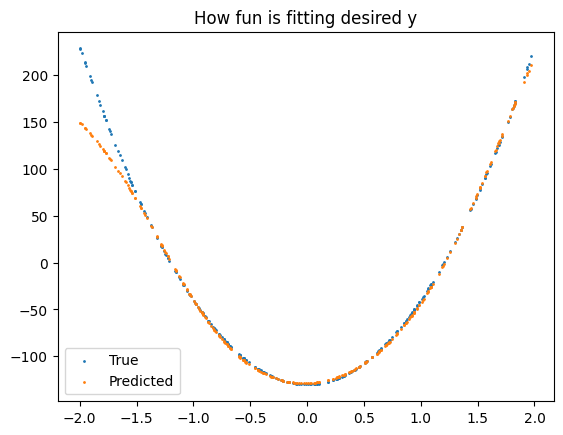

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, LAMBDA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.532056594969373
Epoch: 251, Loss (standarized): 0.0012671105514495667
Epoch: 501, Loss (standarized): 0.0006824411973133689
Epoch: 751, Loss (standarized): 0.0004581393892668799
Epoch: 1001, Loss (standarized): 0.00036156316510489733
Epoch: 1251, Loss (standarized): 0.00031287277436388195
Epoch: 1501, Loss (standarized): 0.00025536937105201157
Epoch: 1751, Loss (standarized): 0.00021867973289736974
Epoch: 2001, Loss (standarized): 0.0001960894038257427
Epoch: 2251, Loss (standarized): 0.00018554109738950483
Epoch: 2501, Loss (standarized): 0.00015814251569844958
Epoch: 2751, Loss (standarized): 0.00014146417922156408
Epoch: 3001, Loss (standarized): 0.00013947147092687213
Epoch: 3251, Loss (standarized): 0.00012572109454966058
Epoch: 3501, Loss (standarized): 0.00010818595005747854
Epoch

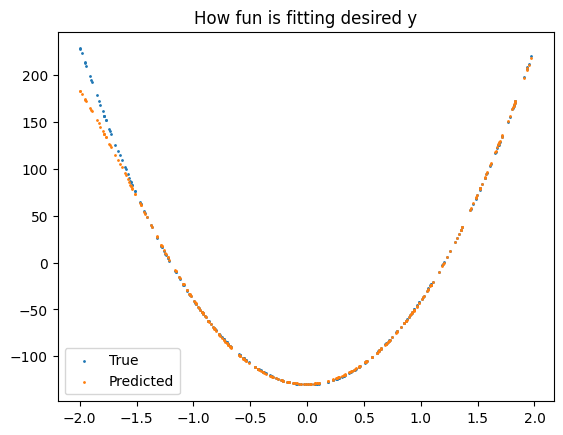

Najlepsze MSE wynosi: 9.62841149720944
Dla parametrów: lr = 0.01, lamb = 0.99
I layers: [1, 5, 5, 1]


In [102]:
architectures = [[1, 5, 1], [1, 10, 1], [1, 2, 5, 1], [1, 5, 5, 1], [1, 10, 5, 1], [1, 5, 5, 5, 1]]
lrs = [0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
lambs = [0.9, 0.95, 0.99]
best_params = None
best_arch = None
best_mse = np.inf

for arch in architectures:
    for lr in lrs:
        for lamb in lambs:
            print("---------------------------------------------------------------")
            print(f"TEST PARAMETRÓW LR = {lr}, LAMBDA = {lamb}")
            print("---------------------------------------------------------------")
            net = MLP(arch, sigmoid,sigmoid_deriv, linear, linear_deriv)
            net.train(x = x_train, y = y_train, epochs = 5000, optimizer=Momentum(lr=lr, lamb=lamb), batch_size=16)
            y_pred = net.predict(x_test)
            curr_mse = mse(y_pred, y_test)
            print(f"\nMSE wyniosło MSE wynosi: {curr_mse}")
            print("\nDLA ZBIORU TESTOWEGO")
            eval_2d(net, x_test, y_test)
            plt.show()
            if best_mse > curr_mse:
                best_mse = curr_mse
                best_params = tuple([lr, lamb])
                best_arch = arch

print(f"Najlepsze MSE wynosi: {best_mse}")
print(f"Dla parametrów: lr = {best_params[0]}, lamb = {best_params[1]}")
print(f"I layers: {best_arch}")

Ok, będzie ciężko, ogon z lewej strony jest bardzo ciężki do douczenia dla sieci

#### Kolejny dzień momentum

Epoch: 1, Loss (standarized): 1.0248027668002235
Epoch: 50001, Loss (standarized): 9.807557272463987e-07
Epoch: 100001, Loss (standarized): 2.3156583671162836e-07
Epoch: 150001, Loss (standarized): 8.74802740012607e-08
Epoch: 200001, Loss (standarized): 5.3411648489041244e-08
Epoch: 250001, Loss (standarized): 4.322941979872343e-08
Epoch: 300001, Loss (standarized): 3.930629973281145e-08
Epoch: 350001, Loss (standarized): 3.7054093623701437e-08
Epoch: 400001, Loss (standarized): 3.542743331987148e-08
Epoch: 450001, Loss (standarized): 3.446857922172427e-08
Epoch: 500001, Loss (standarized): 3.212725729607491e-08
Epoch: 550001, Loss (standarized): 3.082692218454544e-08
Epoch: 600001, Loss (standarized): 3.042237454950303e-08
Epoch: 650001, Loss (standarized): 2.871551141810264e-08
Epoch: 700001, Loss (standarized): 2.9184315279869923e-08
Epoch: 750001, Loss (standarized): 2.691649935554104e-08
Epoch: 800001, Loss (standarized): 2.6589205307609272e-08
Epoch: 850001, Loss (standarized): 2

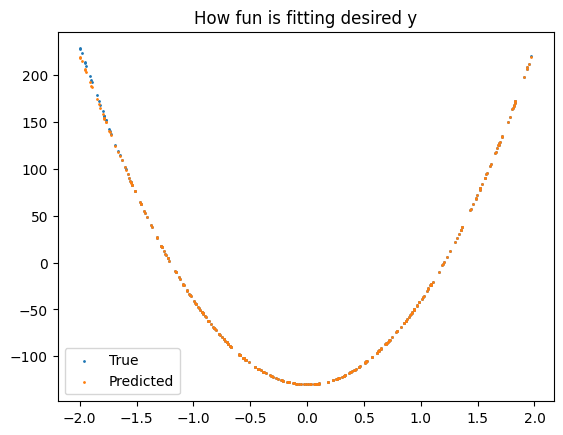

In [74]:
np.random.seed(123)
net = MLP([1, 20, 20, 1], sigmoid, sigmoid_deriv, linear, linear_deriv, init_type="xavier")
net.train(x = x_train, y = y_train, epochs = 1000000, optimizer=Momentum(lr=0.01, lamb=0.99), batch_size=128)
y_pred = net.predict(x_test)
curr_mse = mse(y_pred, y_test)
print(f"\nMSE na testowym wyniosło: {curr_mse}")
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
plt.show()

Mam nadzieję, że takie MSE wystarczy

Generalnie próbowałem ręcznie różnych lr i lambd. 
<br>
Obserwacje:
- po implementacji xavier siec uczy sie duzo stabilniej
- duża sieć potrzebuje więcej epok, ale daje to lepsze rezultaty
- im większy batch_size tym więcej epok potrzeba, ale też im większy batch_size tym szybciej są wykonywane operacje
- żeby zastosować większą lambdę(moment), potrzeba czasami zmniejszyć learning rate, żeby sieć była w stanie się uczyć
- zwiększanie ilości layerów jest bardziej kosztowne (czasowo) niż znaczne zwiększenie ilości neuronów w warstwach

#### RMSProp

UWAGA! Tu nie było jeszcze zaimplementowana inicializacja wag xavier, więc kod nie będzie działał, zostawiam jako archiwum

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, BETA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 0.8659065132426879
Epoch: 101, Loss (standarized): 0.02896925527053638
Epoch: 201, Loss (standarized): 0.024090751136413478
Epoch: 301, Loss (standarized): 0.02428692965338884
Epoch: 401, Loss (standarized): 0.024226054882667998
Epoch: 501, Loss (standarized): 0.02817463909291687
Epoch: 601, Loss (standarized): 0.02518388933672264
Epoch: 701, Loss (standarized): 0.024316877770229853
Epoch: 801, Loss (standarized): 0.022626588665881988
Epoch: 901, Loss (standarized): 0.020068865763179886
Epoch: 1001, Loss (standarized): 0.021220237288868193
Epoch: 1101, Loss (standarized): 0.026526073003014378
Epoch: 1201, Loss (standarized): 0.02188504157370073
Epoch: 1301, Loss (standarized): 0.02729625977179871
Epoch: 1401, Loss (standarized): 0.02262766496899805
Epoch: 1501, Loss (standarized): 0.02428583715

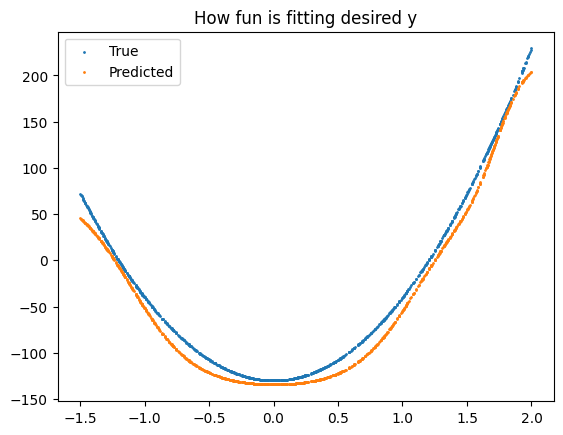


DLA ZBIORU TESTOWEGO


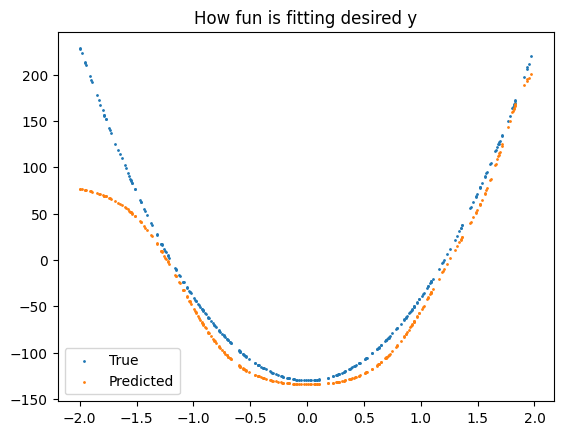


JAK WG SIECI WYGLĄDA FUNKCJA


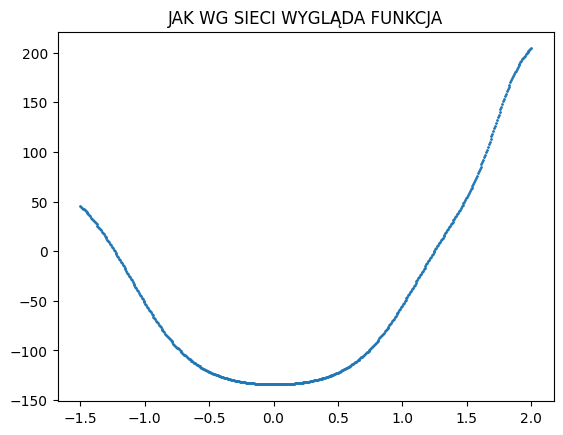

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, BETA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 0.9706112174084035
Epoch: 101, Loss (standarized): 0.013878063061370802
Epoch: 201, Loss (standarized): 0.011702696865122372
Epoch: 301, Loss (standarized): 0.008751373818675072
Epoch: 401, Loss (standarized): 0.008071251019187563
Epoch: 501, Loss (standarized): 0.007852376265265458
Epoch: 601, Loss (standarized): 0.009187189892201375
Epoch: 701, Loss (standarized): 0.009151451779193548
Epoch: 801, Loss (standarized): 0.00836310735664344
Epoch: 901, Loss (standarized): 0.008409640546247363
Epoch: 1001, Loss (standarized): 0.0069557898100882564
Epoch: 1101, Loss (standarized): 0.008164515800398632
Epoch: 1201, Loss (standarized): 0.008488255000952523
Epoch: 1301, Loss (standarized): 0.008213872707478736
Epoch: 1401, Loss (standarized): 0.008560615004762408
Epoch: 1501, Loss (standarized): 0.007

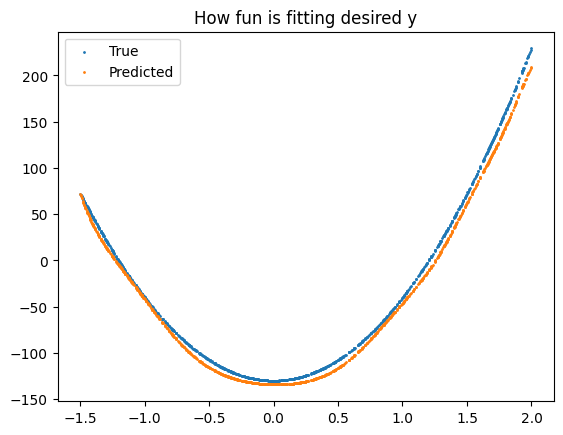


DLA ZBIORU TESTOWEGO


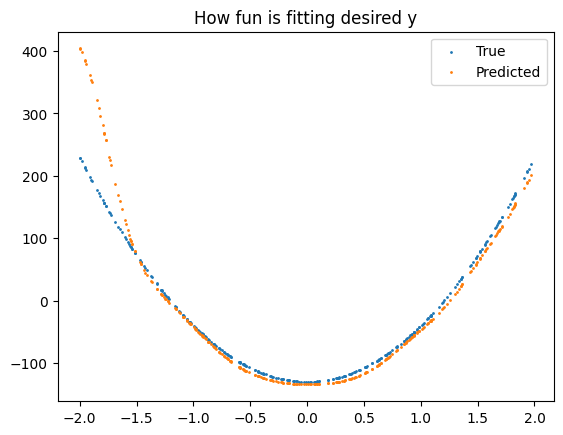


JAK WG SIECI WYGLĄDA FUNKCJA


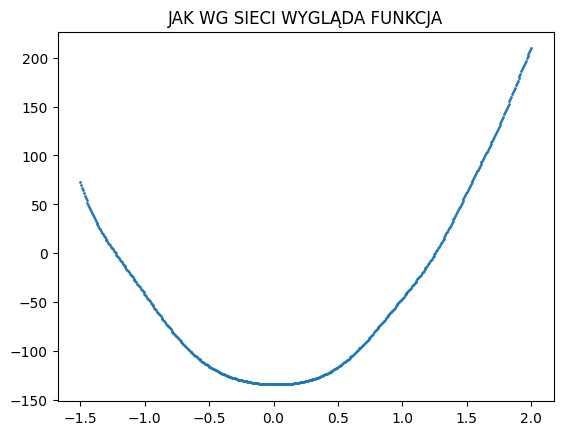

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, BETA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.8215034216664039
Epoch: 101, Loss (standarized): 0.002232121095038119
Epoch: 201, Loss (standarized): 0.002329360875120401
Epoch: 301, Loss (standarized): 0.002193717455659378
Epoch: 401, Loss (standarized): 0.0020833905467263956
Epoch: 501, Loss (standarized): 0.001991346604208801
Epoch: 601, Loss (standarized): 0.0015942910003112782
Epoch: 701, Loss (standarized): 0.001689047104534744
Epoch: 801, Loss (standarized): 0.0018083470904476863
Epoch: 901, Loss (standarized): 0.0016983318925371772
Epoch: 1001, Loss (standarized): 0.0015229793549472383
Epoch: 1101, Loss (standarized): 0.0014375438557805865
Epoch: 1201, Loss (standarized): 0.0016033531451290553
Epoch: 1301, Loss (standarized): 0.0014195178478891843
Epoch: 1401, Loss (standarized): 0.0014985380058823424
Epoch: 1501, Loss (standarize

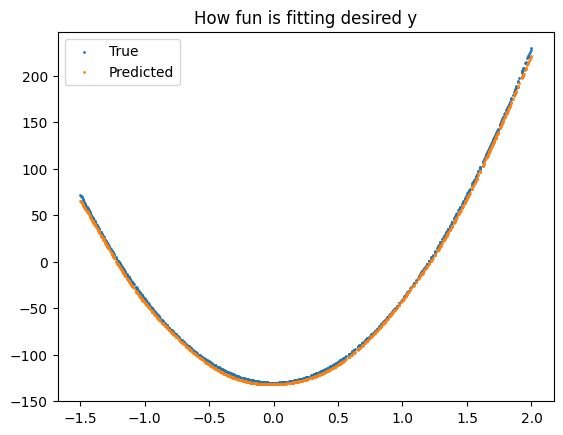


DLA ZBIORU TESTOWEGO


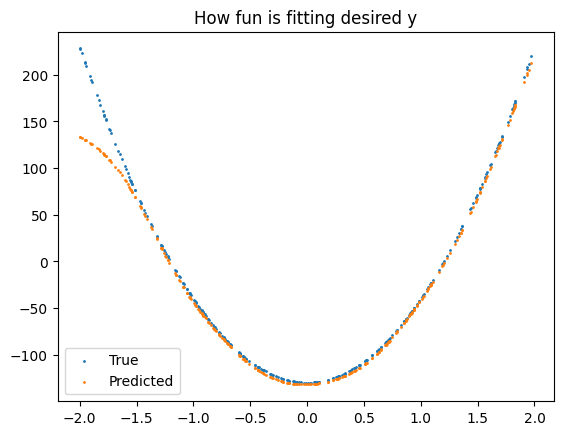


JAK WG SIECI WYGLĄDA FUNKCJA


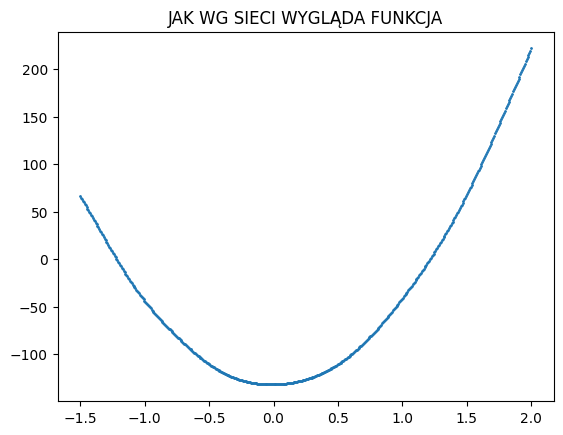

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, BETA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.5370168926432057
Epoch: 101, Loss (standarized): 0.0011533575966597074
Epoch: 201, Loss (standarized): 0.0008881555833344678
Epoch: 301, Loss (standarized): 0.0008525146156471544
Epoch: 401, Loss (standarized): 0.0007757053229468168
Epoch: 501, Loss (standarized): 0.0007473104075250636
Epoch: 601, Loss (standarized): 0.0006171383207391541
Epoch: 701, Loss (standarized): 0.0005570803532612767
Epoch: 801, Loss (standarized): 0.0006437229134091168
Epoch: 901, Loss (standarized): 0.0006276796060750045
Epoch: 1001, Loss (standarized): 0.0006377399434150413
Epoch: 1101, Loss (standarized): 0.0005255236056107519
Epoch: 1201, Loss (standarized): 0.0005626252043864716
Epoch: 1301, Loss (standarized): 0.0007135344561114127
Epoch: 1401, Loss (standarized): 0.0006334235254822081
Epoch: 1501, Loss (stand

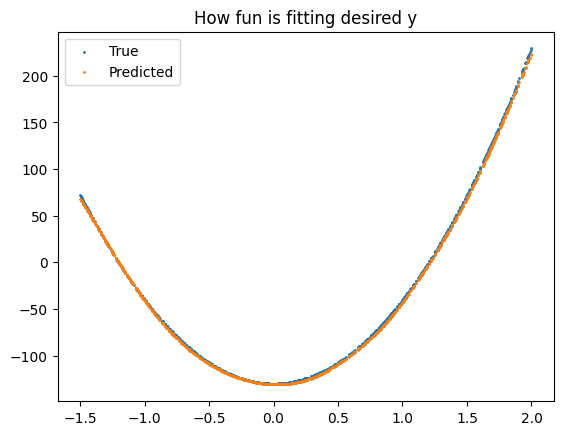


DLA ZBIORU TESTOWEGO


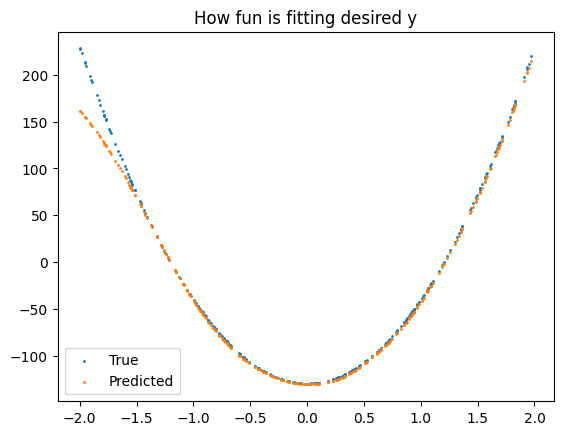


JAK WG SIECI WYGLĄDA FUNKCJA


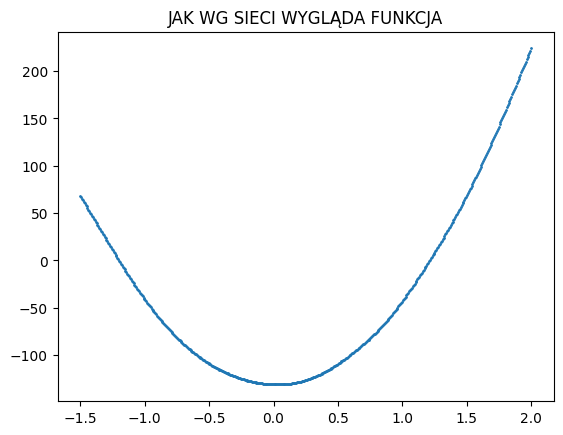

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, BETA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 3.562347829275351
Epoch: 101, Loss (standarized): 0.001115848263905785
Epoch: 201, Loss (standarized): 0.000629380355400899
Epoch: 301, Loss (standarized): 0.00032239081700607795
Epoch: 401, Loss (standarized): 0.0003019038939604233
Epoch: 501, Loss (standarized): 0.00026096515644756854
Epoch: 601, Loss (standarized): 0.00027313596530730033
Epoch: 701, Loss (standarized): 0.00021713385501035323
Epoch: 801, Loss (standarized): 0.00020239844431457426
Epoch: 901, Loss (standarized): 0.0002540588174887252
Epoch: 1001, Loss (standarized): 0.00020780049771562835
Epoch: 1101, Loss (standarized): 0.00020668358919502872
Epoch: 1201, Loss (standarized): 0.00023625731855911002
Epoch: 1301, Loss (standarized): 0.0001643325216736487
Epoch: 1401, Loss (standarized): 0.00017411718319860649
Epoch: 1501, Loss

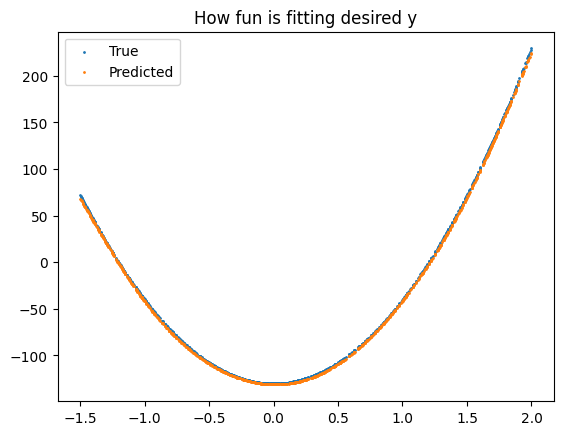


DLA ZBIORU TESTOWEGO


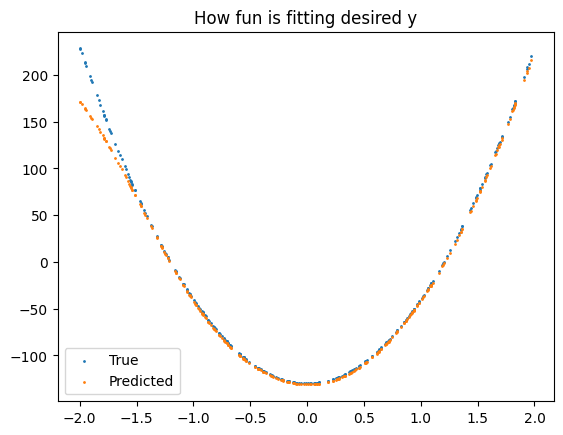


JAK WG SIECI WYGLĄDA FUNKCJA


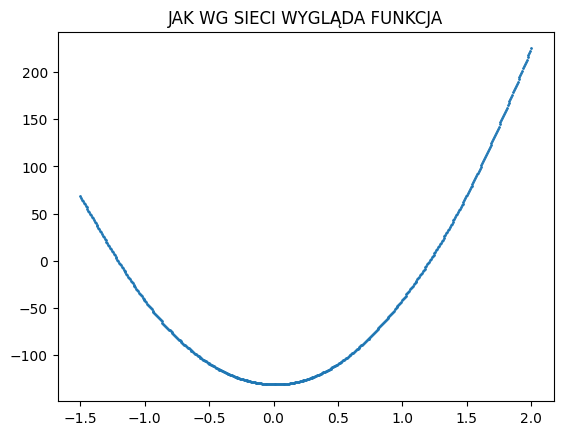

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, BETA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 10.330859481246572
Epoch: 101, Loss (standarized): 0.033278479838009016
Epoch: 201, Loss (standarized): 0.0009144838028390095
Epoch: 301, Loss (standarized): 0.0006370336300907109
Epoch: 401, Loss (standarized): 0.0004744037378827736
Epoch: 501, Loss (standarized): 0.000332432943105337
Epoch: 601, Loss (standarized): 0.00021832850436909377
Epoch: 701, Loss (standarized): 0.00015576616599921448
Epoch: 801, Loss (standarized): 0.0001356097619098438
Epoch: 901, Loss (standarized): 0.0001241283202600859
Epoch: 1001, Loss (standarized): 0.00011472087264463461
Epoch: 1101, Loss (standarized): 0.00010301835531965103
Epoch: 1201, Loss (standarized): 9.686238581423837e-05
Epoch: 1301, Loss (standarized): 9.617333173850768e-05
Epoch: 1401, Loss (standarized): 9.550591424139353e-05
Epoch: 1501, Loss (st

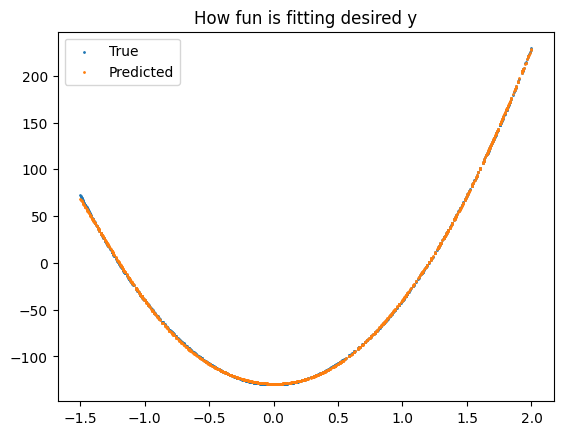


DLA ZBIORU TESTOWEGO


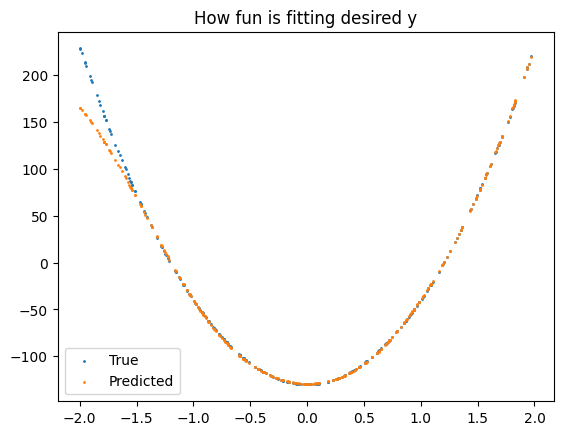


JAK WG SIECI WYGLĄDA FUNKCJA


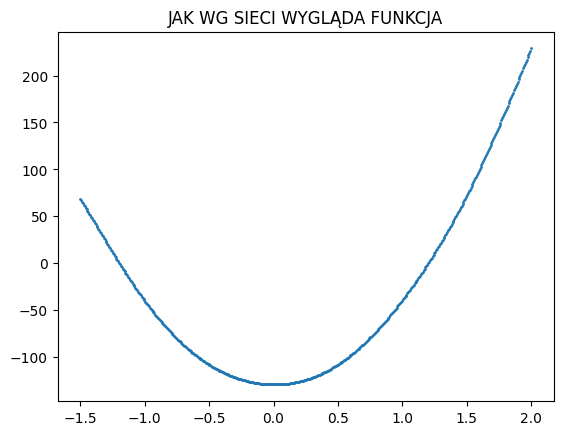

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, BETA = 0.9
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 9.00602703704928
Epoch: 101, Loss (standarized): 0.20348188791225058
Epoch: 201, Loss (standarized): 0.00934988271812467
Epoch: 301, Loss (standarized): 0.0011002176499346839
Epoch: 401, Loss (standarized): 0.0007269424671496065
Epoch: 501, Loss (standarized): 0.0006254081307735033
Epoch: 601, Loss (standarized): 0.0005520236710617722
Epoch: 701, Loss (standarized): 0.0004960328094617344
Epoch: 801, Loss (standarized): 0.0004432191828699157
Epoch: 901, Loss (standarized): 0.0004070304876472818
Epoch: 1001, Loss (standarized): 0.00035940398743181877
Epoch: 1101, Loss (standarized): 0.00032408693663987147
Epoch: 1201, Loss (standarized): 0.0002933604044447134
Epoch: 1301, Loss (standarized): 0.0002599457326009584
Epoch: 1401, Loss (standarized): 0.0002279186339769061
Epoch: 1501, Loss (standari

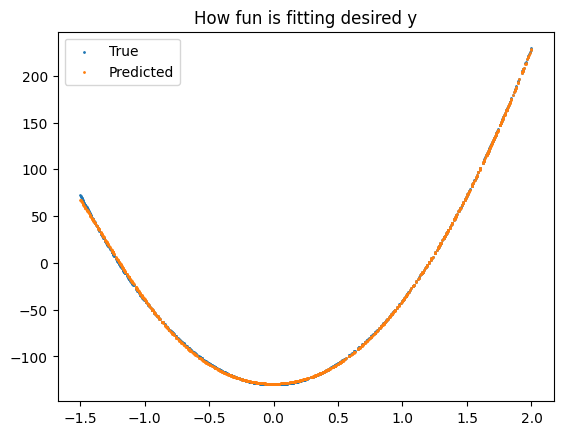


DLA ZBIORU TESTOWEGO


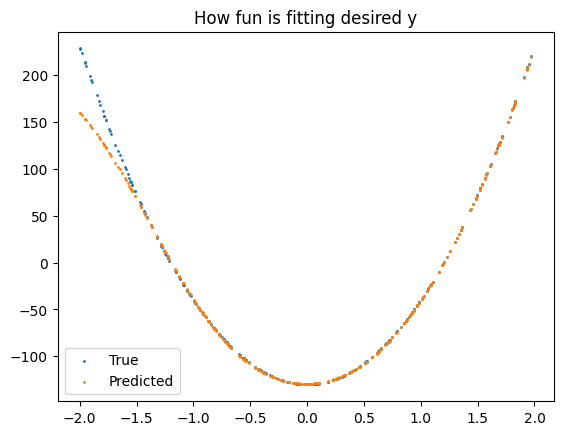


JAK WG SIECI WYGLĄDA FUNKCJA


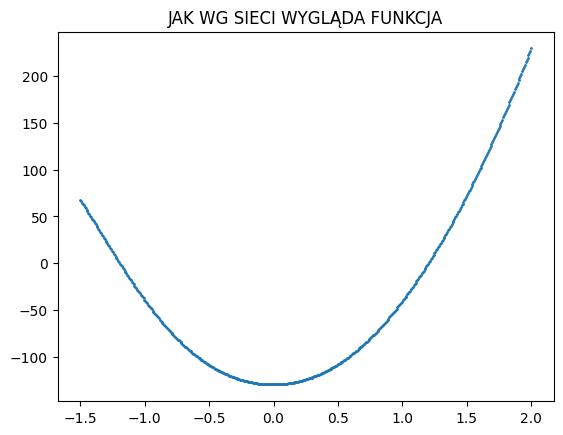

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, BETA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 0.9071798654530313
Epoch: 101, Loss (standarized): 0.02406715037248083
Epoch: 201, Loss (standarized): 0.024877899631295046
Epoch: 301, Loss (standarized): 0.02603708149950028
Epoch: 401, Loss (standarized): 0.018842772619304785
Epoch: 501, Loss (standarized): 0.020834467940560483
Epoch: 601, Loss (standarized): 0.02699576055326134
Epoch: 701, Loss (standarized): 0.015968046797554328
Epoch: 801, Loss (standarized): 0.02851209240343556
Epoch: 901, Loss (standarized): 0.019452577809284596
Epoch: 1001, Loss (standarized): 0.016845796593840563
Epoch: 1101, Loss (standarized): 0.027276730852144965
Epoch: 1201, Loss (standarized): 0.022387321756253516
Epoch: 1301, Loss (standarized): 0.024388748633889706
Epoch: 1401, Loss (standarized): 0.020790216951831655
Epoch: 1501, Loss (standarized): 0.0286089

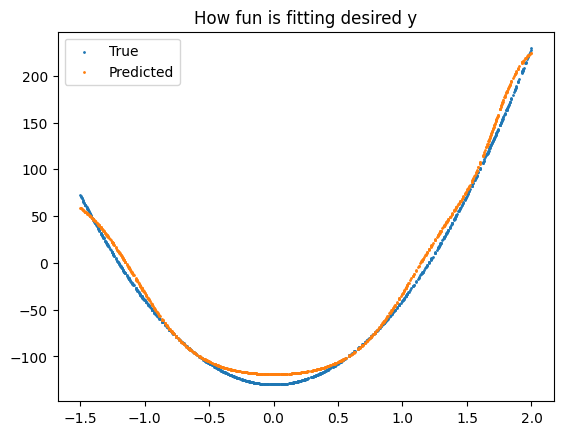


DLA ZBIORU TESTOWEGO


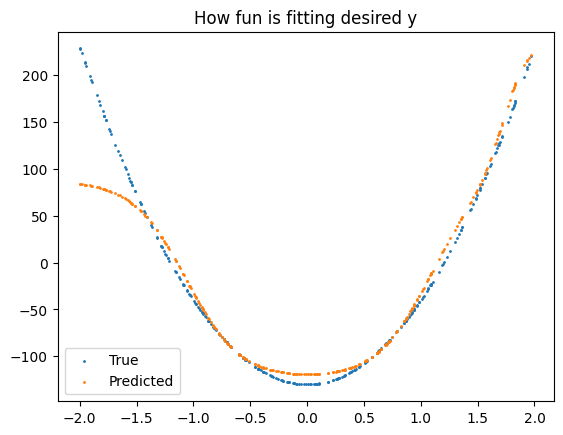


JAK WG SIECI WYGLĄDA FUNKCJA


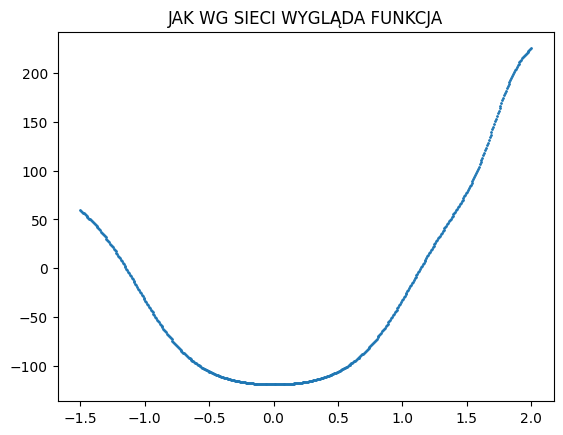

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, BETA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.3255006362184694
Epoch: 101, Loss (standarized): 0.009380391179066992
Epoch: 201, Loss (standarized): 0.006353090696222661
Epoch: 301, Loss (standarized): 0.007299902667907292
Epoch: 401, Loss (standarized): 0.005372816289962765
Epoch: 501, Loss (standarized): 0.0063537077328191995
Epoch: 601, Loss (standarized): 0.0059588726918658064
Epoch: 701, Loss (standarized): 0.004222575328741836
Epoch: 801, Loss (standarized): 0.006289968297246021
Epoch: 901, Loss (standarized): 0.007437049034649974
Epoch: 1001, Loss (standarized): 0.004422181898759481
Epoch: 1101, Loss (standarized): 0.00553272654438758
Epoch: 1201, Loss (standarized): 0.006493224179494786
Epoch: 1301, Loss (standarized): 0.004815765816080968
Epoch: 1401, Loss (standarized): 0.005241711378362148
Epoch: 1501, Loss (standarized): 0.0

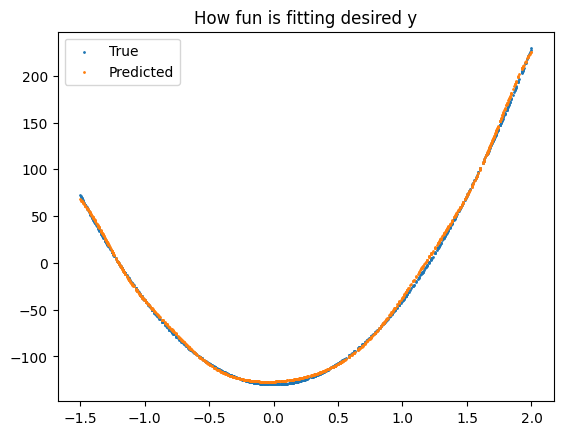


DLA ZBIORU TESTOWEGO


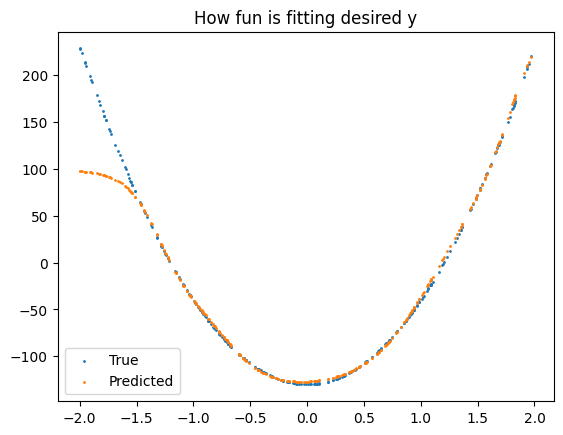


JAK WG SIECI WYGLĄDA FUNKCJA


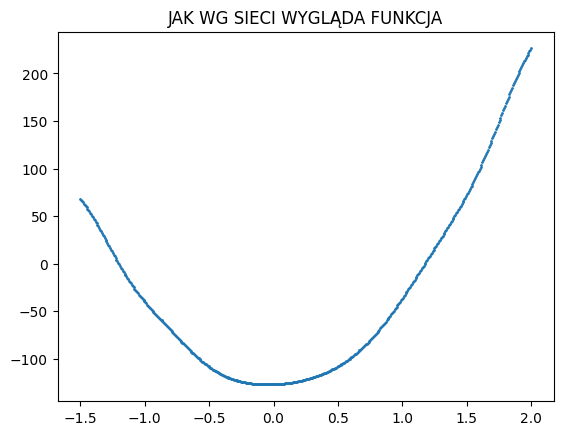

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, BETA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.6900182003950004
Epoch: 101, Loss (standarized): 0.002609469552349951
Epoch: 201, Loss (standarized): 0.001733988098650479
Epoch: 301, Loss (standarized): 0.0008777803946168994
Epoch: 401, Loss (standarized): 0.0014312533658288728
Epoch: 501, Loss (standarized): 0.0017798894901341123
Epoch: 601, Loss (standarized): 0.001321874823874884
Epoch: 701, Loss (standarized): 0.0014298710266569723
Epoch: 801, Loss (standarized): 0.0010341768216081404
Epoch: 901, Loss (standarized): 0.0020860702458698915
Epoch: 1001, Loss (standarized): 0.0018046875971312781
Epoch: 1101, Loss (standarized): 0.0010816151686863901
Epoch: 1201, Loss (standarized): 0.001282279422692277
Epoch: 1301, Loss (standarized): 0.0014294069740763784
Epoch: 1401, Loss (standarized): 0.001298648649227792
Epoch: 1501, Loss (standariz

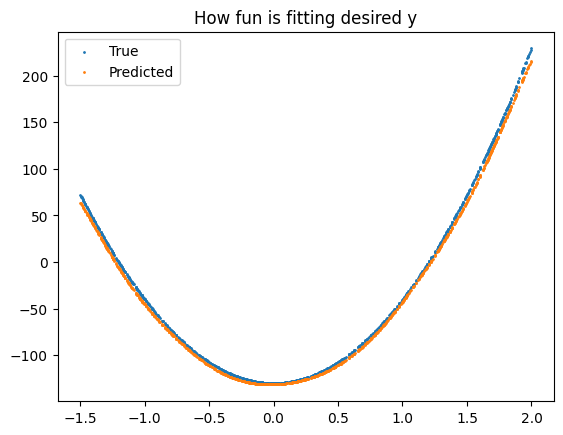


DLA ZBIORU TESTOWEGO


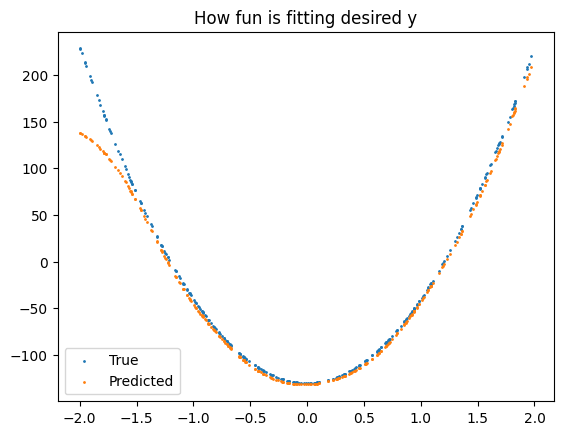


JAK WG SIECI WYGLĄDA FUNKCJA


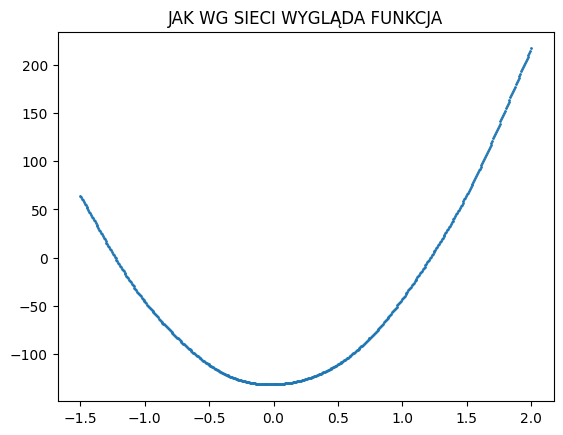

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, BETA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.1333982886235248
Epoch: 101, Loss (standarized): 0.001116743475534513
Epoch: 201, Loss (standarized): 0.00082340247693433
Epoch: 301, Loss (standarized): 0.0010693441520451227
Epoch: 401, Loss (standarized): 0.0010557003809734994
Epoch: 501, Loss (standarized): 0.0005843047747899856
Epoch: 601, Loss (standarized): 0.000832991716158327
Epoch: 701, Loss (standarized): 0.0007594944974356098
Epoch: 801, Loss (standarized): 0.0005925081674447893
Epoch: 901, Loss (standarized): 0.0006178059270924065
Epoch: 1001, Loss (standarized): 0.0009529519965359772
Epoch: 1101, Loss (standarized): 0.0007941720684767653
Epoch: 1201, Loss (standarized): 0.000667439134935684
Epoch: 1301, Loss (standarized): 0.0006393976901696981
Epoch: 1401, Loss (standarized): 0.0007373677828829582
Epoch: 1501, Loss (standariz

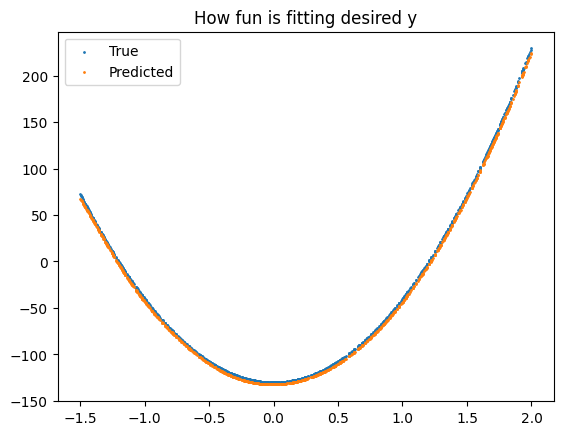


DLA ZBIORU TESTOWEGO


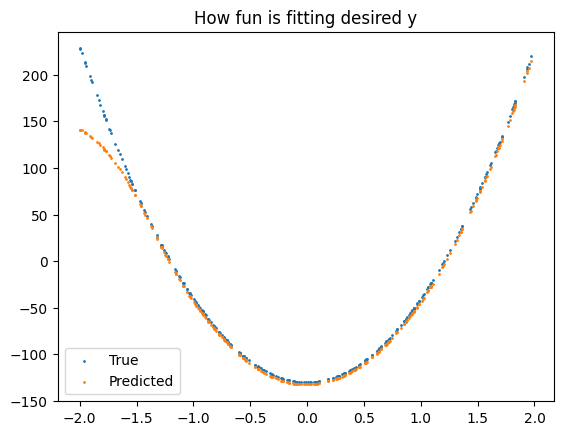


JAK WG SIECI WYGLĄDA FUNKCJA


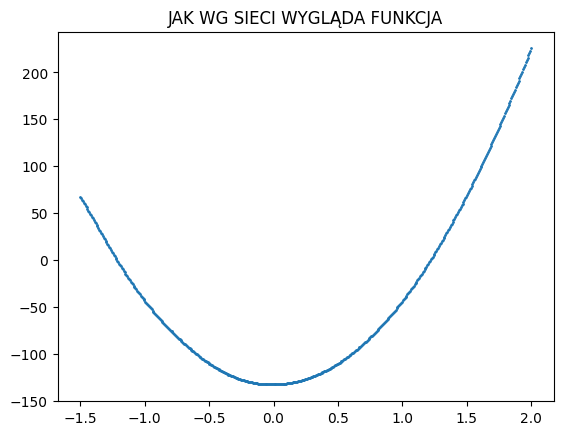

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, BETA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.763601620841654
Epoch: 101, Loss (standarized): 0.0009916551821743393
Epoch: 201, Loss (standarized): 0.0006255344667926985
Epoch: 301, Loss (standarized): 0.00044121423080622433
Epoch: 401, Loss (standarized): 0.00038224120970760085
Epoch: 501, Loss (standarized): 0.000333687886223253
Epoch: 601, Loss (standarized): 0.00034995082097968253
Epoch: 701, Loss (standarized): 0.0002531054254837259
Epoch: 801, Loss (standarized): 0.0002602224529875869
Epoch: 901, Loss (standarized): 0.00032149618764332915
Epoch: 1001, Loss (standarized): 0.00026392856167579254
Epoch: 1101, Loss (standarized): 0.0002486884866163445
Epoch: 1201, Loss (standarized): 0.00027957978410986315
Epoch: 1301, Loss (standarized): 0.00035074049149287325
Epoch: 1401, Loss (standarized): 0.0002397019539643915
Epoch: 1501, Loss

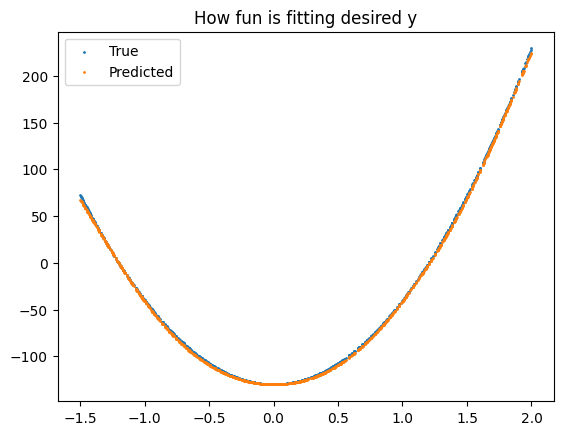


DLA ZBIORU TESTOWEGO


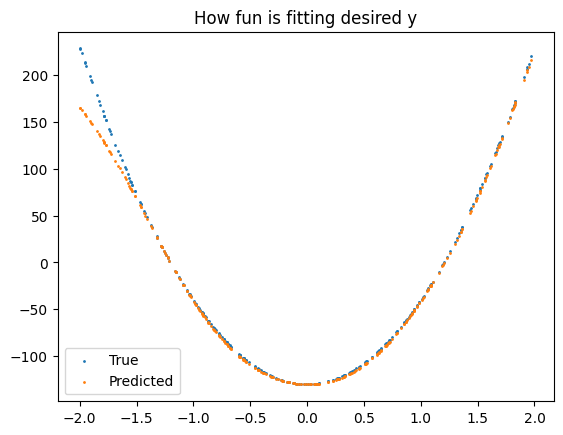


JAK WG SIECI WYGLĄDA FUNKCJA


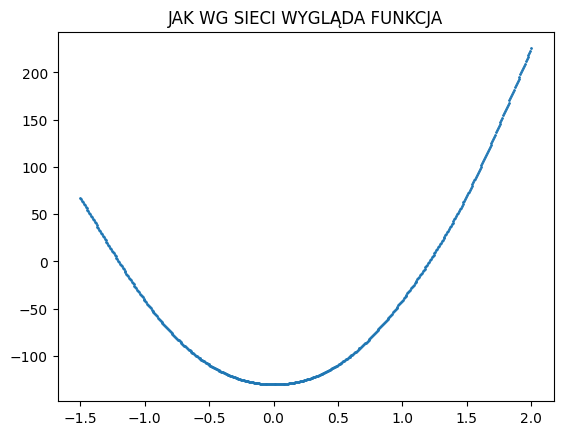

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, BETA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.040599381404085
Epoch: 101, Loss (standarized): 0.011681866300359578
Epoch: 201, Loss (standarized): 0.0005845090302273954
Epoch: 301, Loss (standarized): 0.0002680177335258453
Epoch: 401, Loss (standarized): 0.00017994738427781366
Epoch: 501, Loss (standarized): 0.00015330831644168392
Epoch: 601, Loss (standarized): 0.00014537657799592625
Epoch: 701, Loss (standarized): 0.00012739837259235755
Epoch: 801, Loss (standarized): 0.00012008378824615401
Epoch: 901, Loss (standarized): 0.00011012003896512252
Epoch: 1001, Loss (standarized): 0.00011544115395007237
Epoch: 1101, Loss (standarized): 9.883003169232265e-05
Epoch: 1201, Loss (standarized): 0.00010259546758676496
Epoch: 1301, Loss (standarized): 9.200174203595116e-05
Epoch: 1401, Loss (standarized): 0.00012278127587385035
Epoch: 1501, Lo

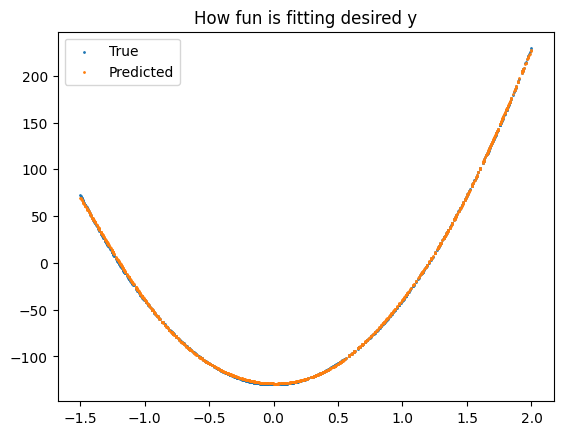


DLA ZBIORU TESTOWEGO


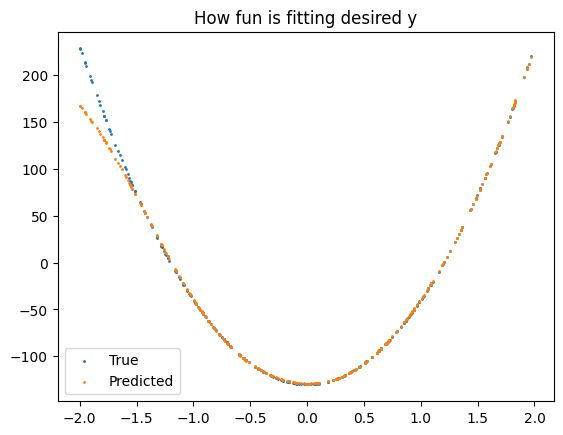


JAK WG SIECI WYGLĄDA FUNKCJA


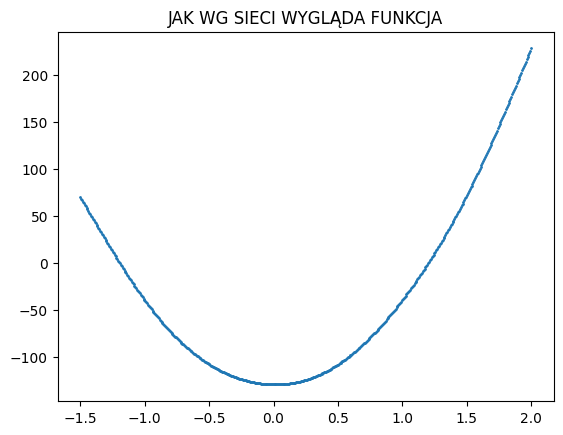

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, BETA = 0.95
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 4.296677708427424
Epoch: 101, Loss (standarized): 0.3887592214374704
Epoch: 201, Loss (standarized): 0.012243737635416417
Epoch: 301, Loss (standarized): 0.0009913806112404758
Epoch: 401, Loss (standarized): 0.0005573216514380209
Epoch: 501, Loss (standarized): 0.00040358815097865837
Epoch: 601, Loss (standarized): 0.00028843393072303607
Epoch: 701, Loss (standarized): 0.00021780295448511024
Epoch: 801, Loss (standarized): 0.00017005047961336897
Epoch: 901, Loss (standarized): 0.00014353691905700326
Epoch: 1001, Loss (standarized): 0.00013527555778523604
Epoch: 1101, Loss (standarized): 0.00012819053408253723
Epoch: 1201, Loss (standarized): 0.00011541873650086595
Epoch: 1301, Loss (standarized): 0.00010986090337878056
Epoch: 1401, Loss (standarized): 0.00010251122136582097
Epoch: 1501, Loss

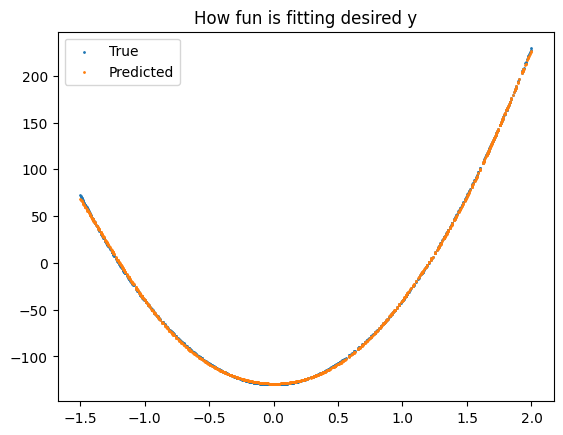


DLA ZBIORU TESTOWEGO


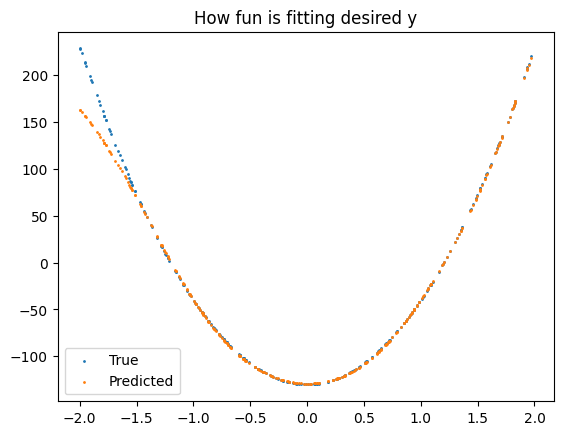


JAK WG SIECI WYGLĄDA FUNKCJA


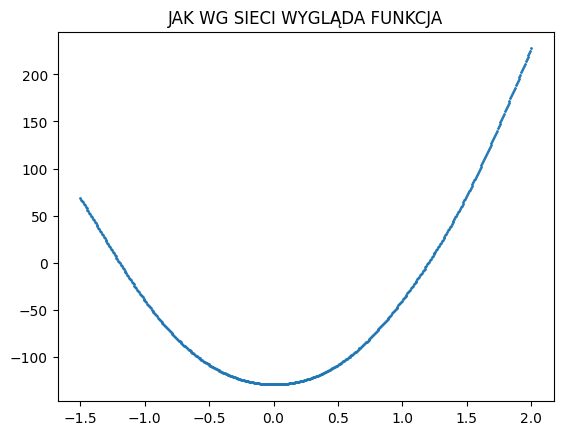

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.1, BETA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.022939311016556
Epoch: 101, Loss (standarized): 0.010752177167821363
Epoch: 201, Loss (standarized): 0.057335604063901945
Epoch: 301, Loss (standarized): 0.03143402278661943
Epoch: 401, Loss (standarized): 0.022505419469313642
Epoch: 501, Loss (standarized): 0.014310763023902238
Epoch: 601, Loss (standarized): 0.022468215283493055
Epoch: 701, Loss (standarized): 0.01763035224413235
Epoch: 801, Loss (standarized): 0.028368274008421464
Epoch: 901, Loss (standarized): 0.041948300002137395
Epoch: 1001, Loss (standarized): 0.038878452139672705
Epoch: 1101, Loss (standarized): 0.018263714577719317
Epoch: 1201, Loss (standarized): 0.005071191449751094
Epoch: 1301, Loss (standarized): 0.0035335009410637436
Epoch: 1401, Loss (standarized): 0.0076026936374229415
Epoch: 1501, Loss (standarized): 0.0318

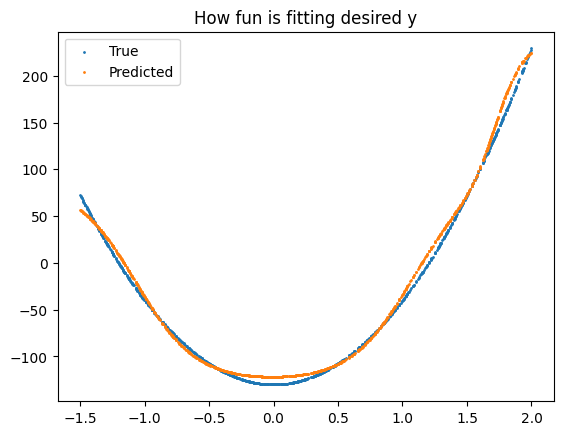


DLA ZBIORU TESTOWEGO


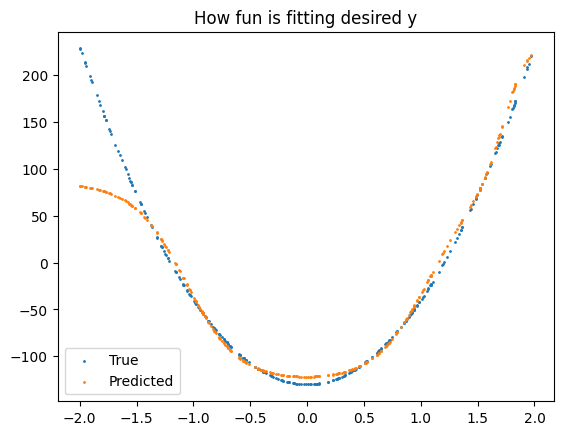


JAK WG SIECI WYGLĄDA FUNKCJA


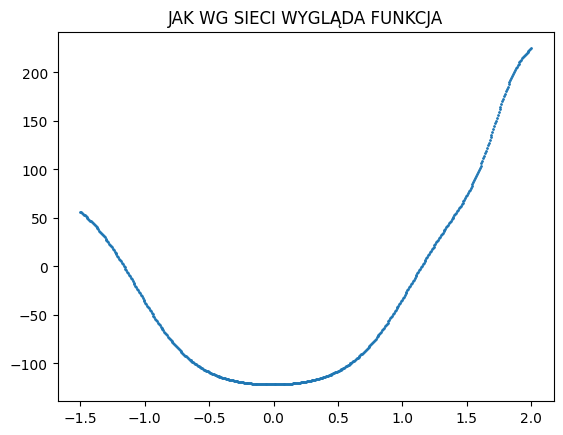

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.05, BETA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 0.7642239402879529
Epoch: 101, Loss (standarized): 0.009993617947758226
Epoch: 201, Loss (standarized): 0.015106302676405465
Epoch: 301, Loss (standarized): 0.01240163129358486
Epoch: 401, Loss (standarized): 0.004552254736640083
Epoch: 501, Loss (standarized): 0.010831987626259131
Epoch: 601, Loss (standarized): 0.01168456555291018
Epoch: 701, Loss (standarized): 0.00478256775708857
Epoch: 801, Loss (standarized): 0.010229529530109227
Epoch: 901, Loss (standarized): 0.013156639796024338
Epoch: 1001, Loss (standarized): 0.004851161191196138
Epoch: 1101, Loss (standarized): 0.007266234364704189
Epoch: 1201, Loss (standarized): 0.007382141659085509
Epoch: 1301, Loss (standarized): 0.00881664645938102
Epoch: 1401, Loss (standarized): 0.009432906440758627
Epoch: 1501, Loss (standarized): 0.008845

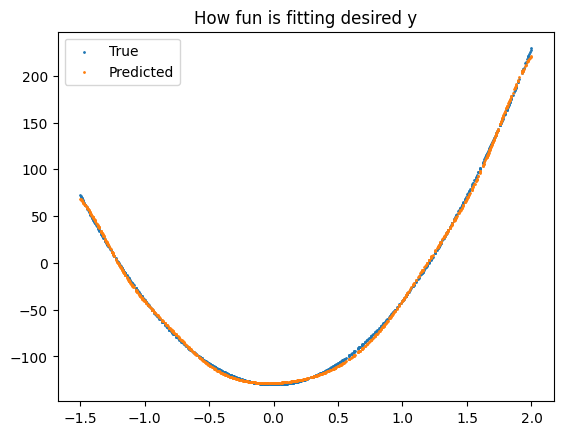


DLA ZBIORU TESTOWEGO


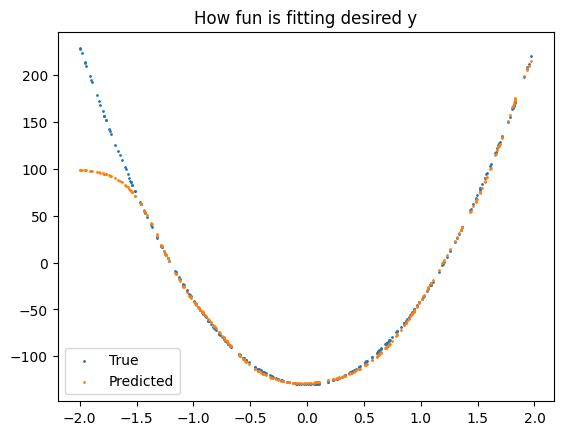


JAK WG SIECI WYGLĄDA FUNKCJA


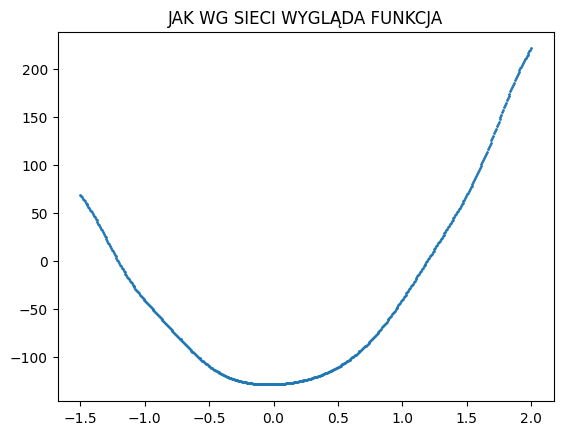

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.02, BETA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.0664860484072332
Epoch: 101, Loss (standarized): 0.0029466024731303287
Epoch: 201, Loss (standarized): 0.001677685312928933
Epoch: 301, Loss (standarized): 0.004753910651050329
Epoch: 401, Loss (standarized): 0.0038886912137318665
Epoch: 501, Loss (standarized): 0.0029969358145182368
Epoch: 601, Loss (standarized): 0.0007666850679972136
Epoch: 701, Loss (standarized): 0.0024270417431630884
Epoch: 801, Loss (standarized): 0.001493967697356919
Epoch: 901, Loss (standarized): 0.0010200906045859728
Epoch: 1001, Loss (standarized): 0.0006694995713726603
Epoch: 1101, Loss (standarized): 0.0029192820755243104
Epoch: 1201, Loss (standarized): 0.002154223673179616
Epoch: 1301, Loss (standarized): 0.0027746478301473748
Epoch: 1401, Loss (standarized): 0.0007573223732489842
Epoch: 1501, Loss (standari

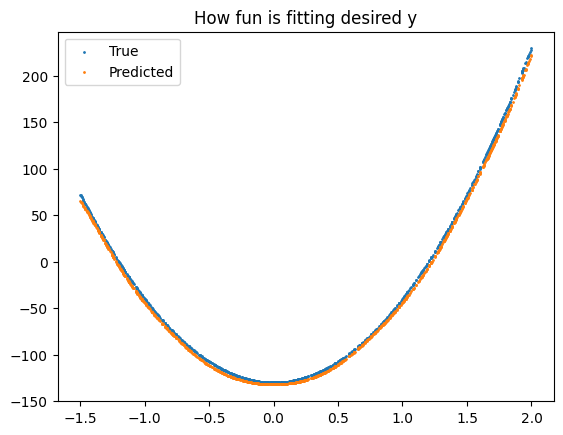


DLA ZBIORU TESTOWEGO


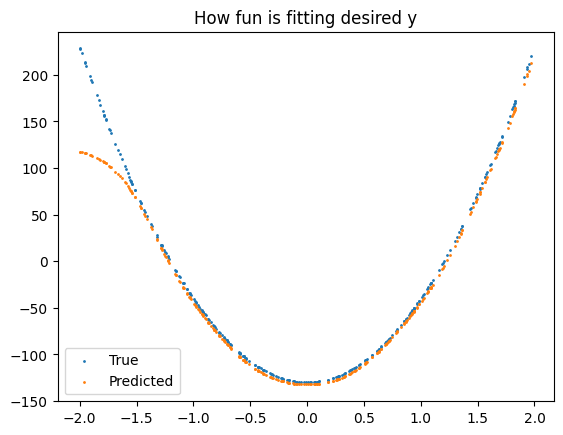


JAK WG SIECI WYGLĄDA FUNKCJA


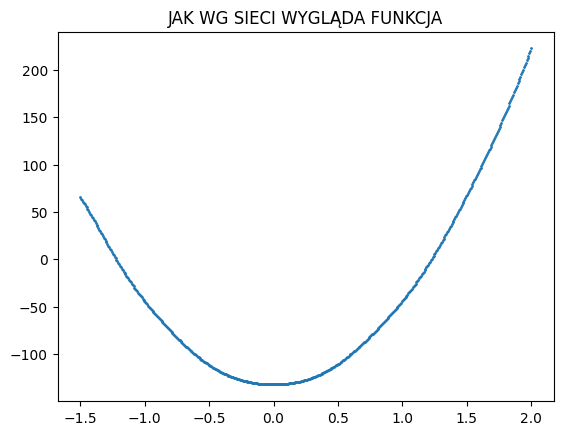

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.01, BETA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.1085605779526486
Epoch: 101, Loss (standarized): 0.00047507472452135586
Epoch: 201, Loss (standarized): 0.0006088206993457607
Epoch: 301, Loss (standarized): 0.000857931330262493
Epoch: 401, Loss (standarized): 0.0013492581854094871
Epoch: 501, Loss (standarized): 0.000734304406065988
Epoch: 601, Loss (standarized): 0.0005584636555859657
Epoch: 701, Loss (standarized): 0.0006159116056499371
Epoch: 801, Loss (standarized): 0.0006469981076291376
Epoch: 901, Loss (standarized): 0.0009323567808364382
Epoch: 1001, Loss (standarized): 0.0006137227802548971
Epoch: 1101, Loss (standarized): 0.00046451833365076416
Epoch: 1201, Loss (standarized): 0.001079355917591446
Epoch: 1301, Loss (standarized): 0.0008351509028676334
Epoch: 1401, Loss (standarized): 0.0006775504808359061
Epoch: 1501, Loss (stand

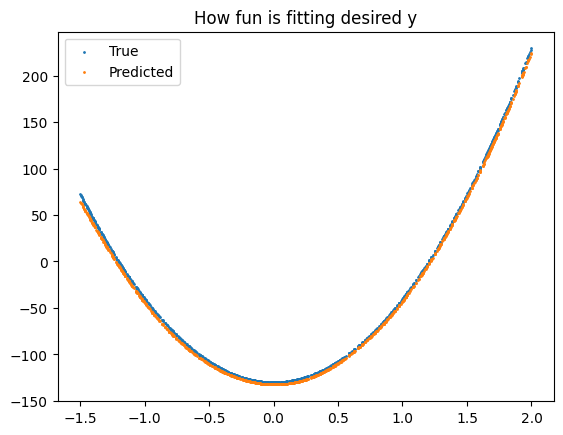


DLA ZBIORU TESTOWEGO


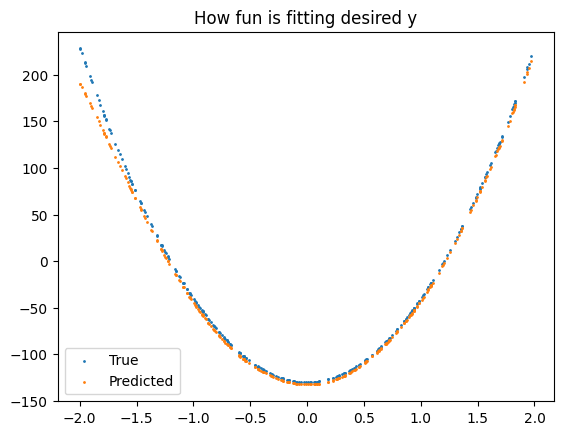


JAK WG SIECI WYGLĄDA FUNKCJA


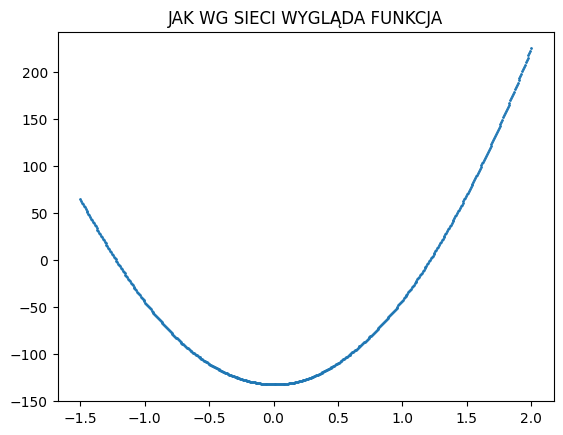

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.005, BETA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 2.021200087804695
Epoch: 101, Loss (standarized): 0.0018933654881147439
Epoch: 201, Loss (standarized): 0.0010883069317503826
Epoch: 301, Loss (standarized): 0.000707675704639917
Epoch: 401, Loss (standarized): 0.0006185562683635619
Epoch: 501, Loss (standarized): 0.00047457740027754836
Epoch: 601, Loss (standarized): 0.0005736722512777913
Epoch: 701, Loss (standarized): 0.0005475388100024221
Epoch: 801, Loss (standarized): 0.00032025618733568916
Epoch: 901, Loss (standarized): 0.000451643278073277
Epoch: 1001, Loss (standarized): 0.00017117556124952957
Epoch: 1101, Loss (standarized): 0.00024002206856808285
Epoch: 1201, Loss (standarized): 0.00012076562518814313
Epoch: 1301, Loss (standarized): 0.0003660947618062576
Epoch: 1401, Loss (standarized): 0.00031552229262902224
Epoch: 1501, Loss (

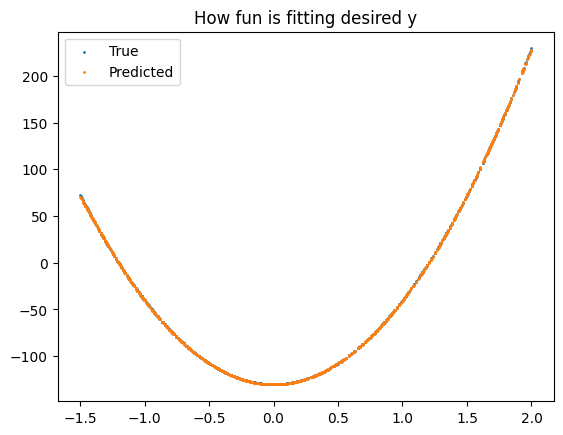


DLA ZBIORU TESTOWEGO


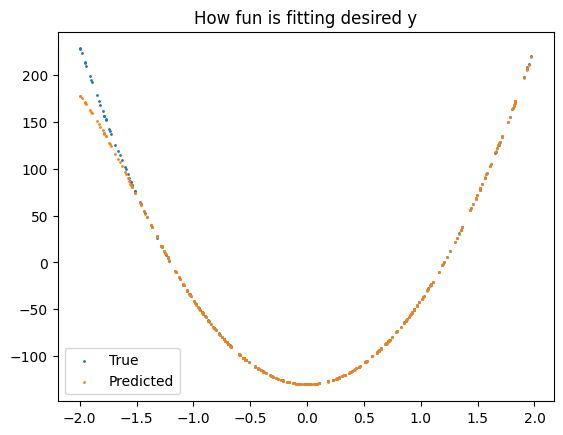


JAK WG SIECI WYGLĄDA FUNKCJA


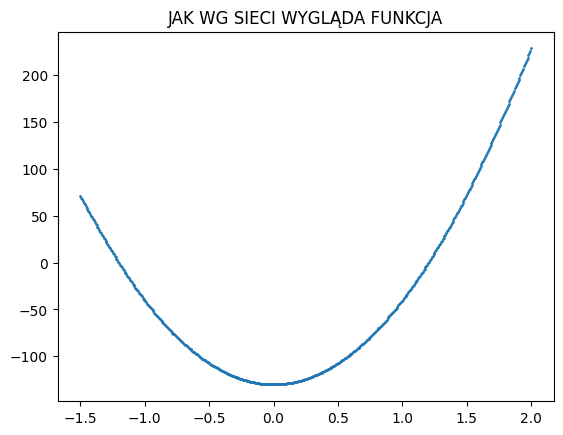

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.002, BETA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 1.4501686808316079
Epoch: 101, Loss (standarized): 0.016805447225636195
Epoch: 201, Loss (standarized): 0.0005136621007904459
Epoch: 301, Loss (standarized): 0.0002570519280723673
Epoch: 401, Loss (standarized): 0.00011833479171933603
Epoch: 501, Loss (standarized): 9.054048361045134e-05
Epoch: 601, Loss (standarized): 5.8307540763639626e-05
Epoch: 701, Loss (standarized): 6.449197125594008e-05
Epoch: 801, Loss (standarized): 4.893553322156271e-05
Epoch: 901, Loss (standarized): 6.868177696068782e-05
Epoch: 1001, Loss (standarized): 5.716009327851764e-05
Epoch: 1101, Loss (standarized): 6.186923149628934e-05
Epoch: 1201, Loss (standarized): 3.687934056547153e-05
Epoch: 1301, Loss (standarized): 4.496563540535779e-05
Epoch: 1401, Loss (standarized): 5.483713067467492e-05
Epoch: 1501, Loss (st

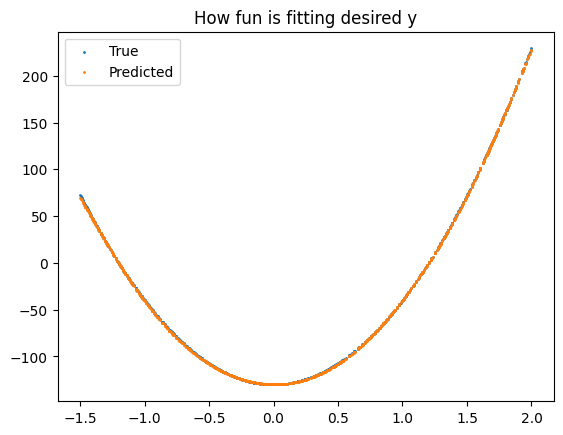


DLA ZBIORU TESTOWEGO


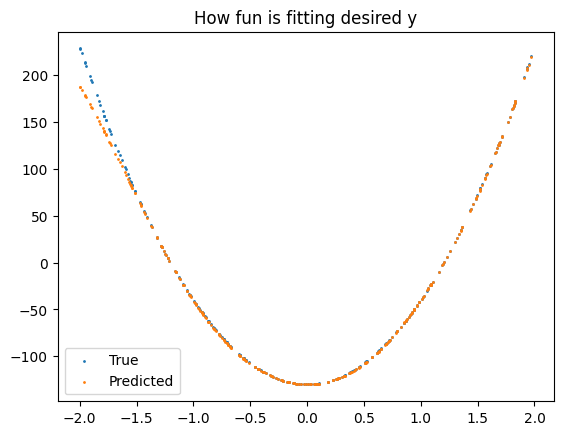


JAK WG SIECI WYGLĄDA FUNKCJA


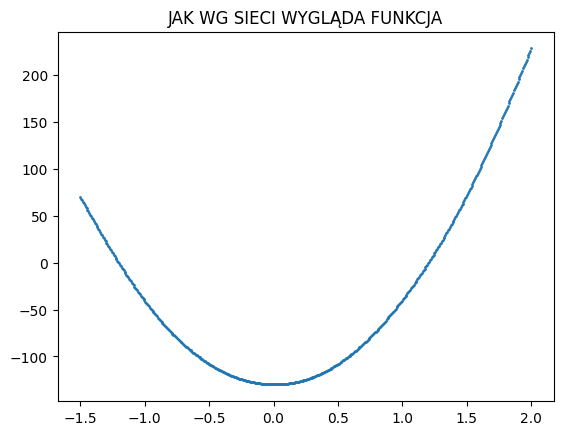

---------------------------------------------------------------
TEST PARAMETRÓW LR = 0.001, BETA = 0.99
---------------------------------------------------------------
Epoch: 1, Loss (standarized): 5.298736512878926
Epoch: 101, Loss (standarized): 0.32115459095784
Epoch: 201, Loss (standarized): 0.01422305058960745
Epoch: 301, Loss (standarized): 0.0009439087877344801
Epoch: 401, Loss (standarized): 0.0002629359419488529
Epoch: 501, Loss (standarized): 0.0001688997981738044
Epoch: 601, Loss (standarized): 0.00011130730524004474
Epoch: 701, Loss (standarized): 7.64456437036688e-05
Epoch: 801, Loss (standarized): 5.46853354353454e-05
Epoch: 901, Loss (standarized): 4.0982846034041464e-05
Epoch: 1001, Loss (standarized): 3.2203951868971715e-05
Epoch: 1101, Loss (standarized): 3.372799663348841e-05
Epoch: 1201, Loss (standarized): 2.2276711614339078e-05
Epoch: 1301, Loss (standarized): 1.8094904141685657e-05
Epoch: 1401, Loss (standarized): 2.191075483040985e-05
Epoch: 1501, Loss (standari

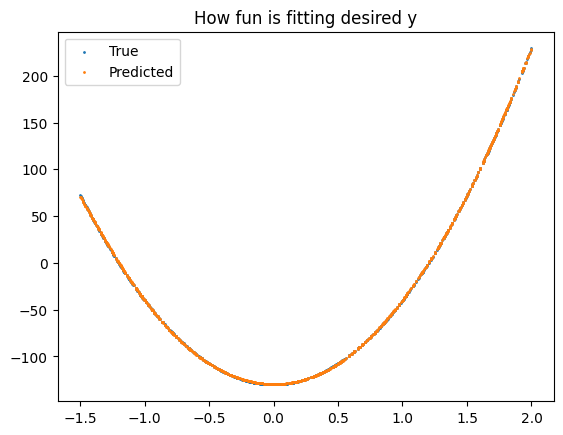


DLA ZBIORU TESTOWEGO


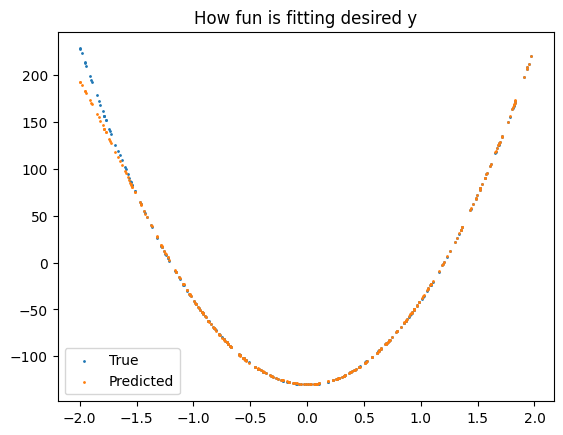


JAK WG SIECI WYGLĄDA FUNKCJA


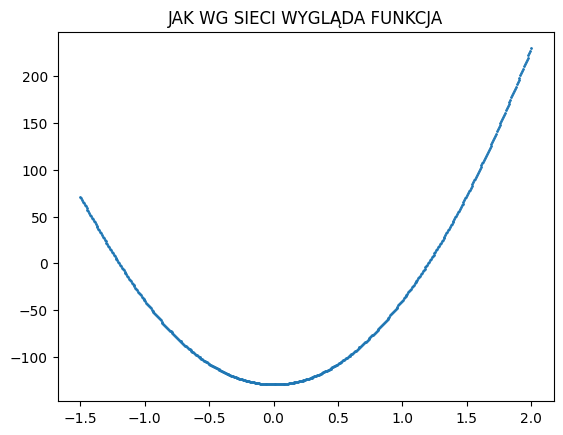

Najlepsze MSE wynosi: 36.44181616624609
Dla parametrów: lr = 0.001, lamb = 0.99


In [31]:
params={"lr":   [0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001],
        "beta": [0.9, 0.9,  0.9,  0.9,  0.9,   0.9,   0.9,   0.95,0.95, 0.95, 0.95, 0.95,  0.95,  0.95,  0.99,0.99, 0.99, 0.99, 0.99,  0.99,  0.99],}

best_params = (0, 0)
best_mse = np.inf
for i in range(len(params['lr'])):
    print("---------------------------------------------------------------")
    print(f"TEST PARAMETRÓW LR = {params["lr"][i]}, BETA = {params["beta"][i]}")
    print("---------------------------------------------------------------")
    net = MLP([1, 5, 1], sigmoid,sigmoid_deriv, linear, linear_deriv)
    net.train(x = x_train, y = y_train, epochs = 2000, optimizer=RMSProp(lr=params["lr"][i], beta=params["beta"][i]), batch_size=32)
    y_pred = net.predict(x_test)
    curr_mse = mse(y_pred, y_test)
    print(f"\nMSE wyniosło MSE wynosi: {curr_mse}")
    print("\nDLA ZBIORU TRENINGOWEGO")
    eval_2d(net, x_train, y_train)
    print("\nDLA ZBIORU TESTOWEGO")
    eval_2d(net, x_test, y_test)
    print("\nJAK WG SIECI WYGLĄDA FUNKCJA")
    x = np.linspace(-1.5, 2, 500).reshape(-1, 1)
    plt.scatter(x, net.predict(x), s = 1, label = "True")
    plt.title("JAK WG SIECI WYGLĄDA FUNKCJA")
    plt.show()
    if best_mse > curr_mse:
        best_mse = curr_mse
        best_params = tuple([params["lr"][i], params["beta"][i]])

print(f"Najlepsze MSE wynosi: {best_mse}")
print(f"Dla parametrów: lr = {best_params[0]}, beta = {best_params[1]}")

#### Adam

Epoch: 1, Loss (standarized): 1.3098738719534762
Epoch: 5001, Loss (standarized): 8.130701985188862e-06
Epoch: 10001, Loss (standarized): 2.615335238985673e-07
Epoch: 15001, Loss (standarized): 1.9908590972020565e-07
Epoch: 20001, Loss (standarized): 3.776378447783877e-08
Epoch: 25001, Loss (standarized): 4.9021724706803366e-08
Epoch: 30001, Loss (standarized): 8.51807728974985e-08
Epoch: 35001, Loss (standarized): 7.77080614914807e-08
Epoch: 40001, Loss (standarized): 2.2400855382469432e-08
Epoch: 45001, Loss (standarized): 1.0126832937374599e-07
Epoch: 50001, Loss (standarized): 1.0417721597638263e-07
Epoch: 55001, Loss (standarized): 1.1855556048546401e-07
Epoch: 60001, Loss (standarized): 2.1706700216515145e-08
Epoch: 65001, Loss (standarized): 2.717185070723258e-08
Epoch: 70001, Loss (standarized): 1.1337479266201865e-07
Epoch: 75001, Loss (standarized): 3.811612029405087e-08
Epoch: 80001, Loss (standarized): 1.9442904549687868e-08
Epoch: 85001, Loss (standarized): 1.2841415441478

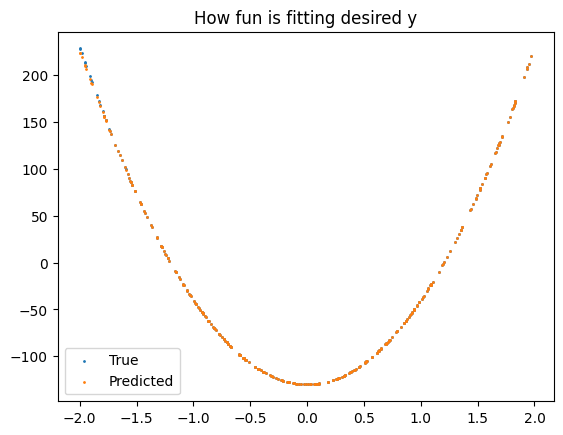

In [208]:
np.random.seed(123)
net = MLP([1, 9, 1], sigmoid, sigmoid_deriv, linear, linear_deriv, init_type="xavier")
net.train(x = x_train, y = y_train, epochs = 100000, optimizer=Adam(beta1=0.99), batch_size=512)
y_pred = net.predict(x_test)
curr_mse = mse(y_pred, y_test)
print(f"\nMSE na testowym wyniosło: {curr_mse}")
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
plt.show()

Po wielu trudach udało się! Wnioski:
- Adam jest kozakiem

### 2. Dane steps_large

In [75]:
# Pobieramy dane
data_train = pd.read_csv("../Data/regression/steps-large-training.csv", index_col = 0).to_numpy()
x_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)

data_test = pd.read_csv("../Data/regression/steps-large-test.csv", index_col = 0).to_numpy()
x_test = data_test[:, 0].reshape(-1, 1)
y_test = data_test[:, 1].reshape(-1, 1)

In [76]:
print(x_train.shape)
print(x_test.shape)

(10000, 1)
(1000, 1)


#### Momentum

Epoch: 1, Loss (standarized): 0.461249317134341
Epoch: 2501, Loss (standarized): 0.001534871326194975
Epoch: 5001, Loss (standarized): 0.001265332715859616
Epoch: 7501, Loss (standarized): 0.0010495743256213632
Epoch: 10001, Loss (standarized): 0.0008540281098299273
Epoch: 12501, Loss (standarized): 0.0008073741166303246
Epoch: 15001, Loss (standarized): 0.0008306650643984713
Epoch: 17501, Loss (standarized): 0.0006719417495077753
Epoch: 20001, Loss (standarized): 0.0008549687891171796
Epoch: 22501, Loss (standarized): 0.0010590109218740226
Epoch: 25001, Loss (standarized): 0.0007686878580484307
Epoch: 27501, Loss (standarized): 0.0007026639951734713
Epoch: 30001, Loss (standarized): 0.0006336157078728372
Epoch: 32501, Loss (standarized): 0.0008312903217635327
Epoch: 35001, Loss (standarized): 0.0005146558465145062
Epoch: 37501, Loss (standarized): 0.0006976826911427351
Epoch: 40001, Loss (standarized): 0.0009238150034356617
Epoch: 42501, Loss (standarized): 0.0008267623336943376
Epoch

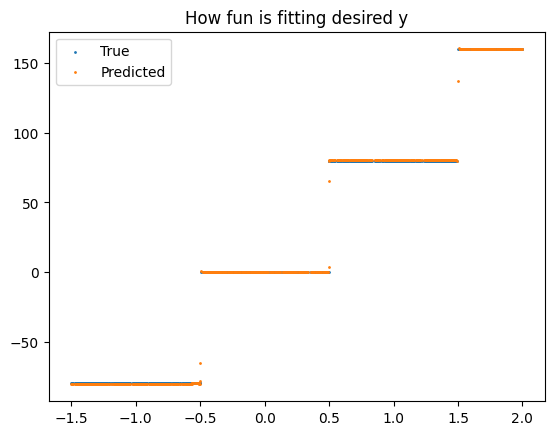

In [99]:
np.random.seed(123)
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv, init_type="xavier")
loss_hist_momentum = net.train_to_visualize(x = x_train, y = y_train, epochs = 50000, optimizer=Momentum(lr=0.05, lamb=0.9), batch_size=32)
y_pred = net.predict(x_test)
curr_mse = mse(y_pred, y_test)
print(f"\nMSE na testowym wyniosło: {curr_mse}")
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
plt.show()

Udało się!

#### RMSProp

Epoch: 1, Loss (standarized): 0.2730585836058333
Epoch: 1001, Loss (standarized): 0.00608337694873304
Epoch: 2001, Loss (standarized): 0.004370467587157059
Epoch: 3001, Loss (standarized): 0.004494217090010324
Epoch: 4001, Loss (standarized): 0.004409361833583226
Epoch: 5001, Loss (standarized): 0.003825755722135009
Epoch: 6001, Loss (standarized): 0.0044434072789022285
Epoch: 7001, Loss (standarized): 0.004006219652400289
Epoch: 8001, Loss (standarized): 0.003641689721700638
Epoch: 9001, Loss (standarized): 0.004061152387449315
Epoch: 10001, Loss (standarized): 0.004258521338548405
Epoch: 11001, Loss (standarized): 0.003872045530362042
Epoch: 12001, Loss (standarized): 0.0038880973199213755
Epoch: 13001, Loss (standarized): 0.003710533567151708
Epoch: 14001, Loss (standarized): 0.003708821958063397
Epoch: 15001, Loss (standarized): 0.0034029715995661787
Epoch: 16001, Loss (standarized): 0.003682110181769
Epoch: 17001, Loss (standarized): 0.003621787396986372
Epoch: 18001, Loss (standa

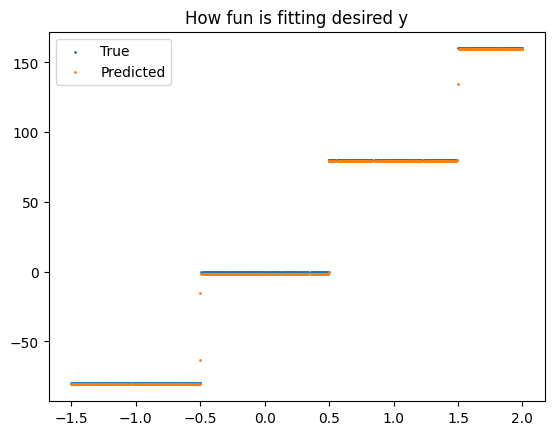

In [97]:
np.random.seed(123)
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv, init_type="random")
loss_hist_rms = net.train_to_visualize(x = x_train, y = y_train, epochs = 20000, optimizer=RMSProp(lr=0.05, beta=0.9), batch_size=32)
y_pred = net.predict(x_test)
curr_mse = mse(y_pred, y_test)
print(f"\nMSE na testowym wyniosło: {curr_mse}")
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
plt.show()

#### Porówanie czasu

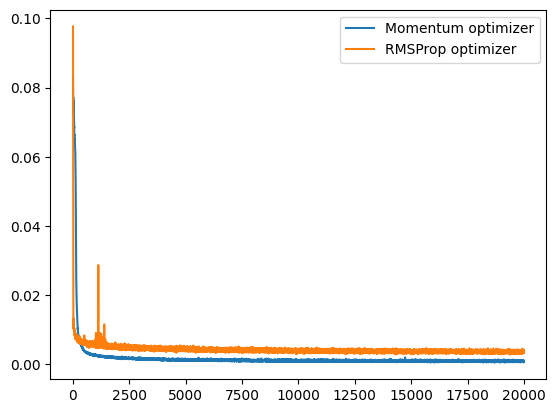

In [109]:
x = np.arange(20000)
idx_from = 1
idx_to = 20000
plt.plot(x[idx_from:idx_to], loss_hist_momentum[idx_from:idx_to], label = "Momentum optimizer")
plt.plot(x[idx_from:idx_to], loss_hist_rms[idx_from:idx_to], label = "RMSProp optimizer")
plt.legend()
plt.show()

### 3. Dane multimodal-large

In [113]:
# Pobieramy dane
data_train = pd.read_csv("../Data/regression/multimodal-large-training.csv").to_numpy()
x_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)

data_test = pd.read_csv("../Data/regression/multimodal-large-test.csv").to_numpy()
x_test = data_test[:, 0].reshape(-1, 1)
y_test = data_test[:, 1].reshape(-1, 1)

In [114]:
print(x_train.shape)
print(x_test.shape)

(10000, 1)
(1000, 1)


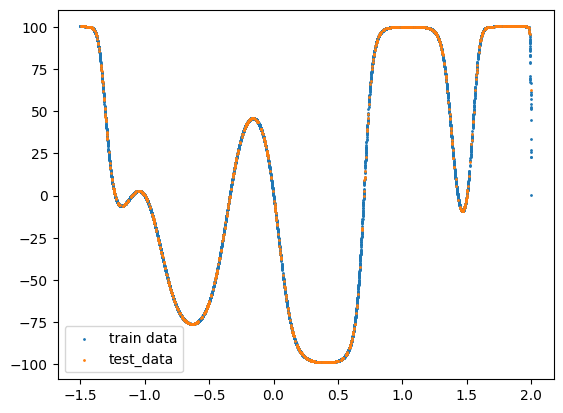

In [118]:
plt.scatter(x_train, y_train, s = 1, label = "train data")
plt.scatter(x_test, y_test, s = 1, label = "test_data")
plt.legend()
plt.show()

#### Momentum

Epoch: 1, Loss (standarized): 0.9018788948852645
Epoch: 81, Loss (standarized): 0.0750324490827895
Epoch: 161, Loss (standarized): 0.06435792215070983
Epoch: 241, Loss (standarized): 0.06153904506306813
Epoch: 321, Loss (standarized): 0.06028589515516474
Epoch: 401, Loss (standarized): 0.05961720713246352
Epoch: 481, Loss (standarized): 0.05878383463907714
Epoch: 561, Loss (standarized): 0.009131589365992308
Epoch: 641, Loss (standarized): 0.0026613393286850622
Epoch: 721, Loss (standarized): 0.0023552484446791914
Epoch: 801, Loss (standarized): 0.002165500725916913
Epoch: 881, Loss (standarized): 0.002015630088314653
Epoch: 961, Loss (standarized): 0.0018569776562789113
Epoch: 1041, Loss (standarized): 0.0017222764107778523
Epoch: 1121, Loss (standarized): 0.0016257677770748992
Epoch: 1201, Loss (standarized): 0.001542825853484751
Epoch: 1281, Loss (standarized): 0.0015001290213987435
Epoch: 1361, Loss (standarized): 0.001450911991159445
Epoch: 1441, Loss (standarized): 0.001414022804

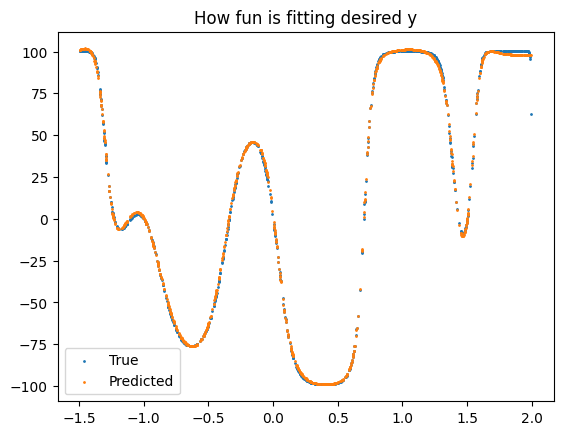

In [160]:
np.random.seed(123)
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv, init_type="xavier")
loss_hist_momentum = net.train_to_visualize(x = x_train, y = y_train, epochs = 1600, optimizer=Momentum(lr=0.1, lamb=0.8), batch_size=32)
y_pred = net.predict(x_test)
curr_mse = mse(y_pred, y_test)
print(f"\nMSE na testowym wyniosło: {curr_mse}")
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
plt.show()

#### RMSProp

Epoch: 1, Loss (standarized): 0.8341599730562343
Epoch: 81, Loss (standarized): 0.03232444767850068
Epoch: 161, Loss (standarized): 0.016280121370042068
Epoch: 241, Loss (standarized): 0.0078858155056538
Epoch: 321, Loss (standarized): 0.0037399937311618707
Epoch: 401, Loss (standarized): 0.003443199781231677
Epoch: 481, Loss (standarized): 0.0033392121651098627
Epoch: 561, Loss (standarized): 0.003199089634617014
Epoch: 641, Loss (standarized): 0.003130547797240336
Epoch: 721, Loss (standarized): 0.0030875839240619724
Epoch: 801, Loss (standarized): 0.0029947826929152357
Epoch: 881, Loss (standarized): 0.003006267851997264
Epoch: 961, Loss (standarized): 0.003030304715780326
Epoch: 1041, Loss (standarized): 0.0029594860425895065
Epoch: 1121, Loss (standarized): 0.002940287448840659
Epoch: 1201, Loss (standarized): 0.002858431117787708
Epoch: 1281, Loss (standarized): 0.0028394478090540396
Epoch: 1361, Loss (standarized): 0.0027812307205009623
Epoch: 1441, Loss (standarized): 0.0027185

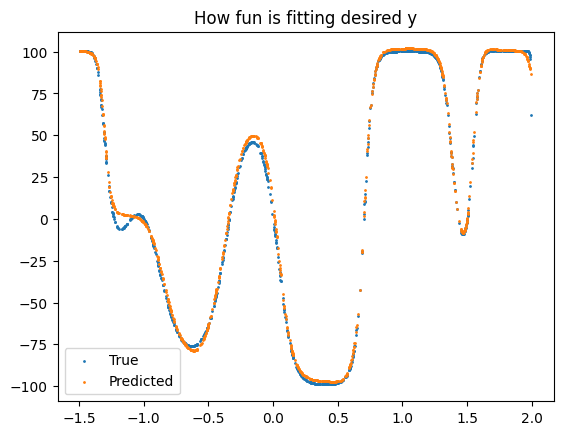

In [162]:
np.random.seed(123)
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv, init_type="xavier")
loss_hist_rms = net.train_to_visualize(x = x_train, y = y_train, epochs = 1600, optimizer=RMSProp(lr=0.01, beta=0.95), batch_size=32)
y_pred = net.predict(x_test)
curr_mse = mse(y_pred, y_test)
print(f"\nMSE na testowym wyniosło: {curr_mse}")
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
plt.show()

Obserwacje:
- RMS prop wymaga mniejszego lr niż momentum
- RMS prop działa wolniej

#### SGD

Epoch: 1, Loss (standarized): 0.9253810592012748
Epoch: 81, Loss (standarized): 0.08940975152875599
Epoch: 161, Loss (standarized): 0.06646768484922146
Epoch: 241, Loss (standarized): 0.06296610785802592
Epoch: 321, Loss (standarized): 0.060366869477045844
Epoch: 401, Loss (standarized): 0.021065114984510226
Epoch: 481, Loss (standarized): 0.008769322344425654
Epoch: 561, Loss (standarized): 0.004160552365183298
Epoch: 641, Loss (standarized): 0.005458853795628407
Epoch: 721, Loss (standarized): 0.007255357571436379
Epoch: 801, Loss (standarized): 0.0052337594465571
Epoch: 881, Loss (standarized): 0.004966294170320606
Epoch: 961, Loss (standarized): 0.004273693887424519
Epoch: 1041, Loss (standarized): 0.0038402777231175407
Epoch: 1121, Loss (standarized): 0.0032809199221302916
Epoch: 1201, Loss (standarized): 0.0028755582682022736
Epoch: 1281, Loss (standarized): 0.002590760367784827
Epoch: 1361, Loss (standarized): 0.003226118354110857
Epoch: 1441, Loss (standarized): 0.0026104792690

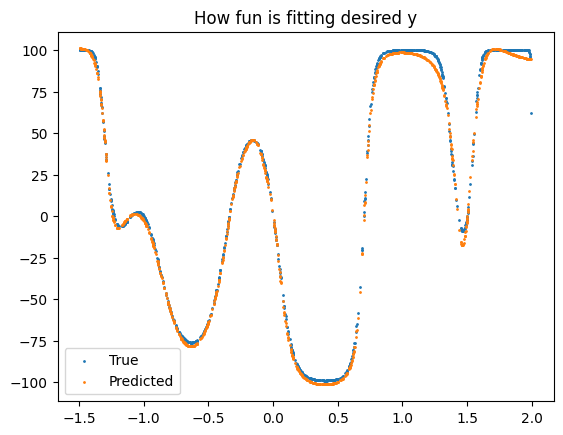

In [163]:
np.random.seed(123)
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv, init_type="xavier")
loss_hist_sgd = net.train_to_visualize(x = x_train, y = y_train, epochs = 1600, optimizer=SGD(lr=0.4), batch_size=32)
y_pred = net.predict(x_test)
curr_mse = mse(y_pred, y_test)
print(f"\nMSE na testowym wyniosło: {curr_mse}")
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
plt.show()

#### Adam

Epoch: 1, Loss (standarized): 1.018126401936395
Epoch: 81, Loss (standarized): 0.195190574209911
Epoch: 161, Loss (standarized): 0.0021253348765499264
Epoch: 241, Loss (standarized): 0.0018975530379180528
Epoch: 321, Loss (standarized): 0.0015090301255279918
Epoch: 401, Loss (standarized): 0.0014170514793553812
Epoch: 481, Loss (standarized): 0.001408038776030548
Epoch: 561, Loss (standarized): 0.0013388194037964479
Epoch: 641, Loss (standarized): 0.0013276950053483917
Epoch: 721, Loss (standarized): 0.0012919505442044598
Epoch: 801, Loss (standarized): 0.0012441093545173937
Epoch: 881, Loss (standarized): 0.001255240483775949
Epoch: 961, Loss (standarized): 0.0011329863185411885
Epoch: 1041, Loss (standarized): 0.0011458758508562253
Epoch: 1121, Loss (standarized): 0.0012755248348158064
Epoch: 1201, Loss (standarized): 0.001077804439803834
Epoch: 1281, Loss (standarized): 0.0010264253497971937
Epoch: 1361, Loss (standarized): 0.0009533049127735816
Epoch: 1441, Loss (standarized): 0.00

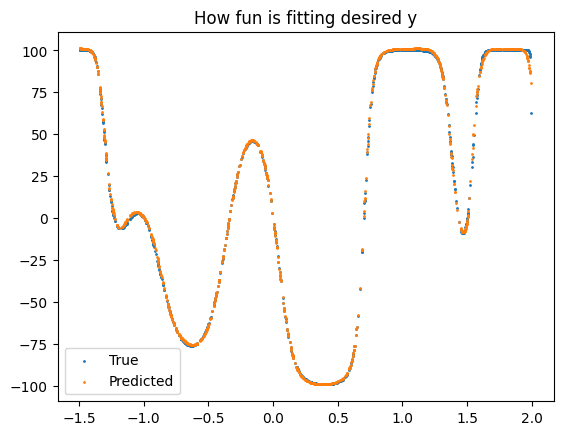

In [164]:
np.random.seed(123)
net = MLP([1, 5, 5, 5, 1], sigmoid, sigmoid_deriv, linear, linear_deriv, init_type="xavier")
loss_hist_adam = net.train_to_visualize(x = x_train, y = y_train, epochs = 1600, optimizer=Adam(), batch_size=32)
y_pred = net.predict(x_test)
curr_mse = mse(y_pred, y_test)
print(f"\nMSE na testowym wyniosło: {curr_mse}")
print("\nDLA ZBIORU TESTOWEGO")
eval_2d(net, x_test, y_test)
plt.show()

Obserwacje:
- ten optimizer woli większe batch_size
- Adam jest super

#### Porównanie czasu

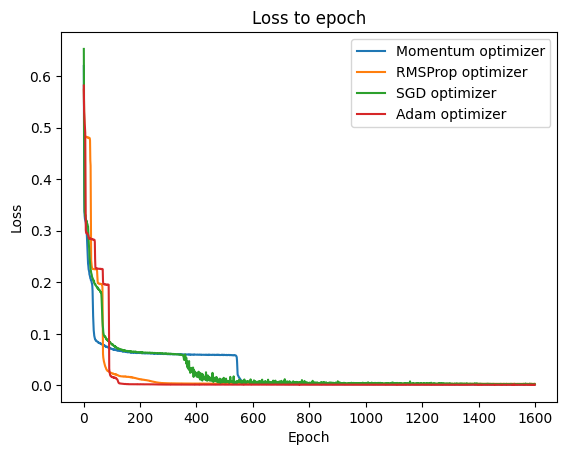

In [170]:
x = np.arange(1600)
idx_from = 1
idx_to = 1600
plt.plot(x[idx_from:idx_to], loss_hist_momentum[idx_from:idx_to], label = "Momentum optimizer")
plt.plot(x[idx_from:idx_to], loss_hist_rms[idx_from:idx_to], label = "RMSProp optimizer")
plt.plot(x[idx_from:idx_to], loss_hist_sgd[idx_from:idx_to], label = "SGD optimizer")
plt.plot(x[idx_from:idx_to], loss_hist_adam[idx_from:idx_to], label = "Adam optimizer")
plt.legend()
plt.title("Loss to epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

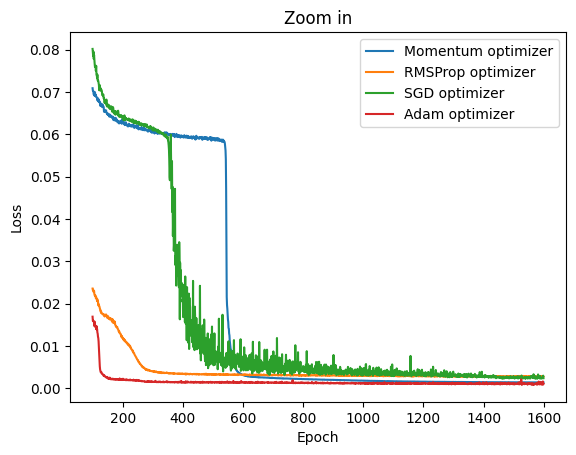

In [173]:
x = np.arange(1600)
idx_from = 100
idx_to = 1600
plt.plot(x[idx_from:idx_to], loss_hist_momentum[idx_from:idx_to], label = "Momentum optimizer")
plt.plot(x[idx_from:idx_to], loss_hist_rms[idx_from:idx_to], label = "RMSProp optimizer")
plt.plot(x[idx_from:idx_to], loss_hist_sgd[idx_from:idx_to], label = "SGD optimizer")
plt.plot(x[idx_from:idx_to], loss_hist_adam[idx_from:idx_to], label = "Adam optimizer")
plt.legend()
plt.title("Zoom in")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()